# **Tiffany's Data Analysis**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import necessary packages
import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
import seaborn as sns

# Data Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

# Model Imports
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Model Performance Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Model Validation or Hyperparameter Tuning
from sklearn.model_selection import KFold # k-fold cv
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV

from sklearn.datasets import make_blobs
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

%matplotlib inline

## **Data Processing**

In [ ]:
# read the data in
ai = pd.read_csv("/content/drive/MyDrive/JuniorYear/MGSC310/MGSC310_Final_Project/Tiffany/AI_Tools_Updated - Sheet1.csv")

In [ ]:
# print out all of the feature names
ai.columns

Index(['AI Tool Name', 'Description', 'Free/Paid/Other', 'Useable For',
       'Charges', 'Review', 'Tool Link', 'Major Category'],
      dtype='object')

In [ ]:
ai.head(10)

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code
5,1Pm Workout,Become The Next One Punch Man!,Free,/ fitness,NaN,NaN,https://opmworkout.ml/?utm_source=futurepedia&...,other
6,2D&3D Video Converter,iDATAPP 3D Converter: Transform Your Videos in...,Free,/ 3D,NaN,NaN,https://idatapp.com/software/3d-converter?utm_...,3D
7,2Short.Ai,Elevate your YT content with AI generated shorts,Freemium,/ video editing / social media assistant,$9.90,1,https://2short.ai/?utm_source=futurepedia&utm_...,text
8,2Siq,Forward emails and get replies.,Freemium,/ email assistant,$3,NaN,https://2siq.com/?utm_source=futurepedia&utm_m...,text
9,3Dfy,3DFY.ai is an artificial intelligence (AI) too...,Free,/ 3D,NaN,NaN,https://3dfy.ai/?utm_source=futurepedia&utm_me...,3D


### **Feature Engineering: Charges Data Extraction**
Split the `Charges` into two new columns: `charge_frequency` and `charge_amount`. Assigning unique `charge_frequency` to 'other,' if that AI tool is the only one that uses that frequency technique.

In [ ]:
# Function to extract charge amount
def extract_charge_amount(charge):
    if pd.notna(charge):
        charge_str = str(charge)
        # Extract numeric value
        numeric_value = None
        for part in charge_str.split('/'):
            try:
                numeric_value = float(part.replace('$', '').replace(',', '').strip())
                break
            except ValueError:
                pass
        return numeric_value

# Function to extract frequency of charge
def extract_frequency(charge):
    if pd.notna(charge):
        charge_str = str(charge)
        # Extract frequency
        if '/' in charge_str:
            frequency_part = charge_str.split('/')[1].strip()
            if 'wk' in frequency_part.lower():
                return 'Weekly'
            elif 'mo' in frequency_part.lower():
                return 'Monthly'
            elif 'yr' in frequency_part.lower():
                return 'Yearly'
            elif 'day' in frequency_part.lower():
                return 'Daily'
            elif 'hr' in frequency_part.lower():
                return 'Hourly'
            elif 'min' in frequency_part.lower():
                return 'Minute'
            else:
                return 'Other' # Assign 'Other' to the unique cases
        else:
            return 'One-time'
    else:
        return 'No charge'

In [ ]:
# apply the extraction on the data in the `Charges` column
ai['charge_amount'] = ai['Charges'].apply(extract_charge_amount)
ai['charge_frequency'] = ai['Charges'].apply(extract_frequency)

In [ ]:
value_counts = ai['charge_frequency'].value_counts()

print(value_counts)

No charge    2441
Monthly      1777
One-time      671
Other          36
Yearly         17
Weekly         11
Hourly          9
Minute          6
Daily           3
Name: charge_frequency, dtype: int64


In [ ]:
ai.head(10)

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category,charge_amount,charge_frequency
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other,NaN,No charge
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text,4.95,Monthly
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio,100.00,Monthly
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image,NaN,No charge
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code,NaN,No charge
5,1Pm Workout,Become The Next One Punch Man!,Free,/ fitness,NaN,NaN,https://opmworkout.ml/?utm_source=futurepedia&...,other,NaN,No charge
6,2D&3D Video Converter,iDATAPP 3D Converter: Transform Your Videos in...,Free,/ 3D,NaN,NaN,https://idatapp.com/software/3d-converter?utm_...,3D,NaN,No charge
7,2Short.Ai,Elevate your YT content with AI generated shorts,Freemium,/ video editing / social media assistant,$9.90,1,https://2short.ai/?utm_source=futurepedia&utm_...,text,9.90,One-time
8,2Siq,Forward emails and get replies.,Freemium,/ email assistant,$3,NaN,https://2siq.com/?utm_source=futurepedia&utm_m...,text,3.00,One-time
9,3Dfy,3DFY.ai is an artificial intelligence (AI) too...,Free,/ 3D,NaN,NaN,https://3dfy.ai/?utm_source=futurepedia&utm_me...,3D,NaN,No charge


###**Summary Plot #1**

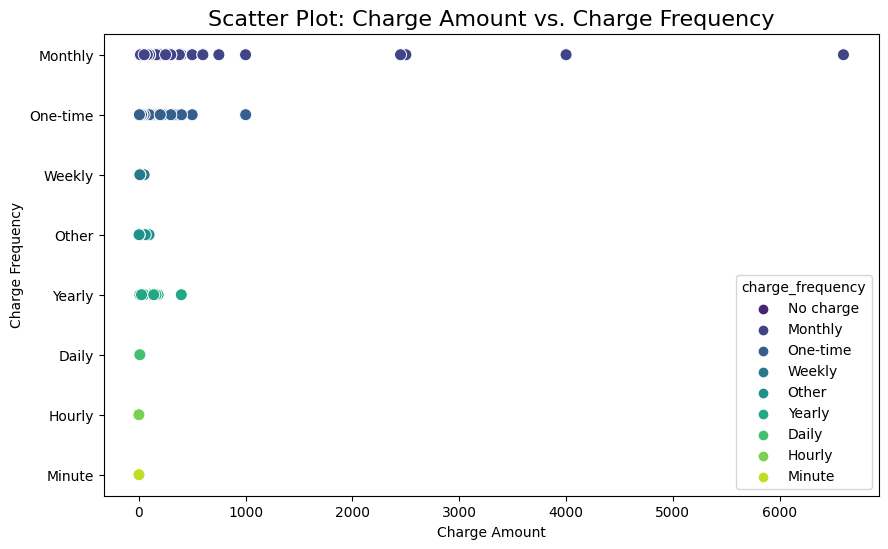

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='charge_amount', y='charge_frequency', data=ai, hue='charge_frequency', palette='viridis', s = 75)
plt.title('Scatter Plot: Charge Amount vs. Charge Frequency', fontsize=16)
plt.xlabel('Charge Amount')
plt.ylabel('Charge Frequency')
plt.show()

### **Summary Plot #2**

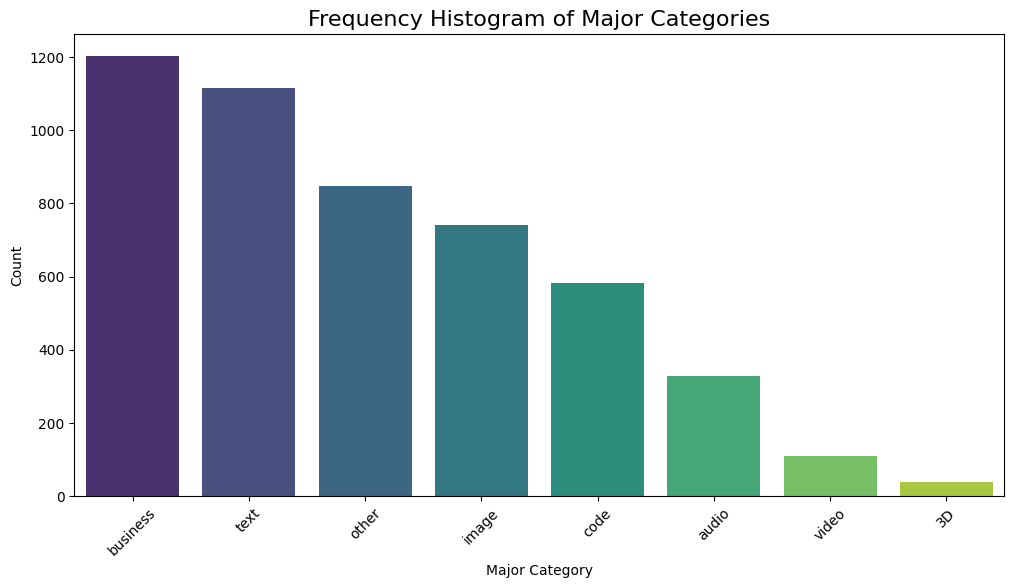

In [ ]:
major_category_counts = ai['Major Category'].value_counts()
# Sort Major Category values based on their counts in descending order
sorted_major_categories = major_category_counts.index

plt.figure(figsize=(12, 6))
sns.countplot(x='Major Category', data=ai, order=sorted_major_categories, palette='viridis')
plt.title('Frequency Histogram of Major Categories', fontsize = 16)
plt.xlabel('Major Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Summary Plot #3**

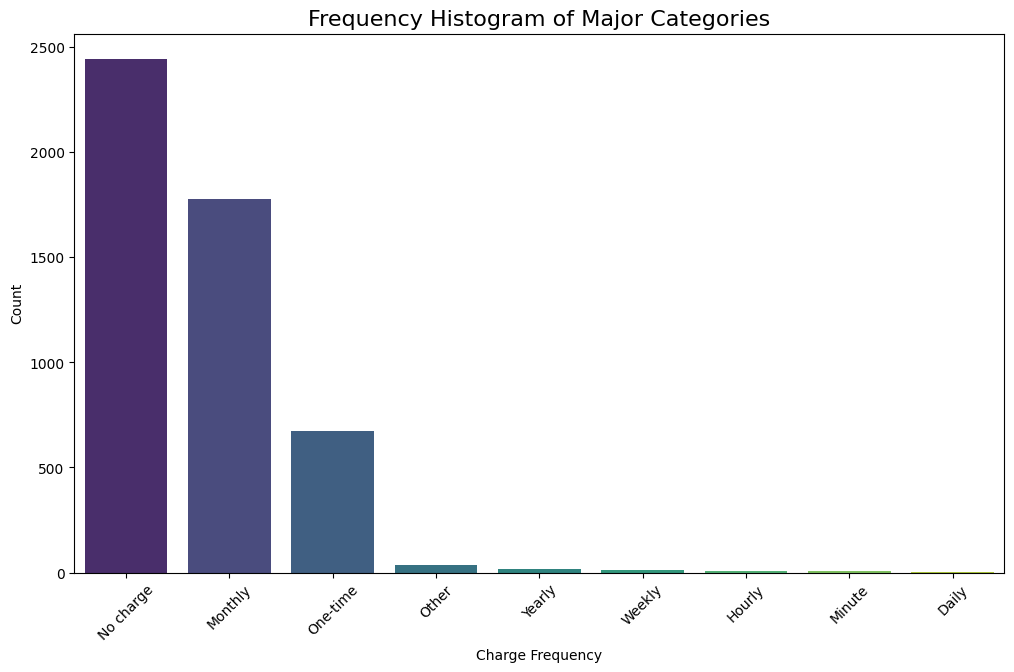

In [ ]:
charge_frequency_counts = ai['charge_frequency'].value_counts()
# Sort Major Category values based on their counts in descending order
sorted_frequency_categories = charge_frequency_counts.index

plt.figure(figsize=(12, 7))
sns.countplot(x='charge_frequency', data=ai, order=sorted_frequency_categories, palette='viridis')
plt.title('Frequency Histogram of Major Categories', fontsize = 16)
plt.xlabel('Charge Frequency')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## **Comparison of Datasets**
We will be comparing the model's performance in clustering, regression, and classification between two datasets; the original AI tool dataset and an altered dataset that only includes data of AI tools with the top three charge frequency value.

### **AI Dataset**
Performing a (1) clustering, (2) regression analysis, and (3) classification analysis on the entire dataset, regardless of the charge_frequency class

**Variables**
* `Free/Paid/Other`
* `Useable For`
* `Charges`
* `Major Category`
* `charge_amount` (dependent var for the regression analysis)
* `charge_frequency`(dependent var for the classification analysis)



#### Pre-Processing Data (for Clustering and Predicting)
Dropping missing values, separating features, and inputing missing values, and extracting the text data from the 'Useable For' column

In [ ]:
# dropping any missing values for the variables that will be used to cluster
check_cols = ['AI Tool Name', 'Description', 'Free/Paid/Other', 'Useable For', 'Major Category']
ai = ai.dropna(subset = check_cols).reset_index(drop = True)

# separate categorical, continuous, and text columns
cat = ['Free/Paid/Other', 'Major Category', 'charge_frequency']
text = ['Useable For']
cont = ['charge_amount']

# imput missing values in the numerical columns (charge amount of 0 = no charge)
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
ai[cont] = imputer.fit_transform(ai[cont])

# Extracting the first category from 'Useable For' (assuming it's delimited by '/')
ai['Useable_For_Category'] = ai['Useable For'].apply(lambda x: x.split('/')[1].strip() if '/' in x else x)
# Drop the original 'Useable For' column
ai = ai.drop('Useable For', axis=1)

####**Clustering**
Get more context on the different clusters/groups that exist in the AI tool industry

##### Data Pre-Processing & Principal Component Analysis

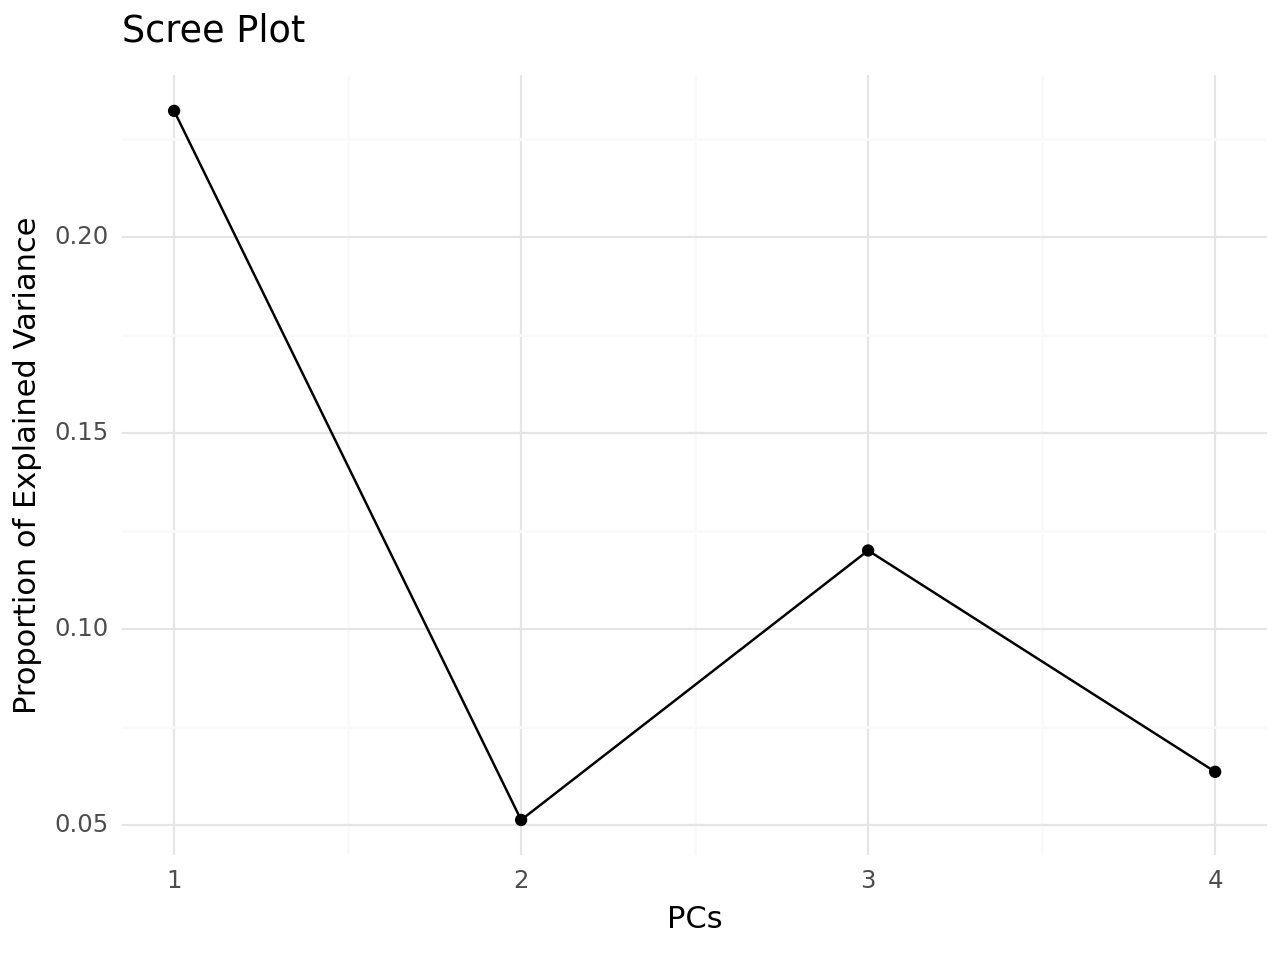

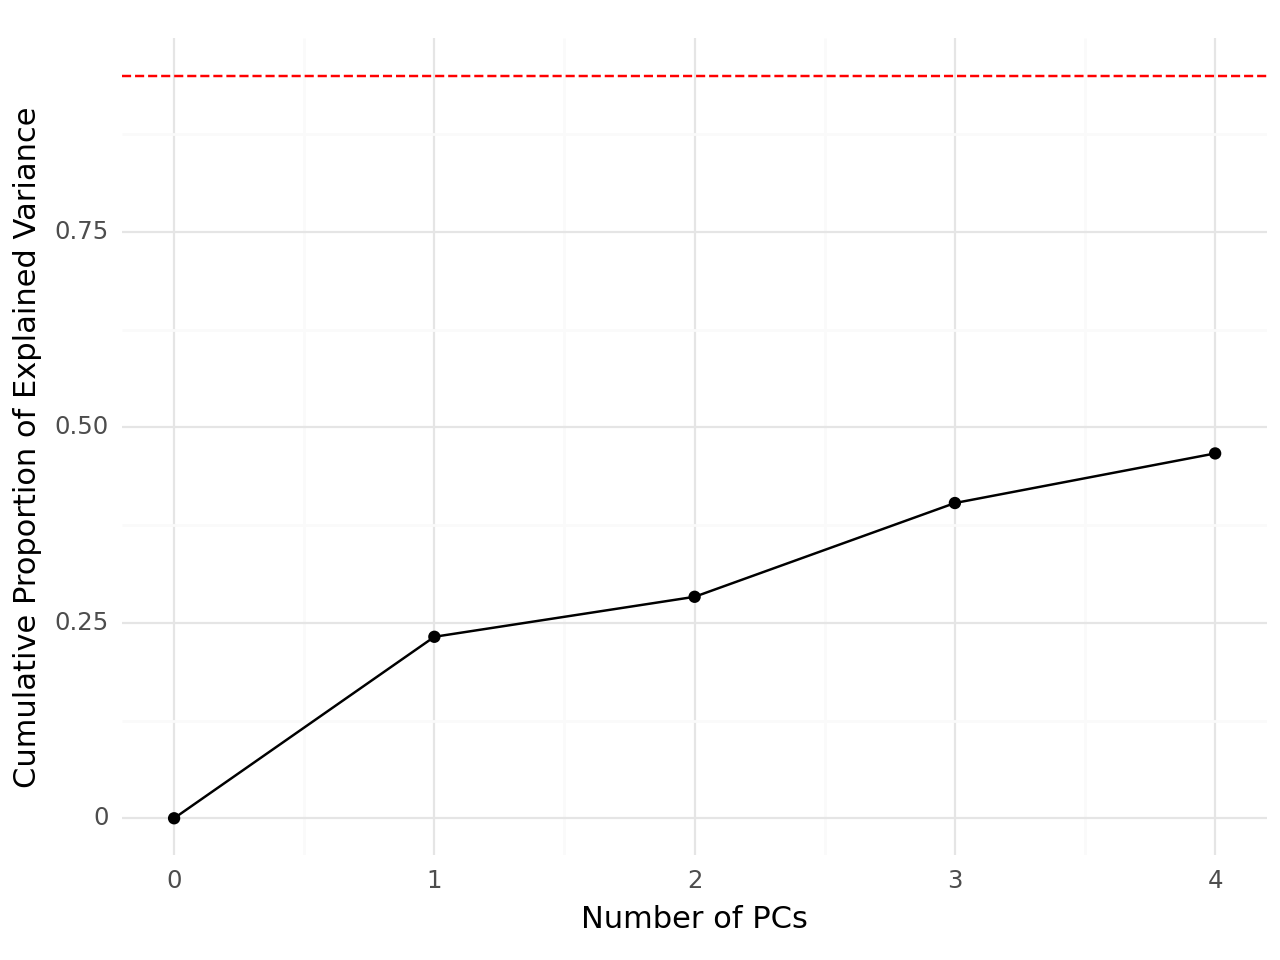

In [ ]:
# SVD
svd = TruncatedSVD(n_components=4)

# One-Hot - 'Free/Paid/Other', 'Major Category'
cat_pipe = Pipeline([('onehot', OneHotEncoder())])

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont),
        ('cat', OneHotEncoder(), cat),
        ('text', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# grab the columns we want to use
feat = [n for n in ai.columns if n not in ["AI Tool Name", "Description", "Charges", "Review", "Tool Link"]]
X = ai[feat]

# Include SVD in the pipeline
pipe_svd = Pipeline([
    ("z", z),
    ("svs", svd)
])

# Fit and transform the data using the pipeline
transformed_data = pipe_svd.fit_transform(X)

# scree/cumvar data frame
pcaDF = pd.DataFrame({"expl_var" :
                      pipe_svd.named_steps["svs"].explained_variance_ratio_,
                      "pc": range(1,5),
                      "cum_var":
                      pipe_svd.named_steps["svs"].explained_variance_ratio_.cumsum()})

# scree plot
print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

# cumulative variance data frame
pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})]) # add 0,0 for reference

# cumulative var plot
print(ggplot(pcaDF0, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.95, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance"))

**Scree Plot**: Shows how much of the original features' variance was preserved by each PCs.

**Cumulative Variance Plot** Shows the cumulative variance explained by the first N PCs.

If we plot this with 5 PCs, we can actually see that the plot "elbows" at PC4. After PC4, we can see that the return in variance decreases significantly.

##### K-Means

In [ ]:
km = KMeans(n_clusters=7)

# create a pipeline for K-Means
k_pipe = Pipeline([
    ("z", z),
    ("svs", svd),
    ("model", km)
])

# Fit and predict labels
labels = k_pipe.fit_predict(X)

# Calculate Silhouette Score on the transformed data
silhouette = silhouette_score(transformed_data, labels)
print("K-Means - Silhouette Score: ", silhouette)

ai["clusters"] = labels
ai[["pc1", "pc2", "pc3", "pc4"]] = pd.DataFrame(pipe_svd.transform(ai[feat]))

K-Means - Silhouette Score:  0.7127158886565128


##### Hyperparameter Tuning
Visualizing the fluctations in the SSE and Silhoette Score given the change in k

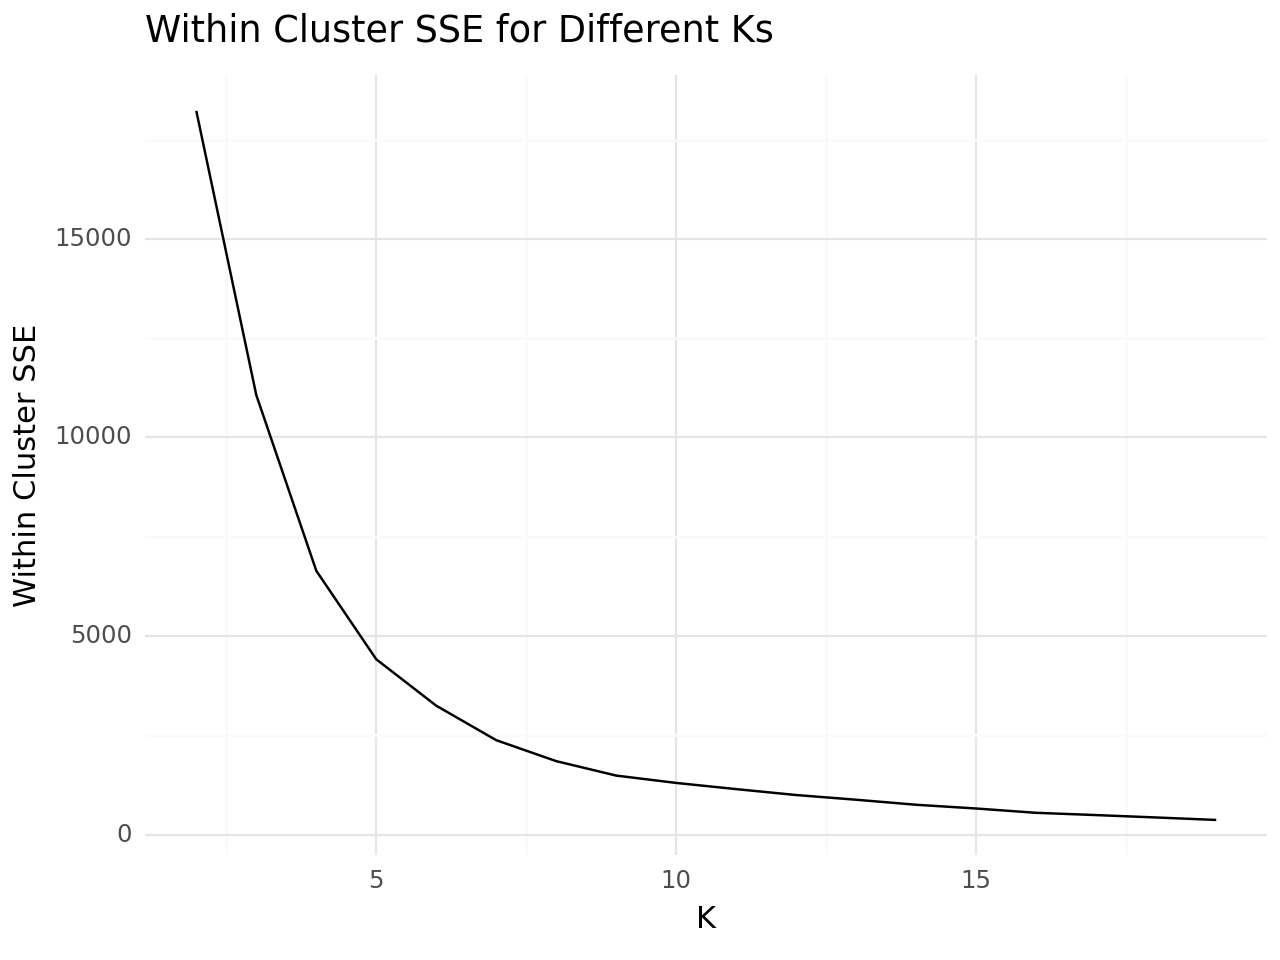

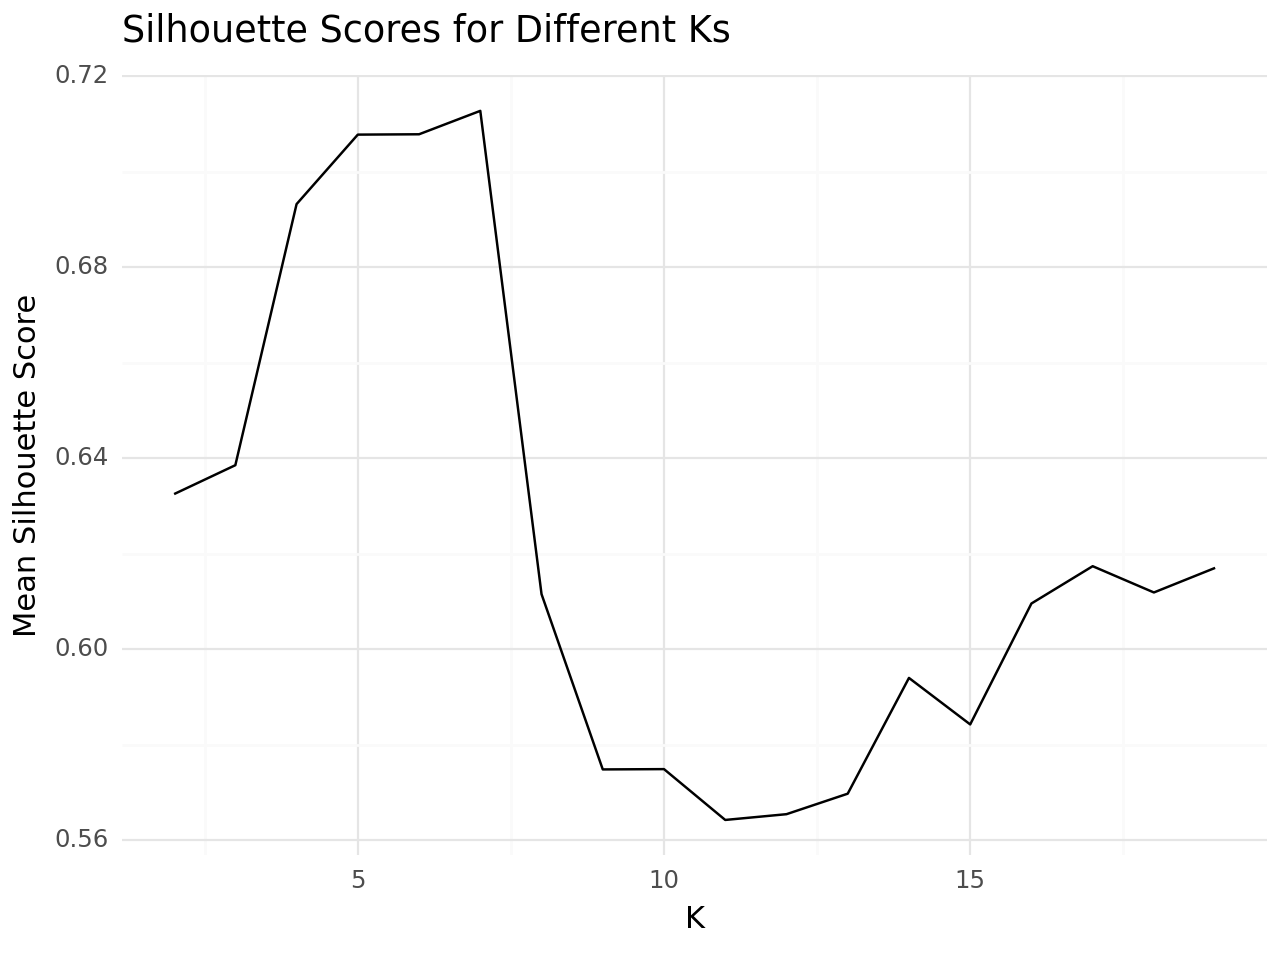

In [ ]:
metrics = {"SSE": [], "sil": [], "k": []}
for i in range(2,20):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z),
        ("svs", svd),
        ("km", km)
    ])

    labels = pipe.fit_predict(X)
    sil = silhouette_score(transformed_data, labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

# SSE Plot
print(ggplot(df, aes(x = "k", y = "SSE")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Within Cluster SSE",
         title = "Within Cluster SSE for Different Ks"))

# Silhouette Plot
print(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

**Within Cluster SSE** We can see that at around ~5-7, the plot begins to "elbow." Similar to the Scree Plot, the reducing in SSE begins to decrease significantly.

**Silhouette Score Plot** We can see how the S score fluctuates depends on the number of clusters that the plot will have. A silhouette score measures how well a clustering model depending on the cohesio (how close the data point in each cluster are to one another) and separation (distance between clusters) of the data points.

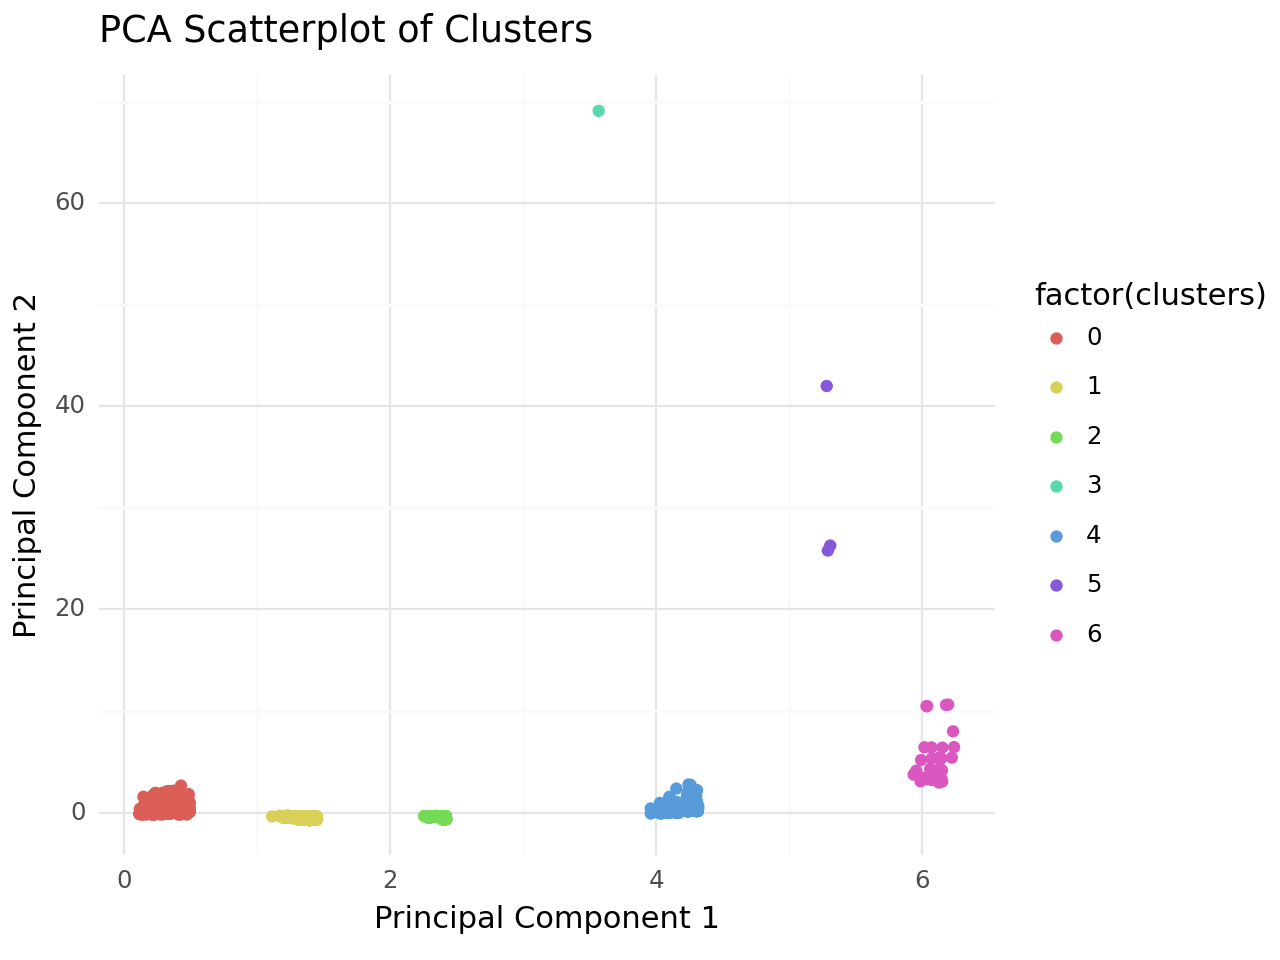

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(ai, aes(x = "pc1", y = "pc2", color = "factor(clusters)")) + geom_point() +
  theme_minimal()+
  labs(title = 'PCA Scatterplot of Clusters', x = 'Principal Component 1', y = 'Principal Component 2'))

**PCA Scatterplot of Clusters** Through this plot, we can see how our clustering model performed with the "AI" dataset. We can see that clusters 3 and 5's values are more outlier like compared to the other three clusters.

####**Predictive Model**: Charge Amount
How much should a company charge for their product?

##### Data Pre-Processing & Random Forest Regressor Model

In [ ]:
# Split the Independent and Dependent Variables
predictors = ['Free/Paid/Other', 'Major Category', 'Useable_For_Category', 'charge_frequency']
category = ['Free/Paid/Other', 'Major Category', 'charge_frequency']
text_var = ['Useable_For_Category']

X = ai[predictors]
y = ai['charge_amount']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 1234)

# One-Hot - 'Free/Paid/Other', 'Major Category'
cat_pipe = Pipeline([('onehot', OneHotEncoder())])

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore'), category),
        ('text_var', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# Random Forest Regressor Model - Empty Model
rf = RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 123)

# Create Pipeline
pipe = Pipeline([
    ("z", z),
    ("tree", rf)
])

##### Hyperparameter Tuning
---

*  Random Search CV - Random Forest Regressor

*   Recommend the number of estimators to use, max depth of tree, and the random state





In [ ]:
# Random Search CV
param_dist = {
    'tree__n_estimators': [25, 50, 100, 150],
    'tree__max_depth': [None, 5, 10, 15],
    'tree__random_state': [42, 84, 123]

}

# use grid search to find best parameters
grid = RandomizedSearchCV(pipe, param_distributions=param_dist, cv = 5, refit = True)

grid.fit(X_train, y_train)

print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__n_estimators"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__max_depth"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__random_state"])


RandomizedSearchCV chose:  100
RandomizedSearchCV chose:  5
RandomizedSearchCV chose:  123


##### Model Validation
----
K-Fold

In [ ]:
# model validation
kf = KFold(5)

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}
mape = {"train": [], "test": []}
r2 = {"train": [], "test": []}

# Loop Over Folds
for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

    mape["train"].append(mean_absolute_percentage_error(y_train,y_pred_train))
    mape["test"].append(mean_absolute_percentage_error(y_test,y_pred_test))

    r2["train"].append(r2_score(y_train,y_pred_train))
    r2["test"].append(r2_score(y_test,y_pred_test))


# Print out the Performance Evaluations
print("Train MSEs:", mse["train"])
print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))

print("Train MAEs:", mae["train"])
print("Test MAEs :", mae["test"])
print("Train MAE :", np.mean(mae["train"]))
print("Test MAE  :", np.mean(mae["test"]))

print("Train MAPEs:", mape["train"])
print("Test MAPEs :", mape["test"])
print("Train MAPE :", np.mean(mape["train"]))
print("Test MAPE  :", np.mean(mape["test"]))

print("Train R2s:", r2["train"])
print("Test R2s :", r2["test"])
print("Train R2 :", np.mean(r2["train"]))
print("Test R2  :", np.mean(r2["test"]))

Train MSEs: [17357.064208656462, 14093.176992711984, 6975.9306504385095, 18659.311695799264, 18249.60774165724]
Test MSEs : [7629.025353388929, 23121.299064667885, 52283.906880725604, 2272.899196713739, 3877.5795007777892]
Train MSE : 15067.018257852691
Test MSE  : 17836.941999254792
Train MAEs: [20.017150741740657, 17.60363147237307, 15.586490119188214, 20.045083124489945, 19.731684650273614]
Test MAEs : [16.030056628414414, 24.435572759390634, 24.987939394078555, 16.588662322196555, 16.324640371612393]
Train MAE : 18.5968080216131
Test MAE  : 19.673374295138508
Train MAPEs: [742317962405105.8, 659924084911020.5, 794851107838888.6, 746899065672454.6, 844837040341456.6]
Test MAPEs : [1209823633767817.8, 1235115356544165.5, 590074083007702.9, 684291136815178.5, 417744863722276.9]
Train MAPE : 757765852233785.2
Test MAPE  : 827409814771428.2
Train R2s: [0.09455216304462866, 0.13041239948336203, 0.09924519081530703, 0.08752473752146406, 0.08889804691120862]
Test R2s : [-0.1034264175496588

Text(0.5, 0, 'Permutation Feature Importance')

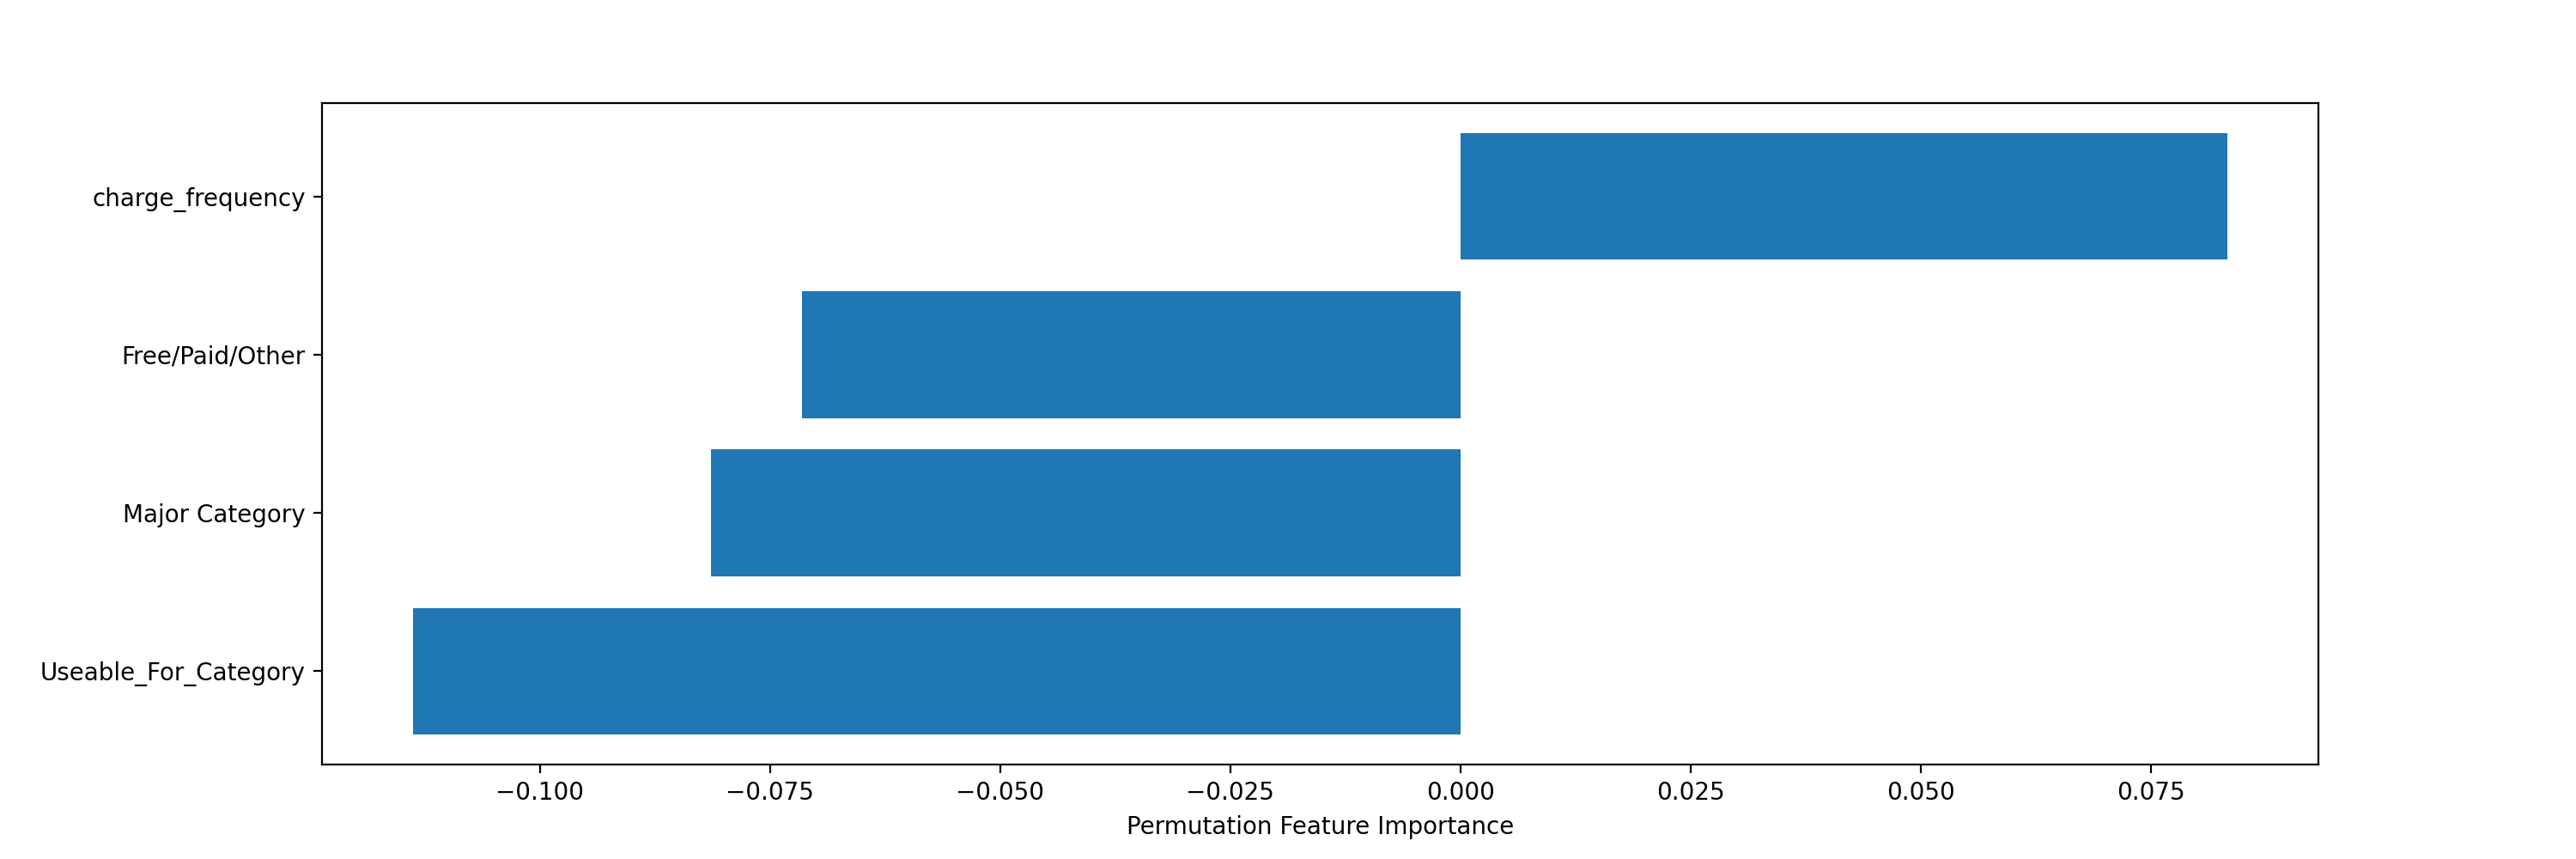

In [ ]:
# Compute permutation feature importance
perm_importance = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=45322)

# Display feature importances
feature_names = X.columns
sorted_idx = perm_importance.importances_mean.argsort()
# Increase figure width
plt.figure(figsize=(15, 5))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")

####**Predictive Model**: Charge Frequency
How frequent should a company charge their customers?

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class MultiColumnLabelEncoder(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_encoded = X.apply(LabelEncoder().fit_transform)
        return X_encoded

In [ ]:
# Split the Independent and Dependent Variables
predictors = ['Free/Paid/Other', 'Major Category', 'Useable_For_Category', 'charge_amount']
category = ['Free/Paid/Other', 'Major Category']
text_var = ['Useable_For_Category']
cont = ['charge_amount']

X = ai[predictors]
y = ai["charge_frequency"]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=1234)

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), cont),
        ('category', MultiColumnLabelEncoder(), category),  # Use MultiColumnLabelEncoder for label encoding
        ('text_var', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# Random Forest Classifier Model - Empty Model
rf = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=42)

# Create Pipeline
pipe_cat = Pipeline([
    ("z", z),
    ("tree", rf)
])

# fit
pipe_cat.fit(X_train, y_train)

# predict
y_pred_train = pipe_cat.predict(X_train)
y_pred_test = pipe_cat.predict(X_test)

y_pred_train_prob = pipe_cat.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe_cat.predict_proba(X_test)[:,1]

##### **Hyperparameter Tuning**
* Random Search CV - Random Forest Classifier
* Recommend the number of estimators to use, max depth of tree, and the random state


In [ ]:
# Random Search CV
param_dist = {
    'tree__n_estimators': [10, 15, 25, 50, 100, 150],
    'tree__max_depth': [None, 5, 10, 15],
    'tree__random_state': [24, 42, 84, 123]

}

# use grid search to find best parameters
grid = RandomizedSearchCV(pipe_cat, param_distributions=param_dist, cv = 5, refit = True)

# fit the training data on the grid search
grid.fit(X_train, y_train)

print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__n_estimators"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__max_depth"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__random_state"])

RandomizedSearchCV chose:  10
RandomizedSearchCV chose:  15
RandomizedSearchCV chose:  42


##### Assessing the Performance of the Model

In [ ]:
# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Precision: ", precision_score(y_train, y_pred_train, average ='weighted'))
print("Train Recall    : ", recall_score(y_train, y_pred_train, average = 'weighted'))
print("Train F1        : ", f1_score(y_train, y_pred_train, average = 'weighted'))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test, average = 'weighted'))
print("Test Recall     : ", recall_score(y_test, y_pred_test, average = 'weighted'))
print("Test F1         : ", f1_score(y_test, y_pred_test, average = 'weighted'))

Train Acc       :  0.8880432113920943
Train Precision:  0.8915964719193508
Train Recall    :  0.8880432113920943
Train F1        :  0.8655398725024757
Test Acc        :  0.8502793296089386
Test Prescision :  0.8462134898413246
Test Recall     :  0.8502793296089386
Test F1         :  0.7983256284626079


In [ ]:
# Assuming y_pred_train_prob contains the predicted probabilities for each class
y_pred_train_prob = pipe_cat.predict_proba(X_train)  # Replace 'model' with your actual model

# Binarize the labels
y_bin = label_binarize(y_train, classes=np.unique(y_train))

# Initialize variables
roc_auc_scores = []
class_weights = []

# Calculate ROC AUC for each class
for i in range(y_bin.shape[1]):
    roc_auc_i = roc_auc_score(y_bin[:, i], y_pred_train_prob[:, i])
    roc_auc_scores.append(roc_auc_i)
    class_weight_i = np.sum(y_train == i) / (len(y_train) + 1e-9)  # Adding a small value to prevent division by zero
    class_weights.append(class_weight_i)

# Check if all class weights are zero
if np.sum(class_weights) == 0:
    # If all class weights are zero, assign equal weights
    class_weights = np.ones_like(class_weights) / len(class_weights)

# Calculate weighted average ROC AUC
weighted_avg_roc_auc = np.average(roc_auc_scores, weights=class_weights)

print("Train ROC AUC   : ", weighted_avg_roc_auc)

Train ROC AUC   :  0.9841132217295554


In [ ]:
# Assuming y_pred_test_prob contains the predicted probabilities for each class on the test set
y_pred_test_prob = pipe_cat.predict_proba(X_test)  # Replace 'model' with your actual model

# Binarize the labels for the test set
y_bin_test = label_binarize(y_test, classes=np.unique(y_test))

# Initialize variables
roc_auc_scores = []
class_weights = []

# Calculate ROC AUC for each class on the test set
for i in range(y_bin_test.shape[1]):
    roc_auc_i = roc_auc_score(y_bin_test[:, i], y_pred_test_prob[:, i])
    roc_auc_scores.append(roc_auc_i)
    class_weight_i = np.sum(y_test == i) / (len(y_test) + 1e-9)  # Adding a small value to prevent division by zero
    class_weights.append(class_weight_i)

# Check if all class weights are zero
if np.sum(class_weights) == 0:
    # If all class weights are zero, assign equal weights
    class_weights = np.ones_like(class_weights) / len(class_weights)

# Calculate weighted average ROC AUC on the test set
weighted_avg_roc_auc = np.average(roc_auc_scores, weights=class_weights)

print("Test ROC AUC    : ", weighted_avg_roc_auc)

Test ROC AUC    :  0.5740150201251455


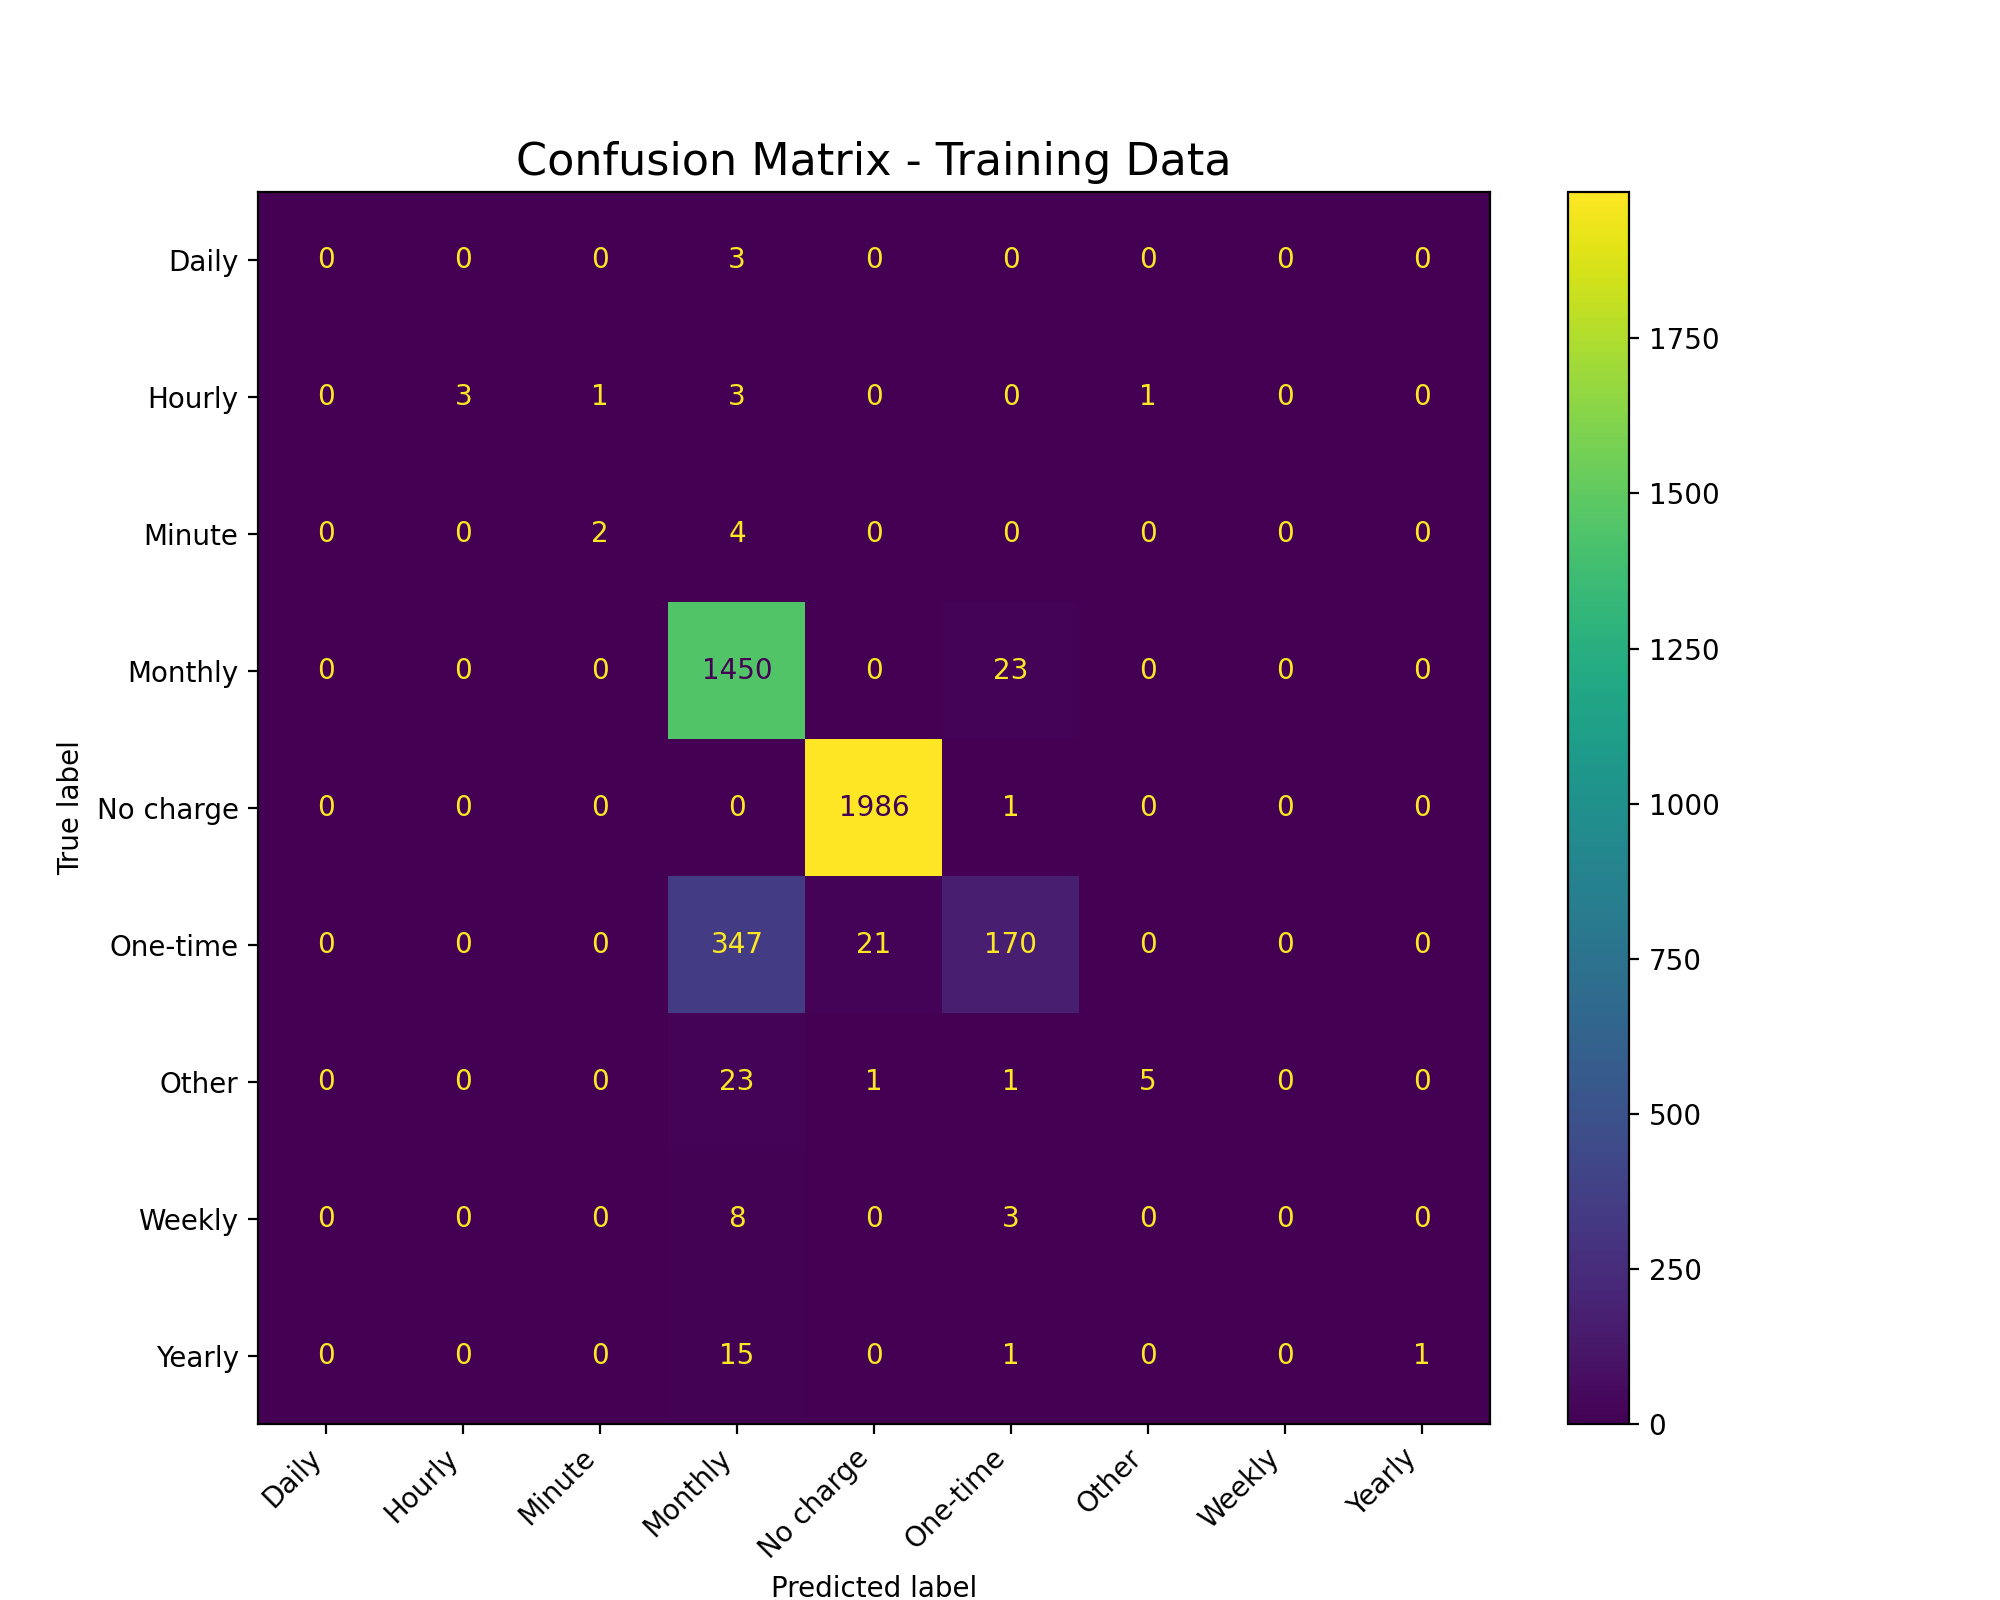

In [ ]:
# Set figure size to adjust height
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Add a title
plt.title("Confusion Matrix - Training Data", fontsize = 16)

# Create Confusion Matrix Display within a subplot
ax = plt.subplot(111)
disp_train = ConfusionMatrixDisplay.from_estimator(pipe_cat, X_train, y_train, ax=ax)

# Get the current axes and modify the tick labels rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

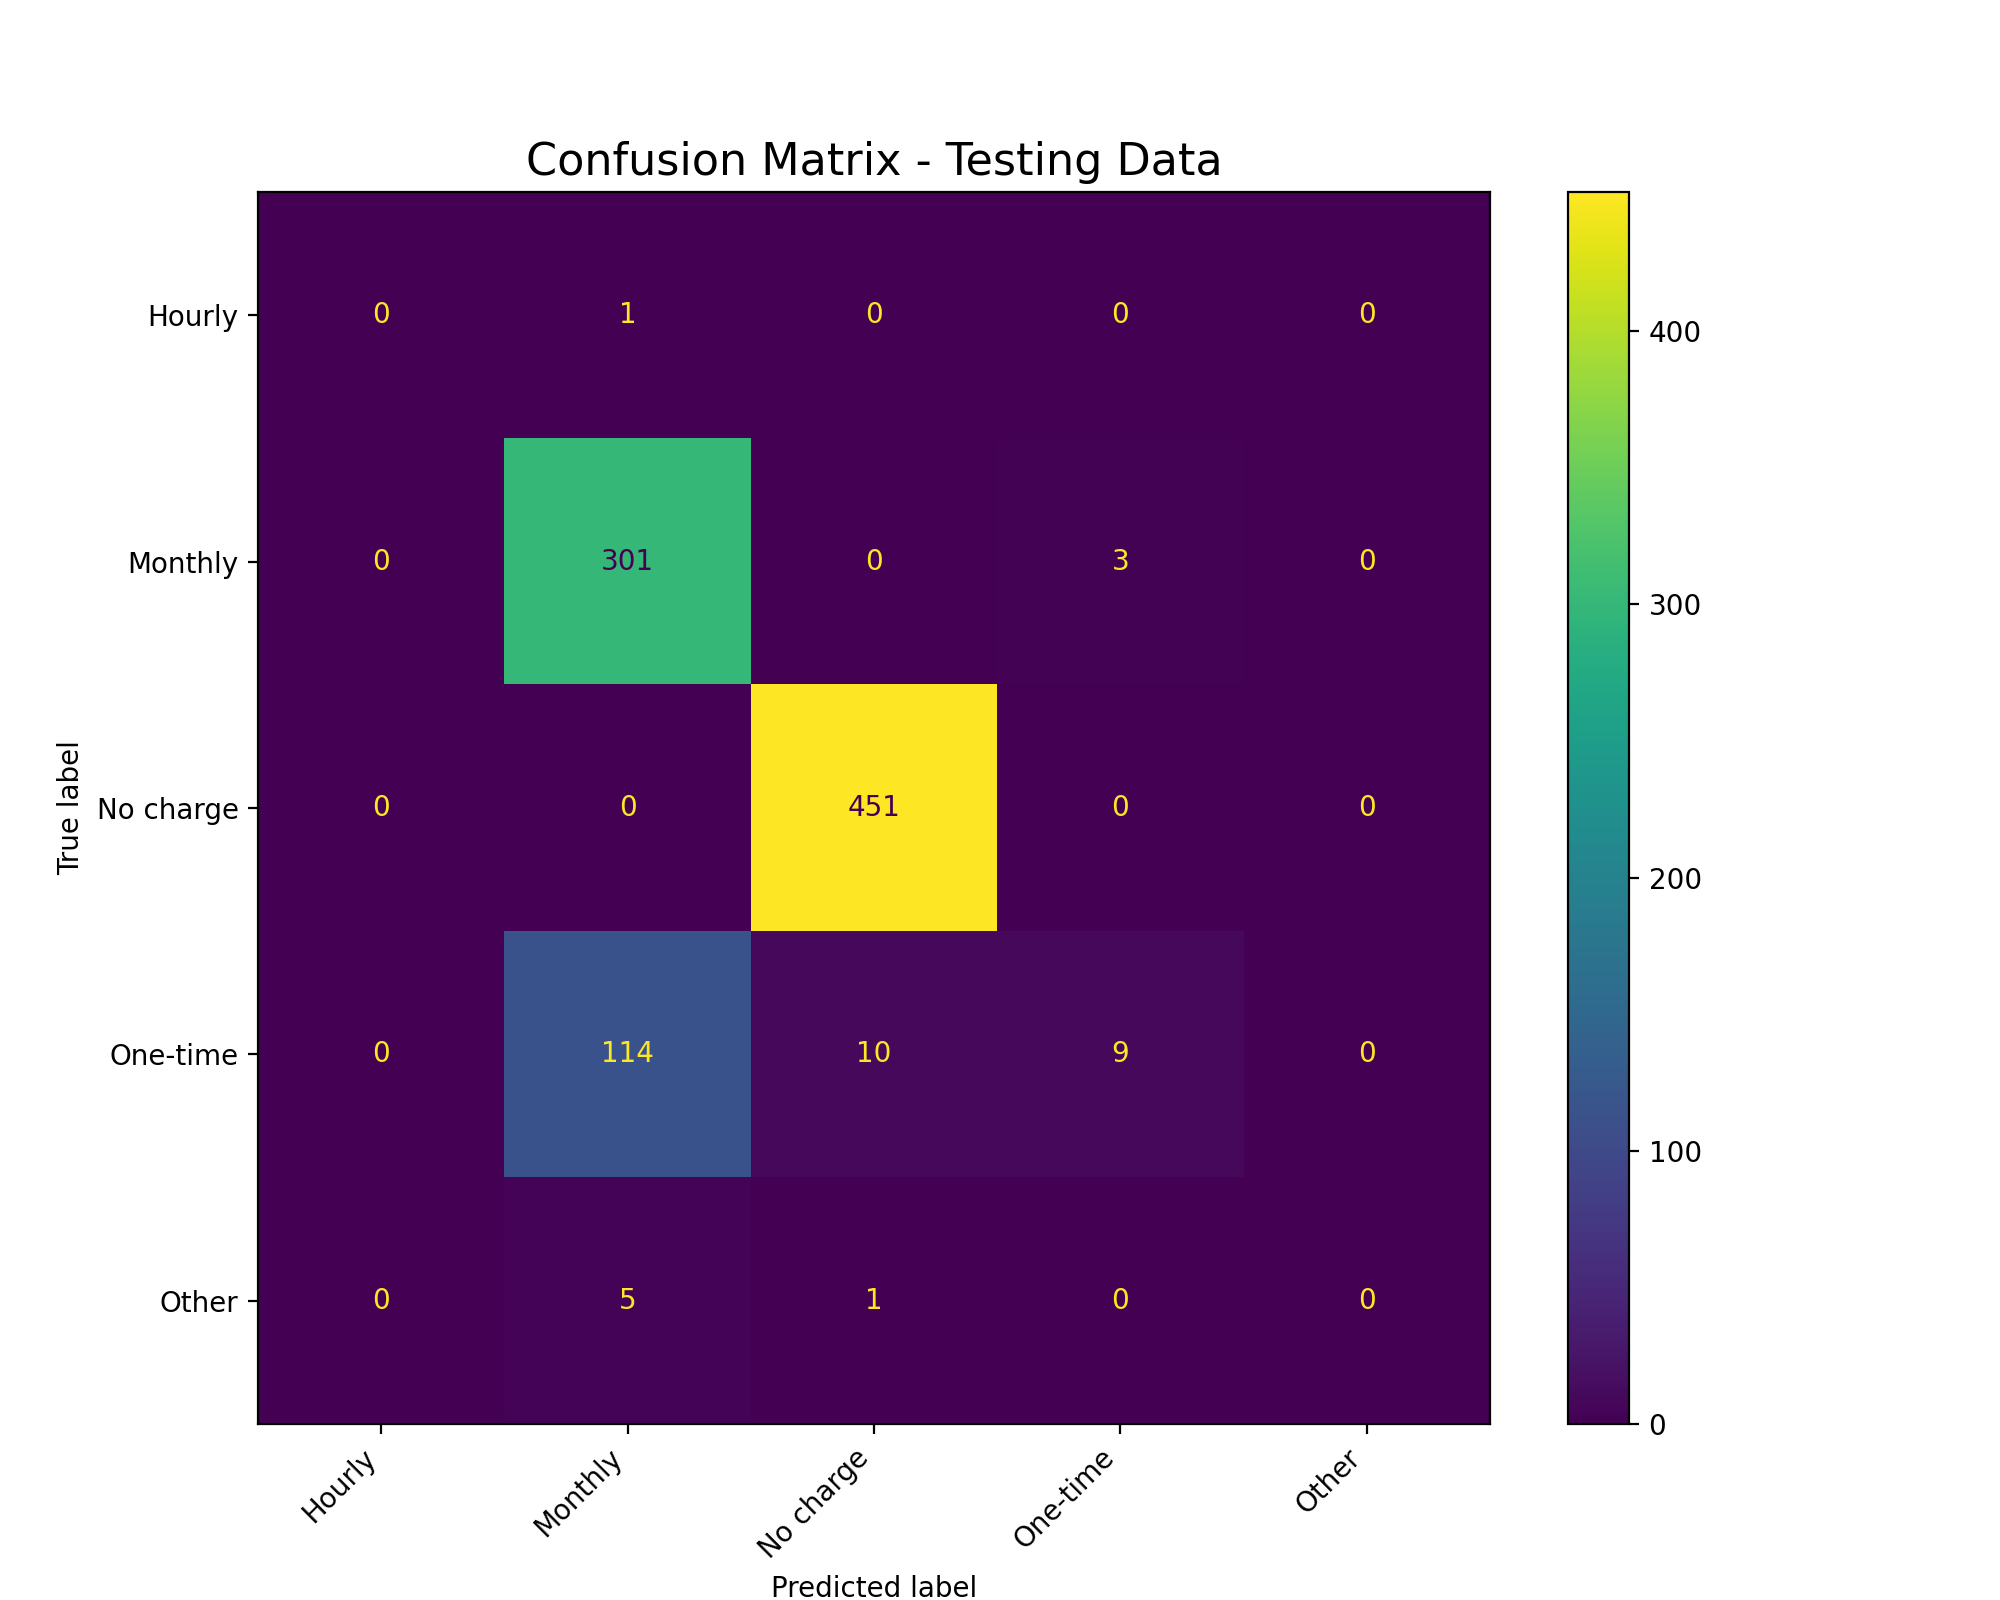

In [ ]:
# Set figure size to adjust height
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Add a title
plt.title("Confusion Matrix - Testing Data", fontsize = 16)

# Create Confusion Matrix Display within a subplot
ax = plt.subplot(111)
disp_train = ConfusionMatrixDisplay.from_estimator(pipe_cat, X_test, y_test, ax=ax)

# Get the current axes and modify the tick labels rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

In [ ]:
# determine the class indices for each class/value
unique_classes = np.unique(y_train)
class_indices = {i: class_name for i, class_name in enumerate(unique_classes)}

print("Class indices and their corresponding names:")
for index, class_name in class_indices.items():
    print(f"Class {index}: {class_name}")


Class indices and their corresponding names:
Class 0: Daily
Class 1: Hourly
Class 2: Minute
Class 3: Monthly
Class 4: No charge
Class 5: One-time
Class 6: Other
Class 7: Weekly
Class 8: Yearly


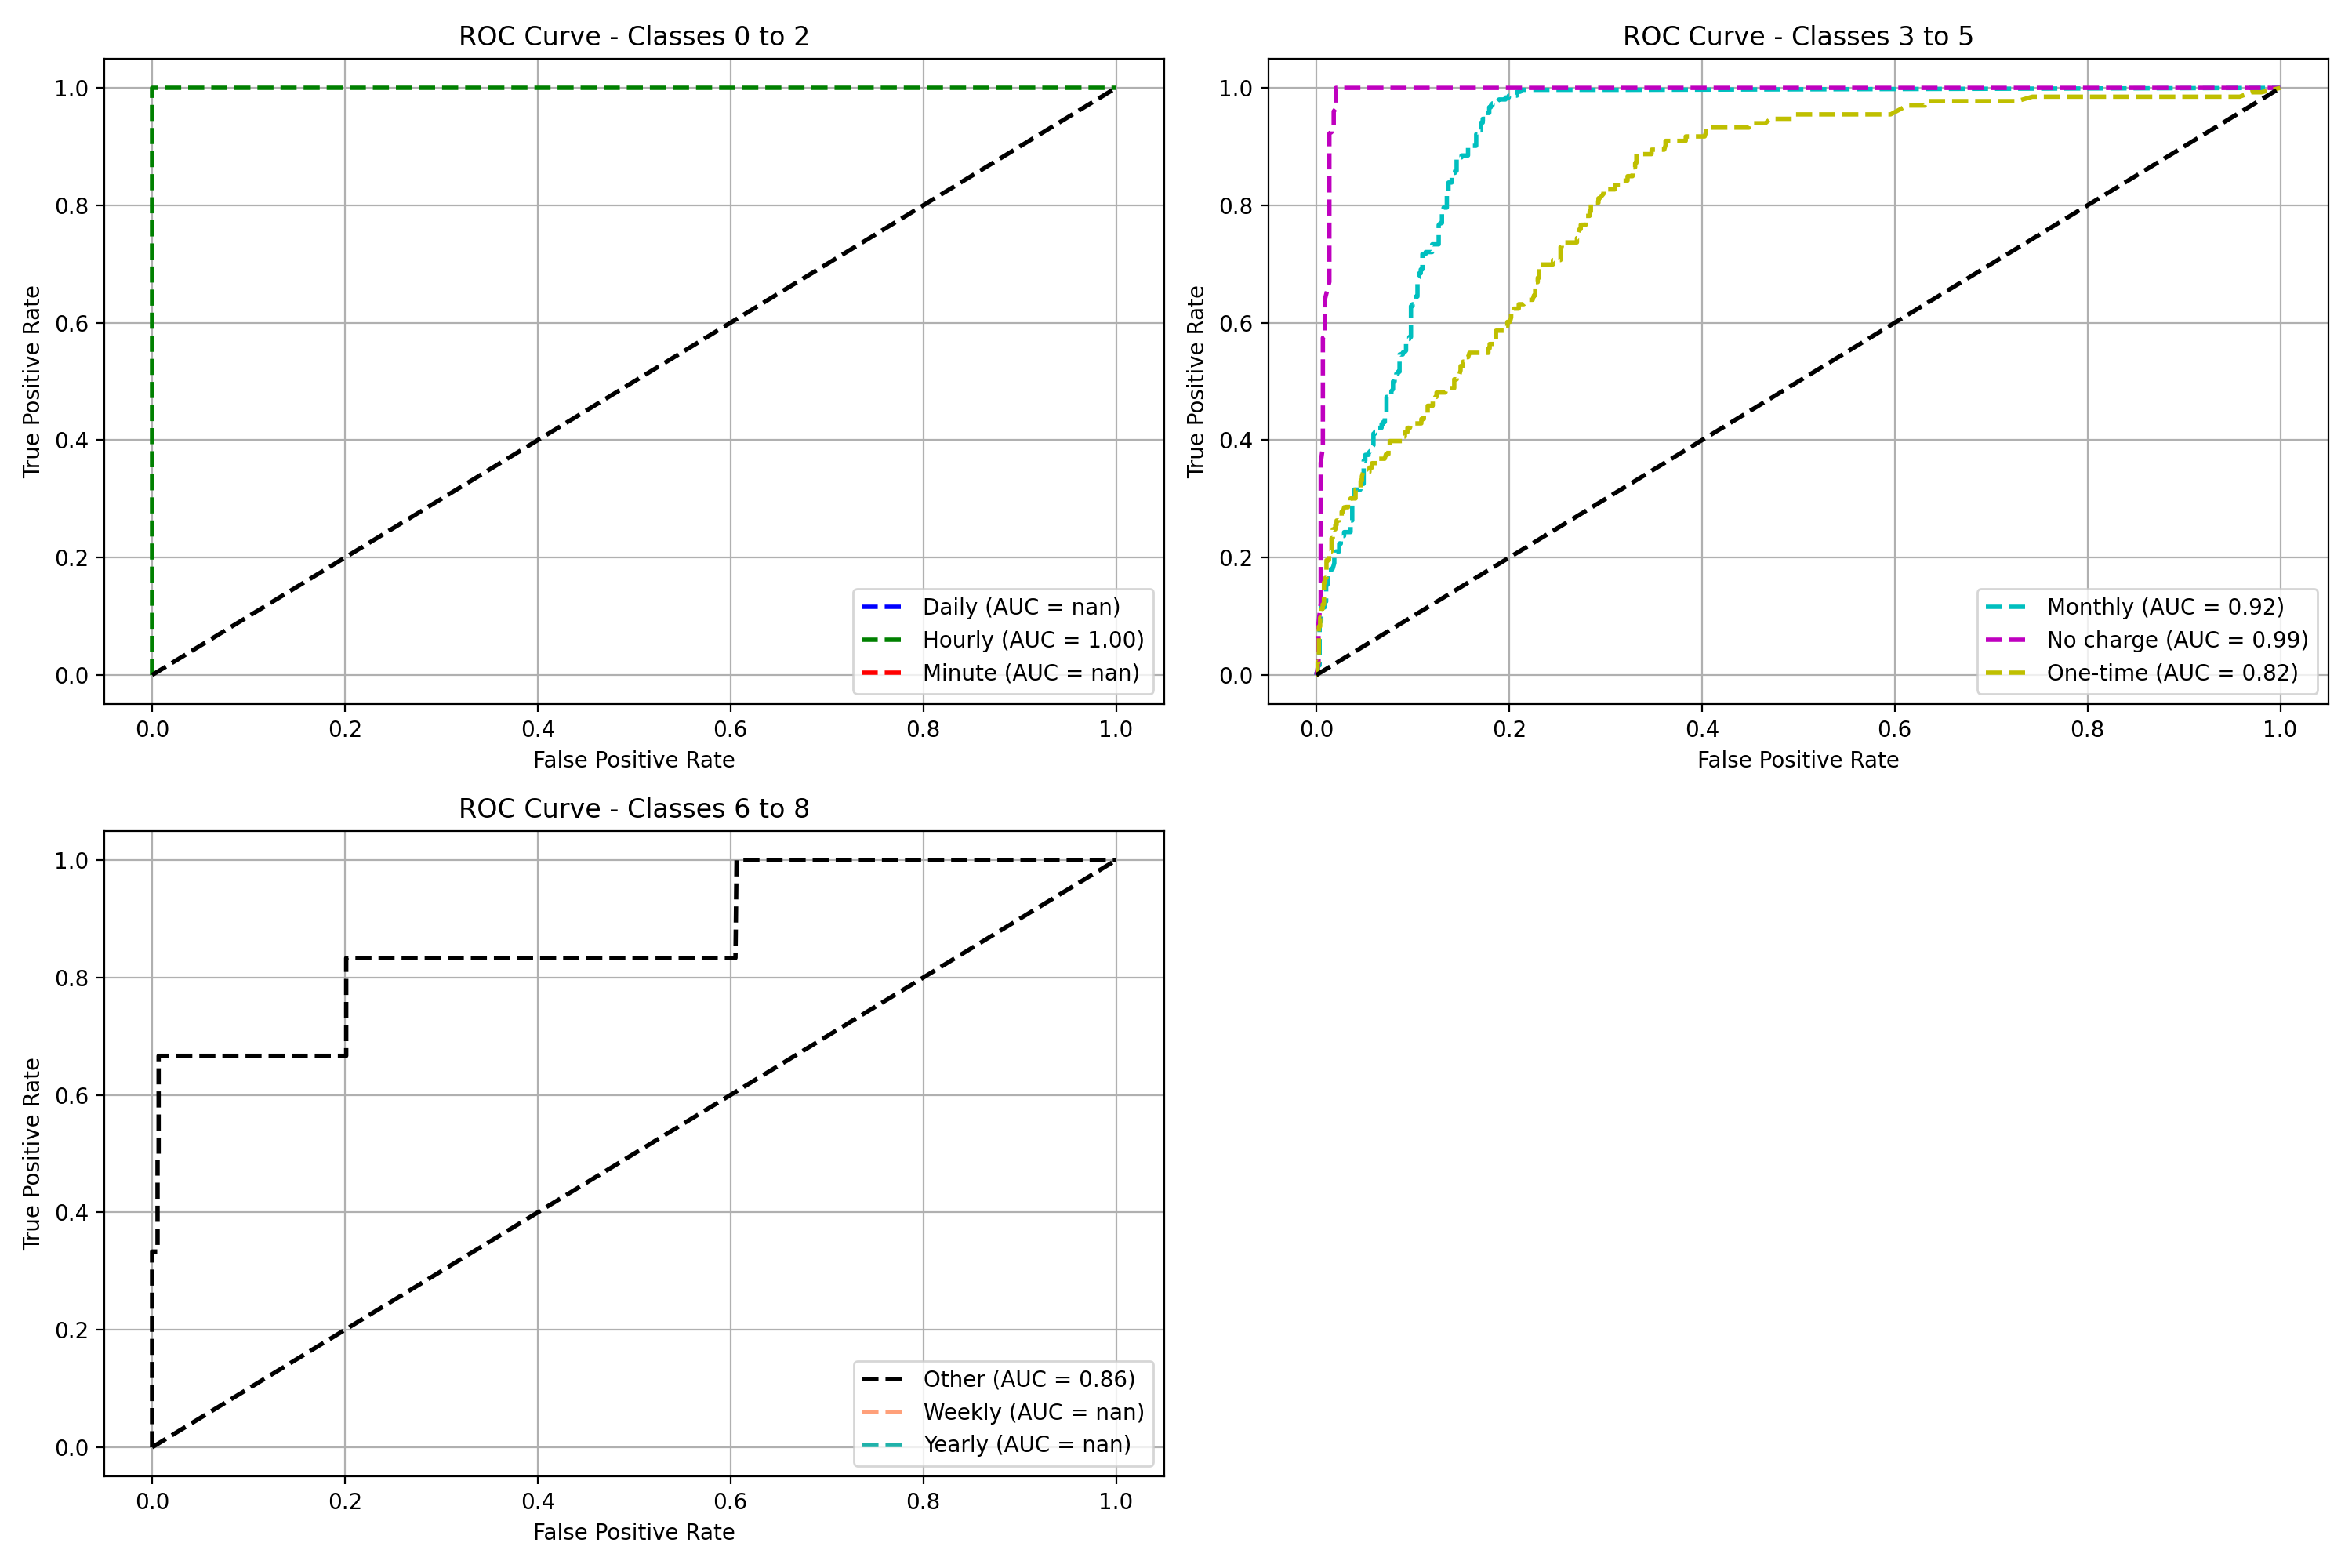

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_bin = label_binarize(y_test, classes=pipe_cat.classes_)

# Create the classifier
classifier = OneVsRestClassifier(pipe_cat)

# Fit the classifier
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(pipe_cat.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = {0: 'Daily', 1: 'Hourly', 2: 'Minute', 3: 'Monthly', 4: 'No charge', 5: 'One-time', 6: 'Other', 7: 'Weekly', 8:'Yearly'}
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA07A', '#20B2AA']

plt.figure(figsize=(15, 10))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA07A', '#20B2AA']

for i in range(0, len(pipe_cat.classes_), 3):
    plt.subplot(2, 2, i // 3 + 1)
    for j in range(3):
        class_index = i + j
        if class_index < len(pipe_cat.classes_):
            plt.plot(fpr[class_index], tpr[class_index], lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc[class_index]:.2f})', color=colors[class_index], linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Classes {i} to {i+2}')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
plt.show()


### **AI (Top Three) Dataset**

Performing a (1) clustering, (2) regression analysis, and (3) classification analysis on an altered dataset that only includes data from AI tools' if its charge frequency is either 'No charge', 'monthly', or 'One-time'

**Variables**
* `Free/Paid/Other`
* `Useable For`
* `Charges`
* `Major Category`
* `charge_amount` (dependent var for the regression analysis)
* `charge_frequency`(dependent var for the classification analysis)

#### **Extracting the Specific Values**

In [ ]:
# extract all of the AI tools who has a 'no charge', 'monthly', or 'one-time' charge frequency
ai_topthree = ai.loc[(ai['charge_frequency'] == 'No charge') | (ai['charge_frequency'] == 'Monthly') |( ai['charge_frequency'] == 'One-time')]

In [ ]:
ai_topthree.columns

Index(['AI Tool Name', 'Description', 'Free/Paid/Other', 'Charges', 'Review',
       'Tool Link', 'Major Category', 'charge_amount', 'charge_frequency',
       'Useable_For_Category'],
      dtype='object')

In [ ]:
ai_topthree.head()

,AI Tool Name,Description,Free/Paid/Other,Charges,Review,Tool Link,Major Category,charge_amount,charge_frequency,Useable_For_Category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other,0.00,No charge,experiments
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text,4.95,Monthly,email assistant
2,Maverick,Send customers personalized videos at scale.,Paid,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio,100.00,Monthly,e-commerce
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image,0.00,No charge,image generator
4,10Web,AI-powered WordPress platform for automated we...,Freemium,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code,0.00,No charge,low-code


#### **Pre-Processing Data (for Clustering and Predicting)**
Dropping missing values, separating features, and inputing missing values, and extracting the text data from the 'Useable For' column

In [ ]:
# dropping any missing values for the variables that will be used to cluster
check_cols = ['AI Tool Name', 'Description', 'Free/Paid/Other', 'Useable_For_Category', 'Major Category']
ai_topthree = ai_topthree.dropna(subset = check_cols).reset_index(drop = True)

# separate categorical, continuous, and text columns
cat = ['Free/Paid/Other', 'Major Category', 'charge_frequency']
text = ['Useable_For_Category']
cont = ['charge_amount']

# imput missing values in the numerical columns (charge amount of 0 = no charge)
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
ai_topthree[cont] = imputer.fit_transform(ai_topthree[cont])

####**Clustering**
Get more context on the different clusters/groups that exist in the AI tool industry

##### **Data Pre-Processing & Principal Component Analysis**

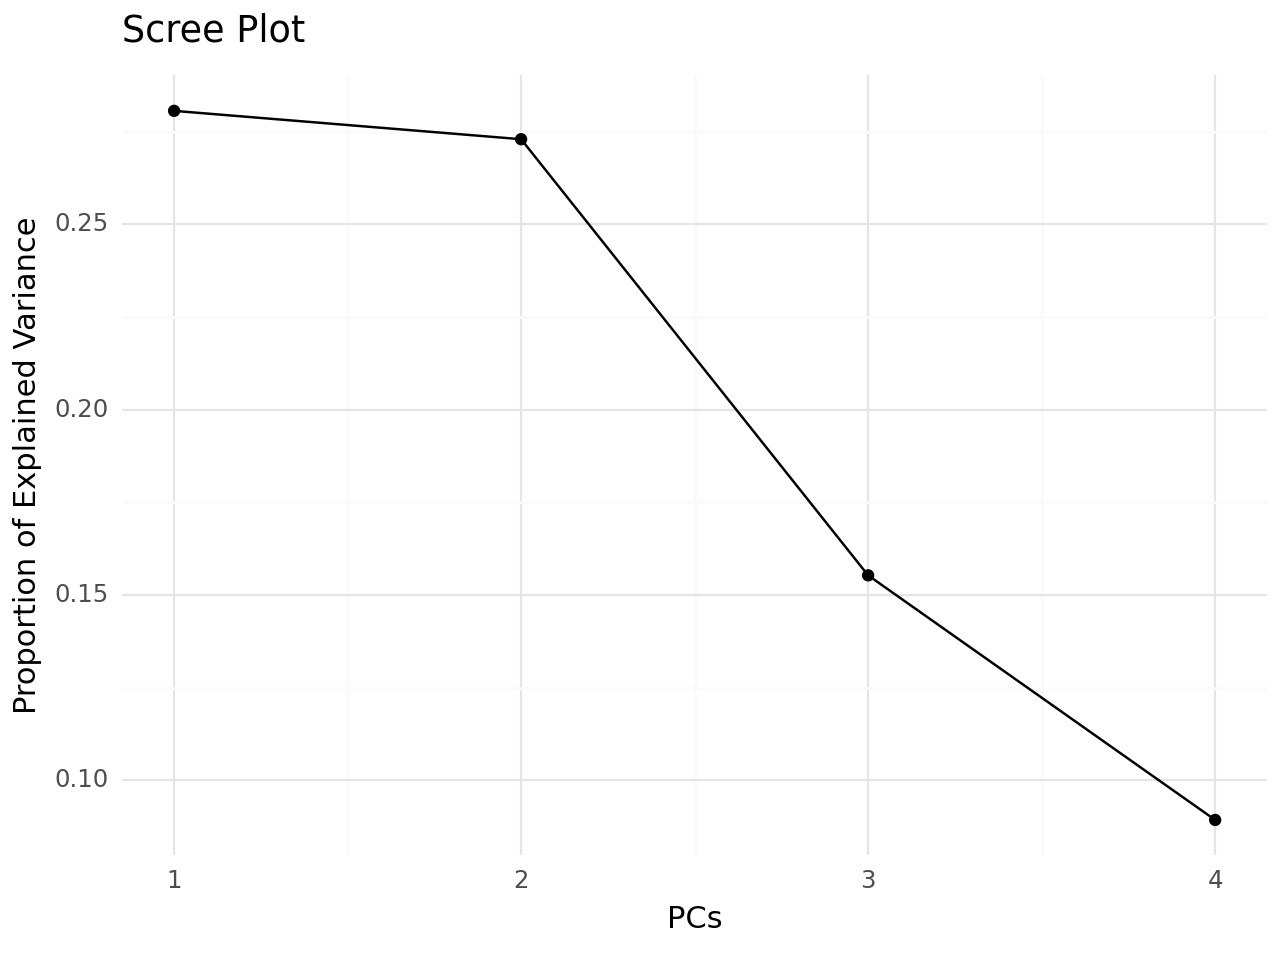

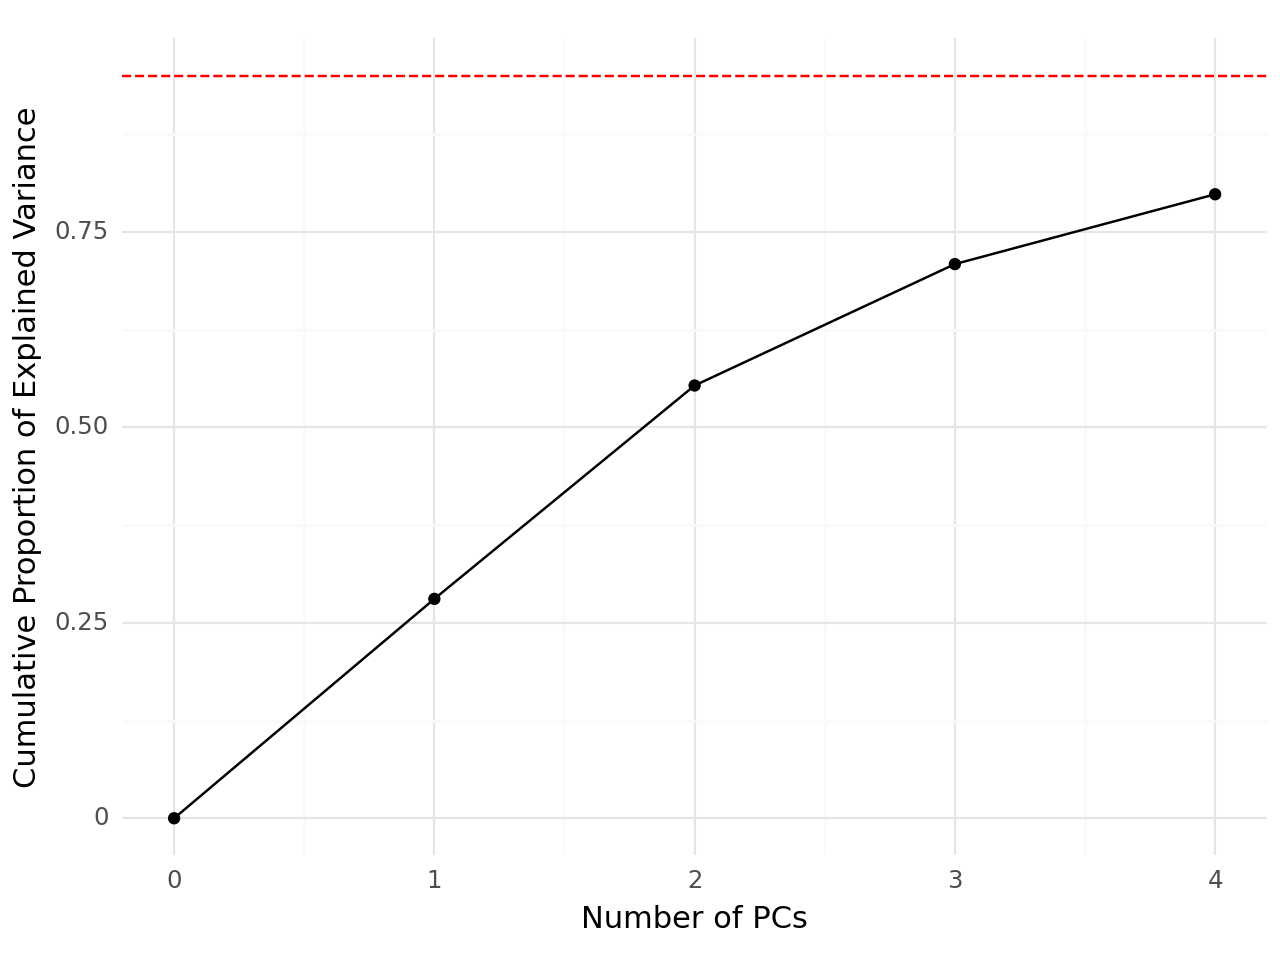

In [ ]:
# SVD
svd = TruncatedSVD(n_components=4)

# One-Hot - 'Free/Paid/Other', 'Major Category'
cat_pipe = Pipeline([('onehot', OneHotEncoder())])

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont),
        ('cat', OneHotEncoder(), cat),
        ('text', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# grab the columns we want to use
feat = [n for n in ai_topthree.columns if n not in ["AI Tool Name", "Description", "Charges", "Review", "Tool Link"]]
X = ai_topthree[feat]

# Include SVD in the pipeline
pipe_svd = Pipeline([
    ("z", z),
    ("svs", svd)
])

# Fit and transform the data using the pipeline
transformed_data = pipe_svd.fit_transform(X)

# scree/cumvar data frame
pcaDF = pd.DataFrame({"expl_var" :
                      pipe_svd.named_steps["svs"].explained_variance_ratio_,
                      "pc": range(1,5),
                      "cum_var":
                      pipe_svd.named_steps["svs"].explained_variance_ratio_.cumsum()})

# scree plot
print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

# cumulative variance data frame
pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})]) # add 0,0 for reference

# cumulative var plot
print(ggplot(pcaDF0, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.95, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance"))

**Scree Plot**: Shows how much of the original features' variance was preserved by each PCs.

**Cumulative Variance Plot** Shows the cumulative variance explained by the first N PCs.

If we plot this with 5 PCs, we can actually see that the plot "elbows" at PC4. After PC4, we can see that the return in variance decreases significantly.

##### **K-Means**

In [ ]:
km = KMeans(n_clusters=5)

# create a pipeline for K-Means
k_pipe = Pipeline([
    ("z", z),
    ("svs", svd),
    ("model", km)
])

# Fit and predict labels
labels = k_pipe.fit_predict(X)

# Calculate Silhouette Score on the transformed data
silhouette = silhouette_score(transformed_data, labels)
print("K-Means - Silhouette Score: ", silhouette)

ai_topthree["clusters"] = labels
ai_topthree[["pc1", "pc2", "pc3", "pc4"]] = pd.DataFrame(pipe_svd.transform(ai_topthree[feat]))

K-Means - Silhouette Score:  0.6522847759129083


##### **Hyperparameter Tuning**
Visualizing the fluctations in the SSE and Silhoette Score given the change in k. This method can assist/guide us towards choosing a k.

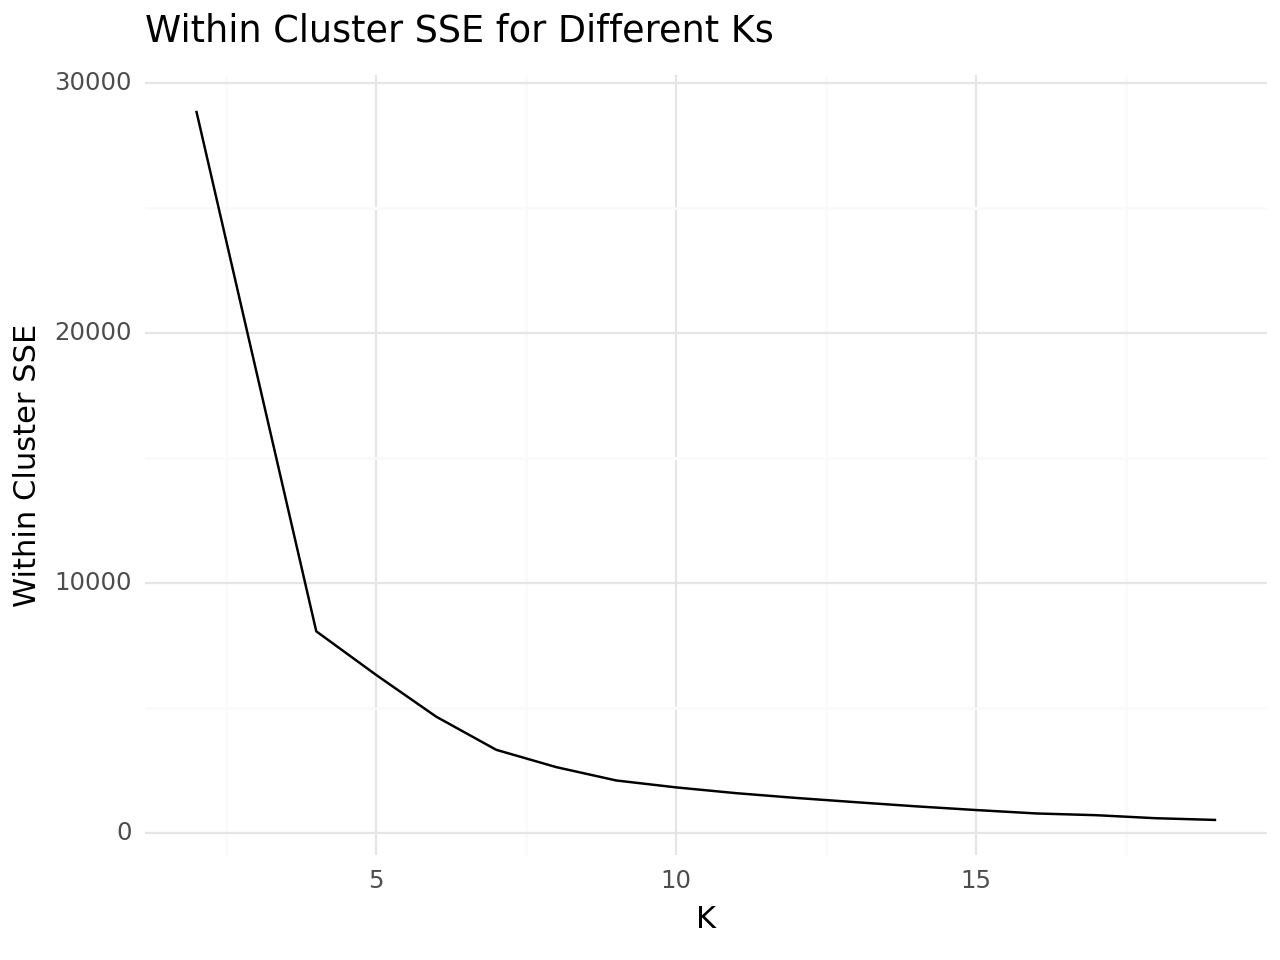

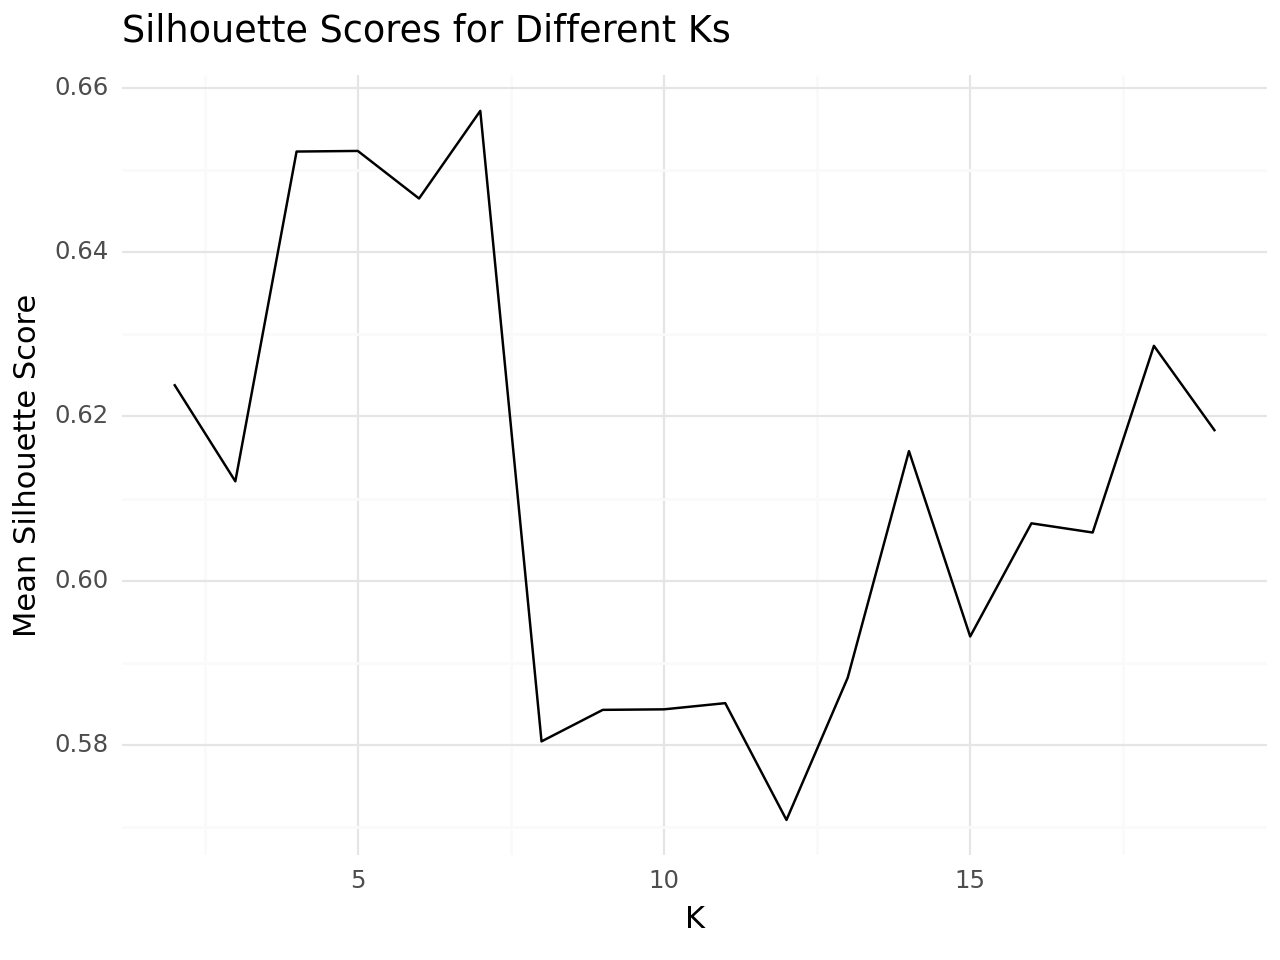

In [ ]:
metrics = {"SSE": [], "sil": [], "k": []}
for i in range(2,20):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z),
        ("svs", svd),
        ("km", km)
    ])

    labels = pipe.fit_predict(X)
    sil = silhouette_score(transformed_data, labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

# SSE Plot
print(ggplot(df, aes(x = "k", y = "SSE")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Within Cluster SSE",
         title = "Within Cluster SSE for Different Ks"))

# Silhouette Plot
print(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

**Within Cluster SSE** We can see that at around ~5-7, the plot begins to "elbow." Similar to the Scree Plot, the reducing in SSE begins to decrease significantly.

**Silhouette Score Plot** We can see how the S score fluctuates depends on the number of clusters that the plot will have. A silhouette score measures how well a clustering model depending on the cohesio (how close the data point in each cluster are to one another) and separation (distance between clusters) of the data points.

##### **Clustering Results**

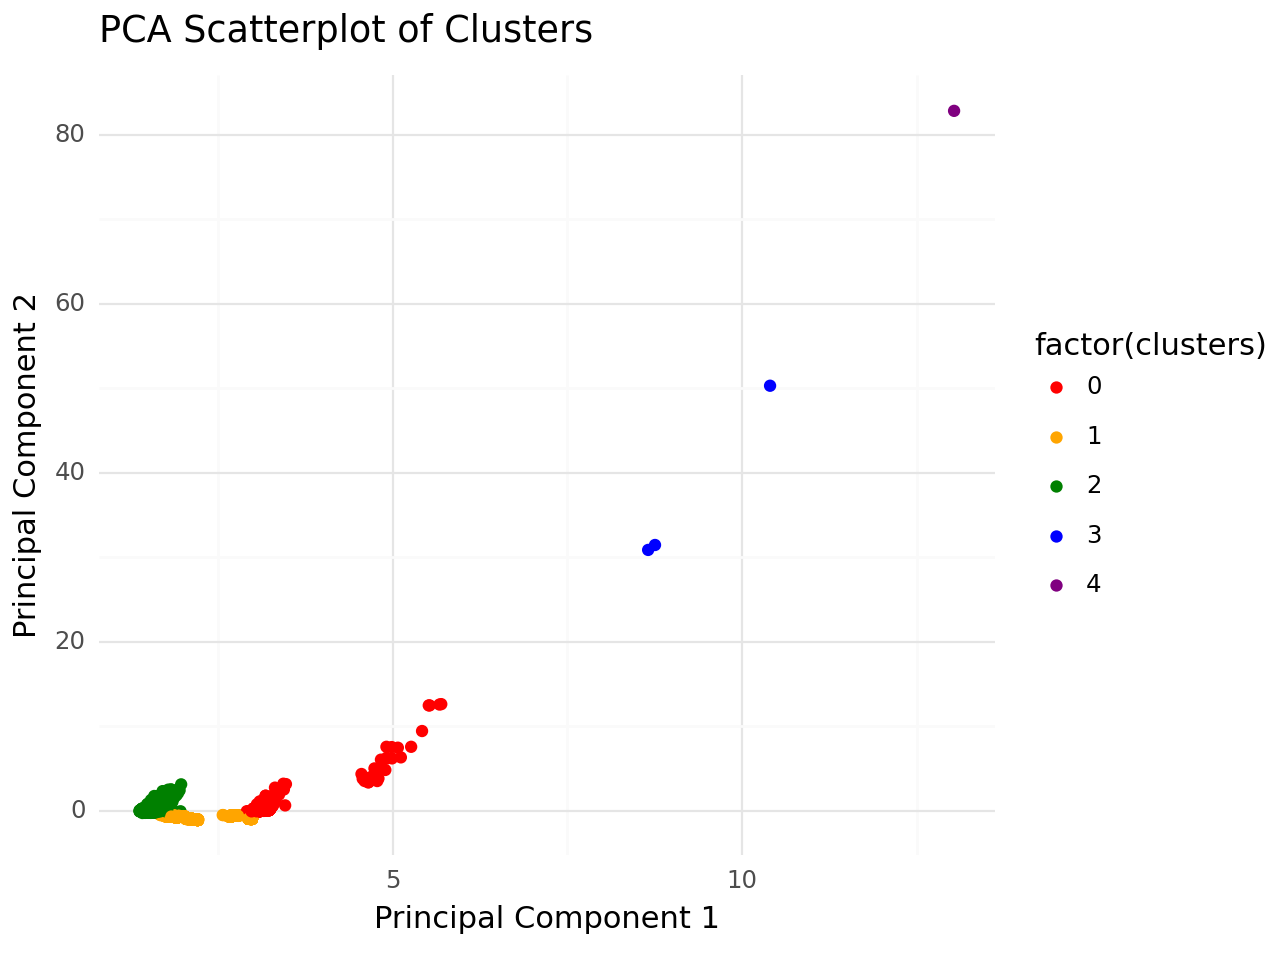

In [ ]:
# Define custom colors for clusters
cluster_colors = {0: 'red', 1: 'orange', 2: 'green', 3: 'blue', 4: 'purple'}

# Create the PCA Scatterplot with custom colors
scatter_plot = (
    ggplot(ai_topthree, aes(x='pc1', y='pc2', color='factor(clusters)')) +
    geom_point() +
    scale_color_manual(values=[cluster_colors[i] for i in range(5)]) +  # Use custom colors
    theme_minimal() +
    labs(title='PCA Scatterplot of Clusters', x='Principal Component 1', y='Principal Component 2')
)

# Show the plot
print(scatter_plot)

**PCA Scatterplot of Clusters** Through this plot, we can see how our clustering model performed with the "AI Top Three" dataset. We can see that clusters 3 and 4's values are more outlier like compared to the other three clusters.

**Cluster Plot #1**
This Histogram Plot aims to see the "Charge Amount" value distributions amongst each cluster. What's the mean "Charge Amount" for each cluster? Based on the results, we can actually see that the majority of "Cluster 1" AI tools doesn't charge consumers to use their tools. We can actually see that cost distribution shows that companies typically charge their tools in range 1 (cheap: free to 100) or range 2 (expensive: $3k+)

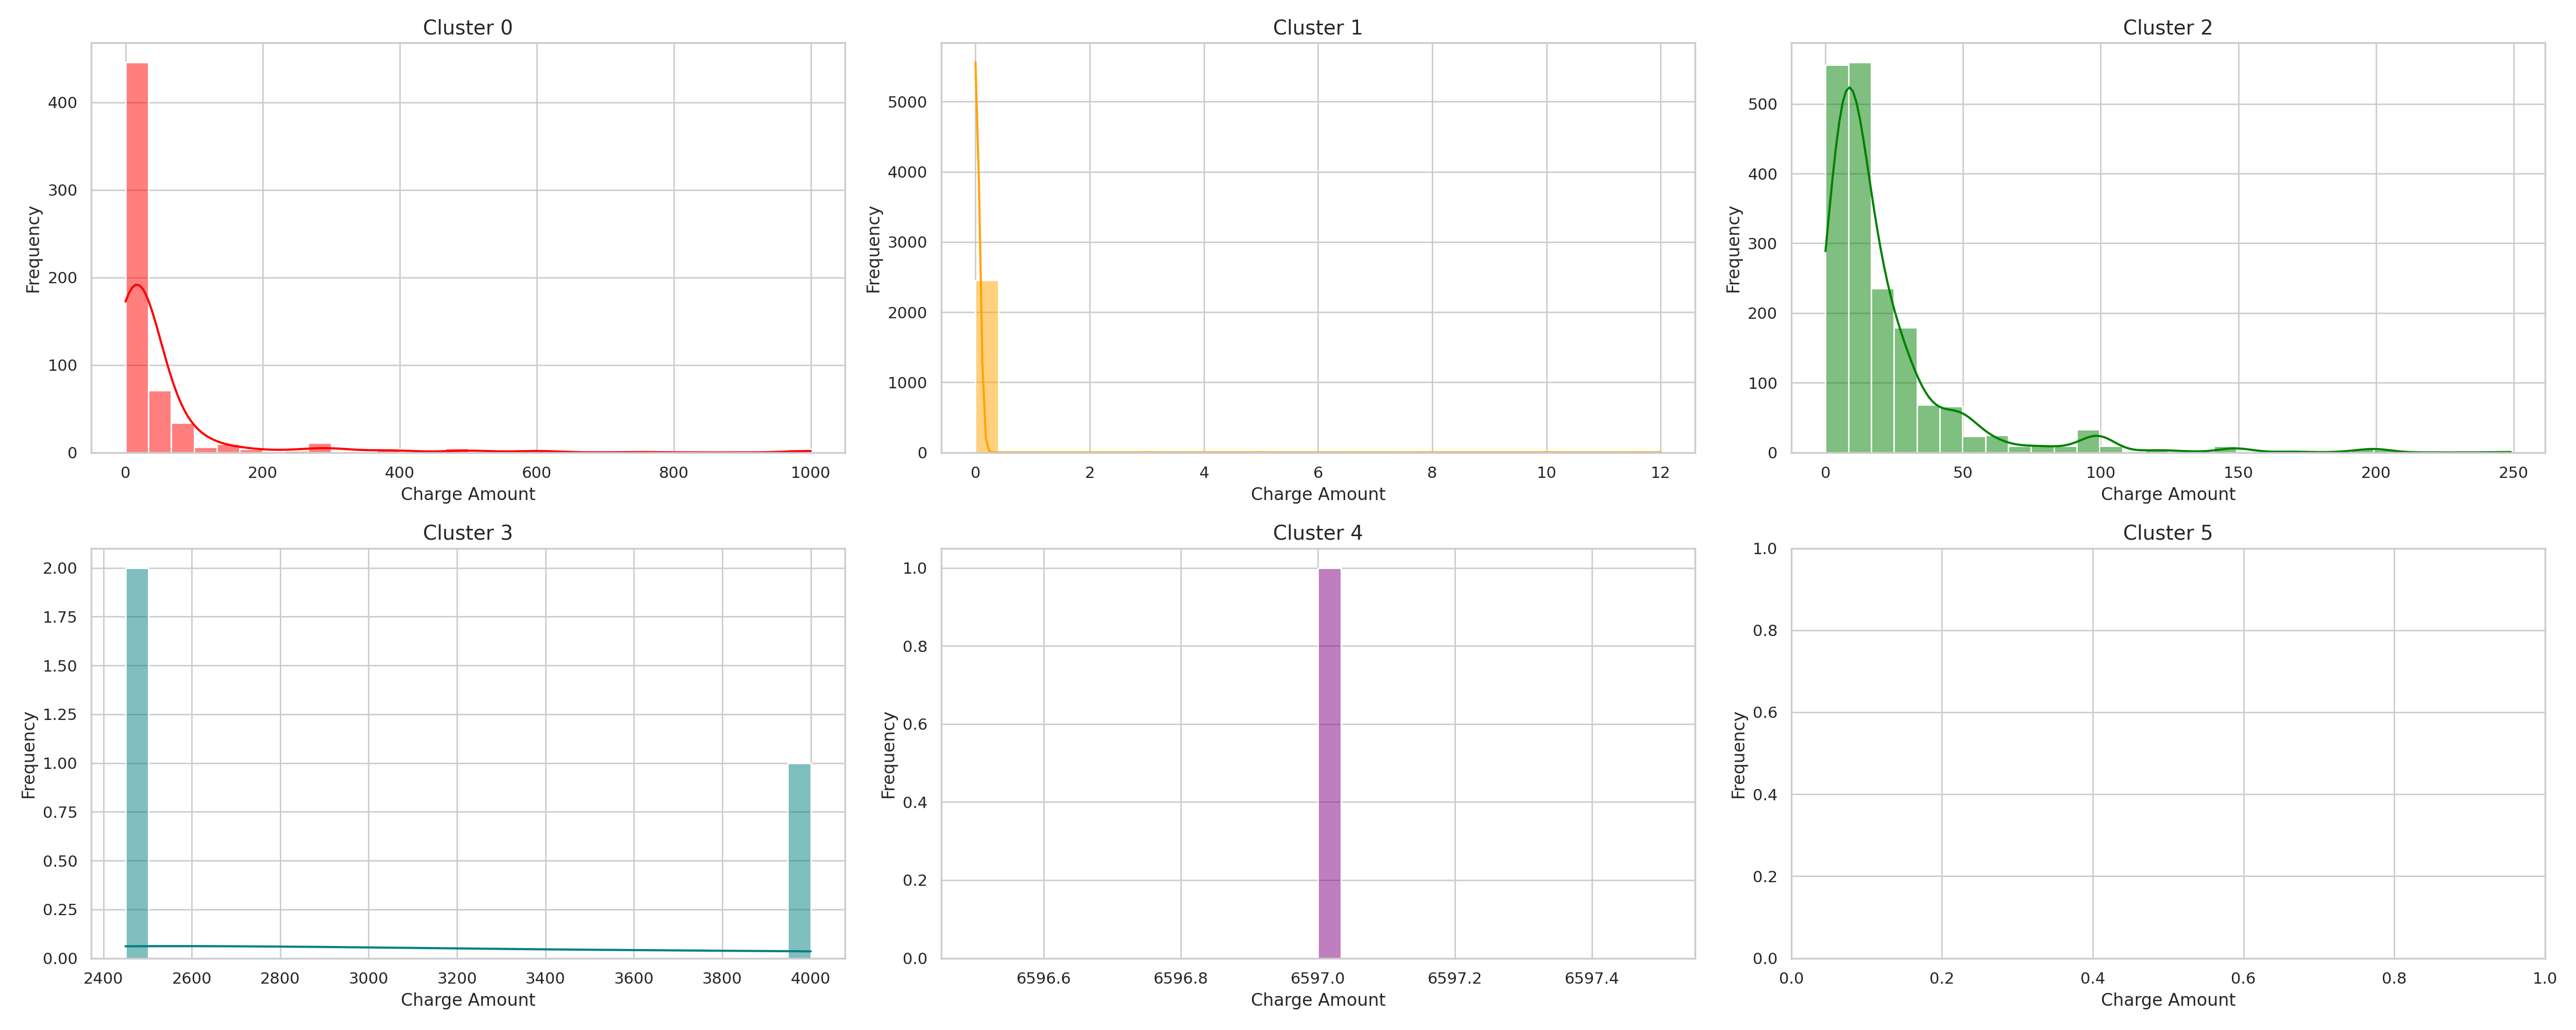

In [ ]:
# Define a color palette for each cluster
cluster_palette = ['red', 'orange', 'green', 'teal', 'purple', 'purple', 'magenta']

# Set the number of rows and columns
rows = 2
cols = 3

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

# Iterate through clusters and plot histograms with custom colors
for i, ax in enumerate(axes.flat):
    selected_cluster_data = ai_topthree[ai_topthree['clusters'] == i]
    sns.histplot(selected_cluster_data['charge_amount'], kde=True, bins=30, ax=ax, color=cluster_palette[i])
    ax.set_title(f'Cluster {i}', fontsize=14)
    ax.set_xlabel('Charge Amount', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Add space between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Cluster Plot #2**

Through these plots we can see the "Charge Frequency" that is most common within each cluster.

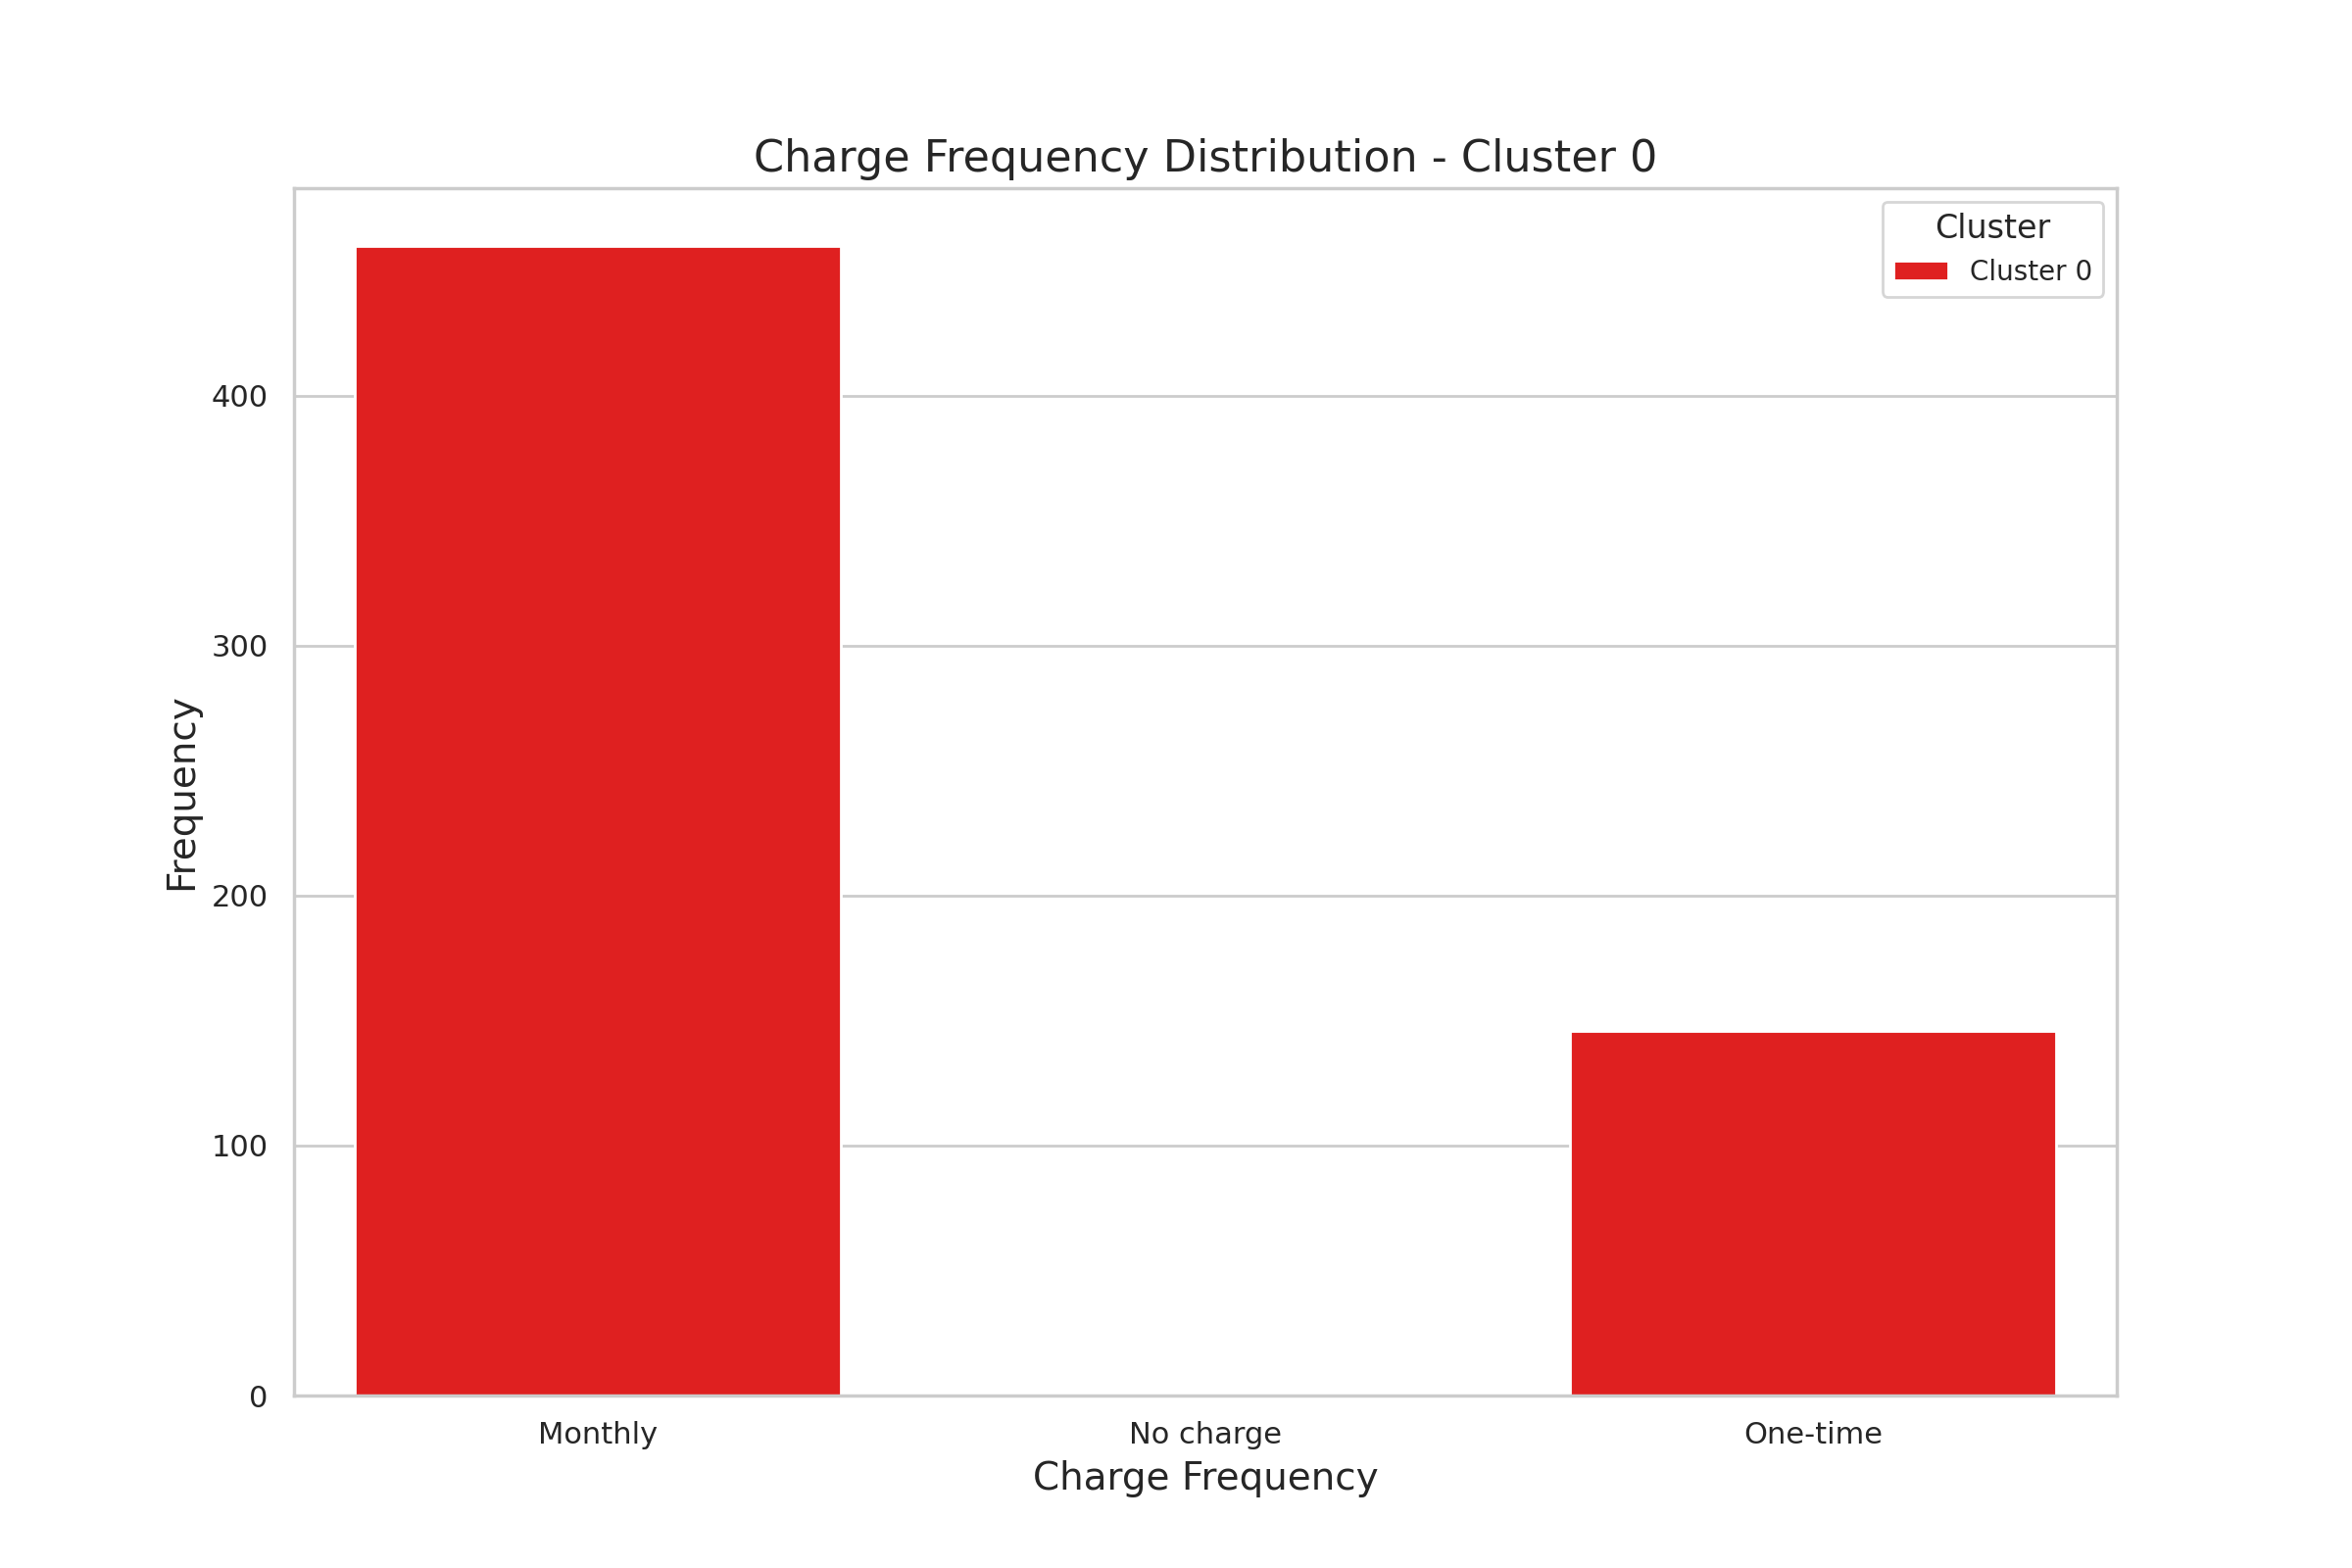

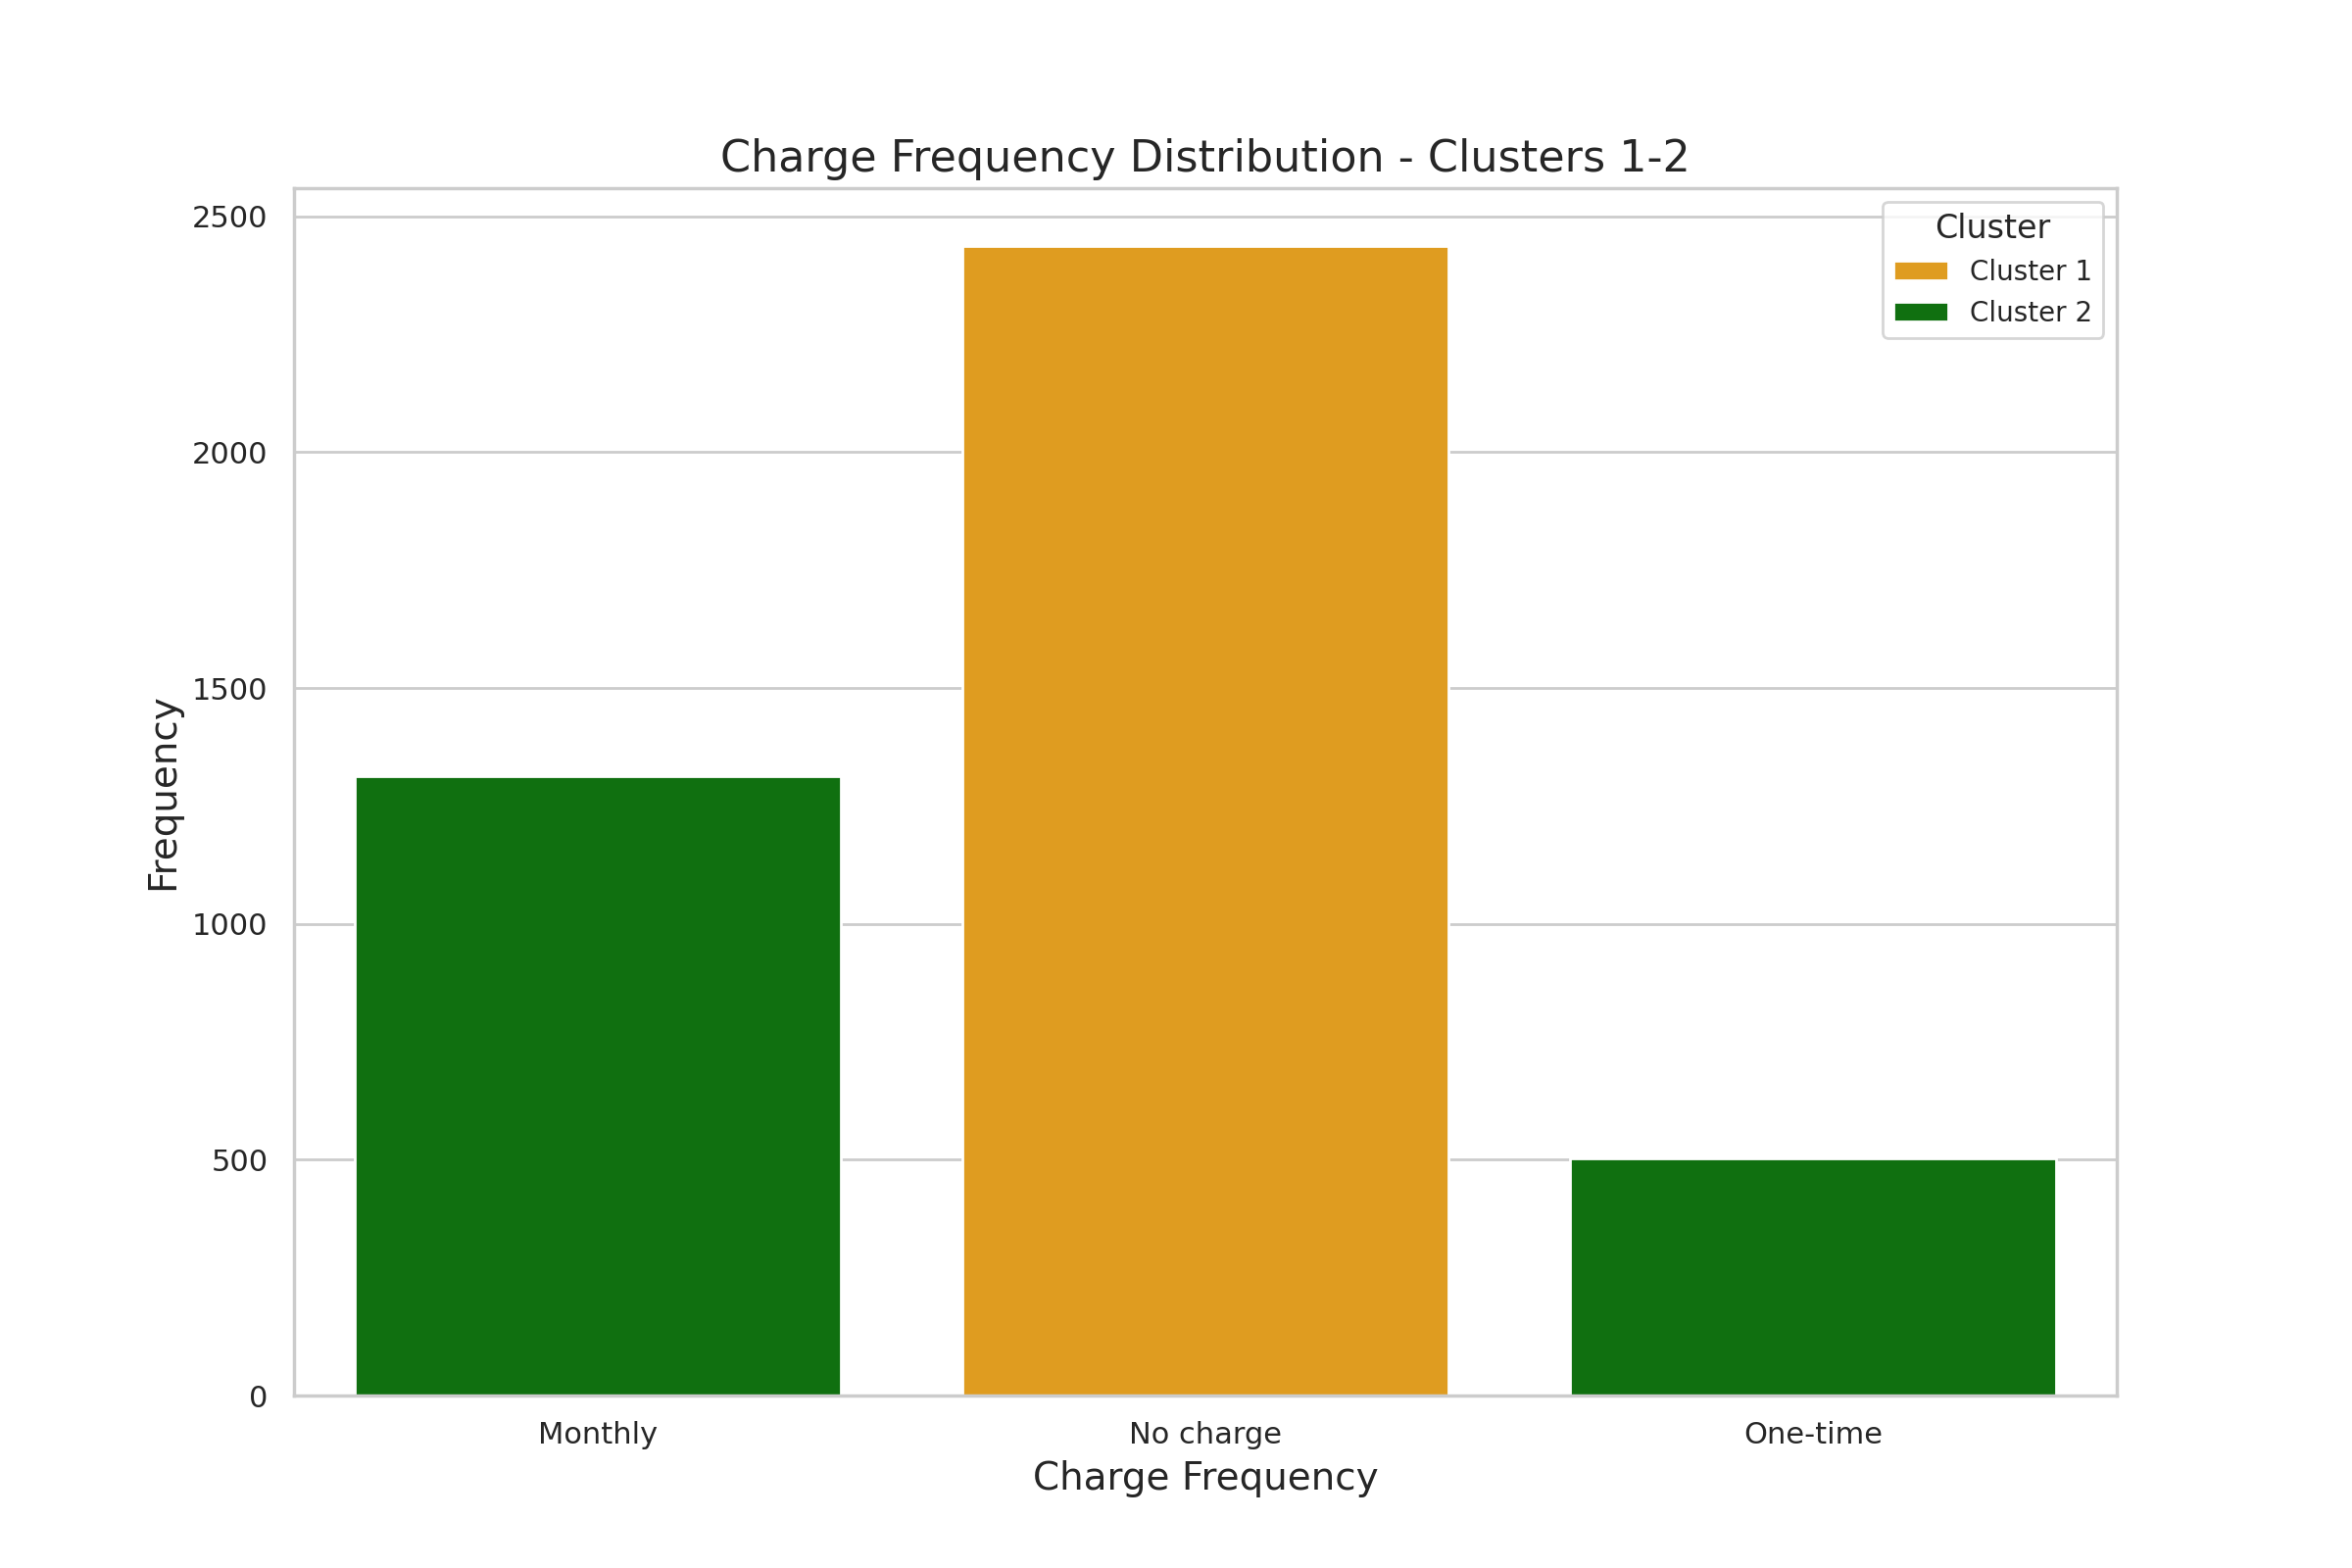

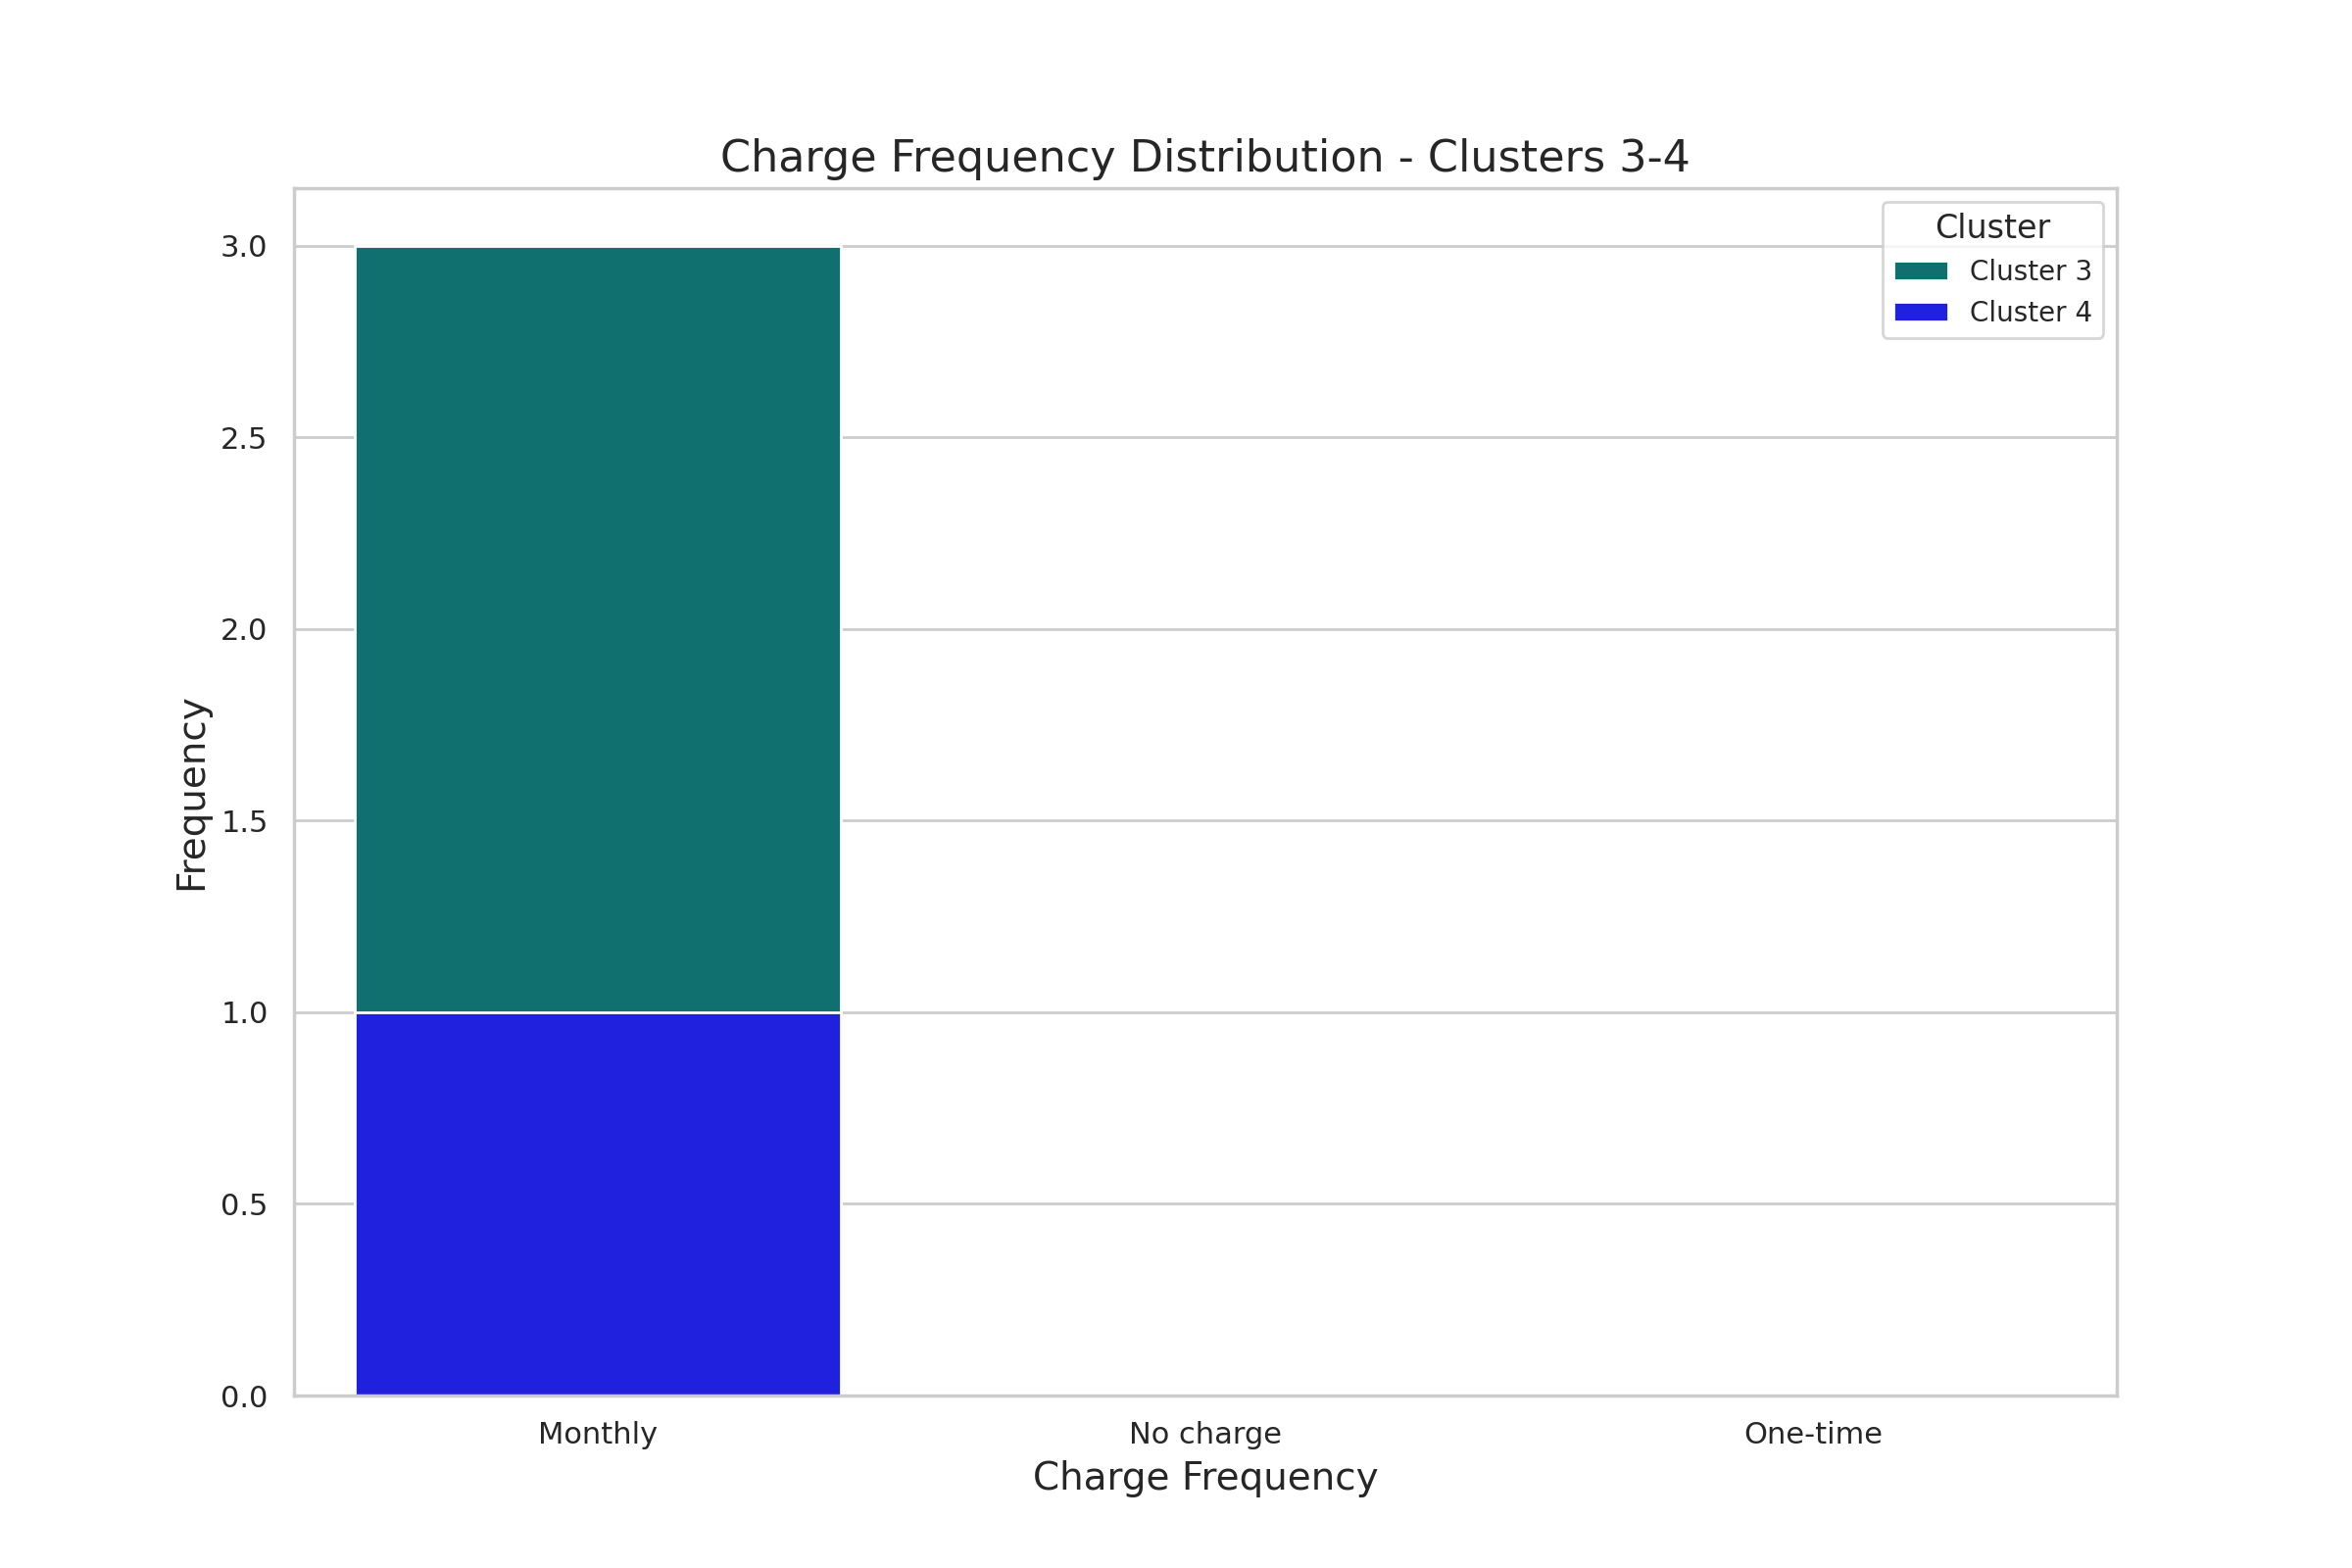

In [ ]:
# Define the charge frequencies of interest
charge_frequencies = ['Monthly', 'No charge', 'One-time']

# Define custom colors for clusters
cluster_palette = {0: 'red', 1: 'orange', 2: 'green', 3: 'teal', 4: 'blue', 5: 'purple', 6: 'magenta'}

# Create a bar plot for charge frequency distribution across the selected clusters
plt.figure(figsize=(12, 8))
# Iterate through clusters in the selected range and plot histograms with custom colors
selected_cluster_data = ai_topthree[ai_topthree['clusters'] == 0]

# Count the frequency of each charge frequency in the selected cluster
charge_frequency_counts = selected_cluster_data['charge_frequency'].value_counts().reindex(charge_frequencies, fill_value=0)

# Plot a bar plot for charge frequency distribution in each cluster
sns.barplot(x=charge_frequency_counts.index, y=charge_frequency_counts.values, label=f'Cluster {0}', palette=[cluster_palette[0]])

# Add labels and legend
plt.title(f'Charge Frequency Distribution - Cluster 0', fontsize=16)
plt.xlabel('Charge Frequency', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Cluster', title_fontsize='12', fontsize='10')

# Create separate histograms for clusters 0, 1, 2, 3 and clusters 4, 5, 6
for cluster_range in [(1, 2), (3, 4)]:
    # Create a bar plot for charge frequency distribution across the selected clusters
    plt.figure(figsize=(12, 8))

    # Iterate through clusters in the selected range and plot histograms with custom colors
    for i in cluster_range:
        selected_cluster_data = ai_topthree[ai_topthree['clusters'] == i]

        # Count the frequency of each charge frequency in the selected cluster
        charge_frequency_counts = selected_cluster_data['charge_frequency'].value_counts().reindex(charge_frequencies, fill_value=0)

        # Plot a bar plot for charge frequency distribution in each cluster
        sns.barplot(x=charge_frequency_counts.index, y=charge_frequency_counts.values, label=f'Cluster {i}', palette=[cluster_palette[i]])

    # Add labels and legend
    plt.title(f'Charge Frequency Distribution - Clusters {cluster_range[0]}-{cluster_range[-1]}', fontsize=16)
    plt.xlabel('Charge Frequency', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(title='Cluster', title_fontsize='12', fontsize='10')

    # Show the plot
    plt.show()

**Cluster Plot #3**

Through this plot, we can see the "hot topics" amongst each cluster.

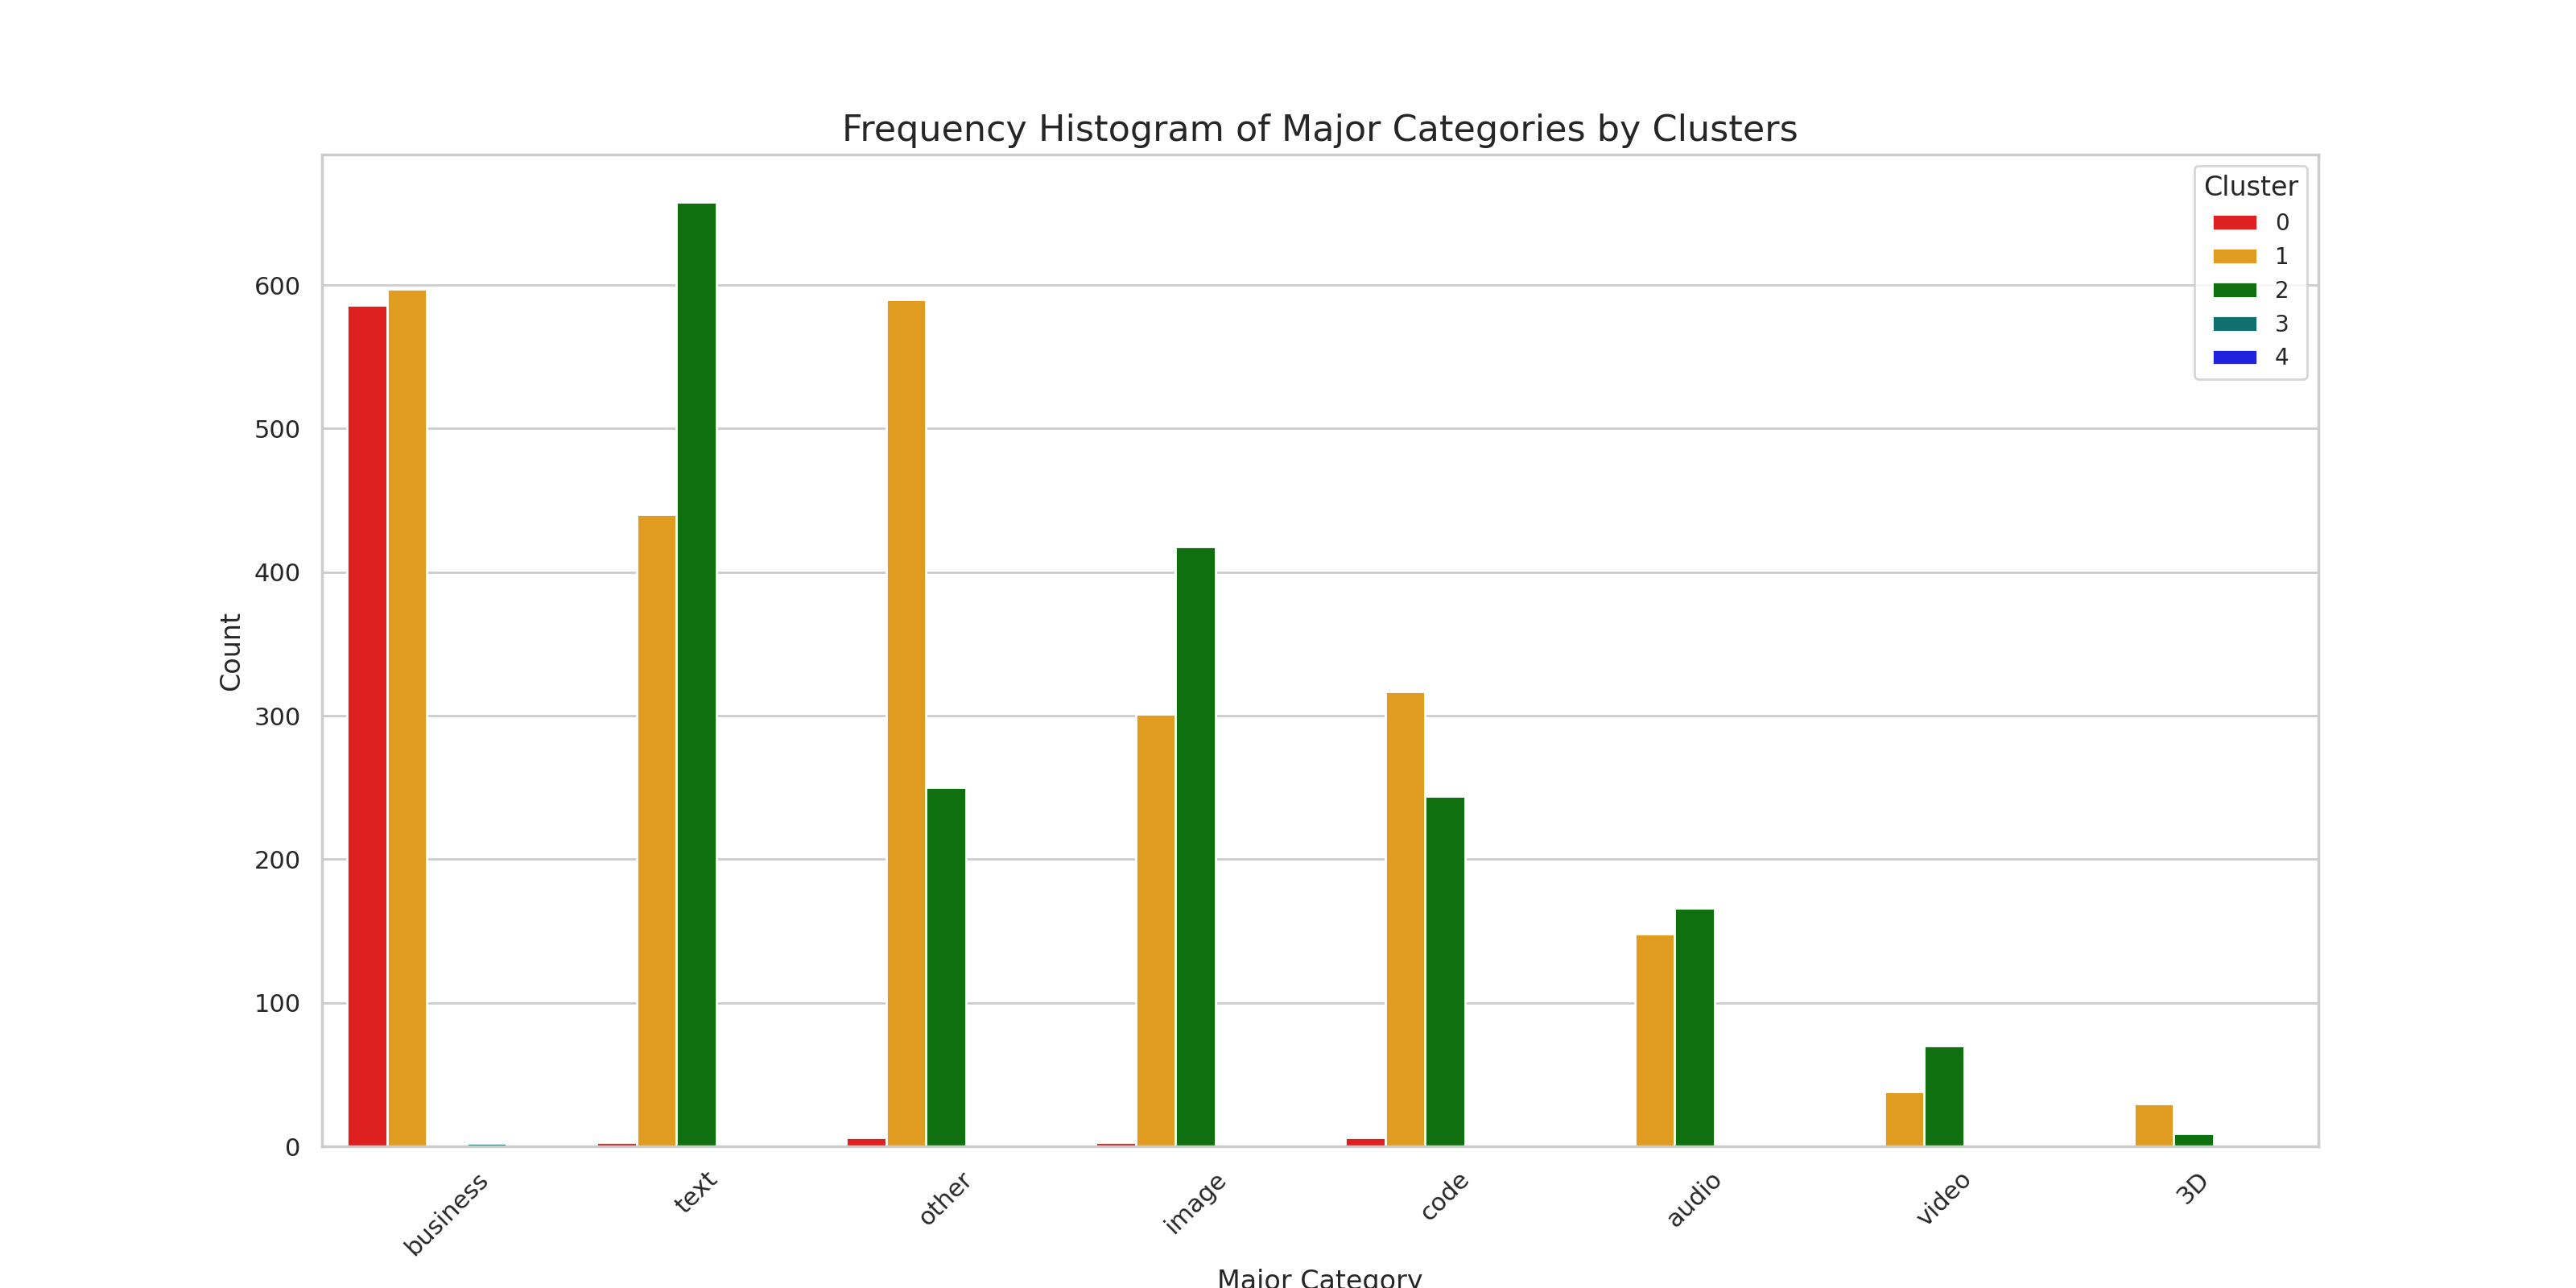

In [ ]:
major_category_counts = ai_topthree['Major Category'].value_counts()

# Sort Major Category values based on their counts in descending order
sorted_major_categories = major_category_counts.index

plt.figure(figsize=(16, 8))
sns.countplot(x='Major Category', data=ai_topthree, order=sorted_major_categories, hue='clusters', palette=cluster_palette)
plt.title('Frequency Histogram of Major Categories by Clusters', fontsize=16)
plt.xlabel('Major Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cluster', title_fontsize='12', fontsize='10')
plt.show()


####**Predictive Model**: Charge Amount
How much should a company charge for their product?

##### **Data Pre-Processing & Random Forest Regressor Model**

In [ ]:
# Split the Independent and Dependent Variables
predictors = ['Free/Paid/Other', 'Major Category', 'Useable_For_Category', 'charge_frequency']
category = ['Free/Paid/Other', 'Major Category', 'charge_frequency']
text_var = ['Useable_For_Category']

X = ai_topthree[predictors]
y = ai_topthree['charge_amount']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 1234)

# One-Hot - 'Free/Paid/Other', 'Major Category'
cat_pipe = Pipeline([('onehot', OneHotEncoder())])

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore'), category),
        ('text_var', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# Random Forest Regressor Model - Empty Model
rf = RandomForestRegressor(n_estimators = 50, max_depth = 5, random_state = 84)

# Create Pipeline
pipe = Pipeline([
    ("z", z),
    ("tree", rf)
])

##### **Hyperparameter Tuning**
---

*  Random Search CV - Random Forest Regressor

*   Recommend the number of estimators to use, max depth of tree, and the random state





In [ ]:
# Random Search CV
param_dist = {
    'tree__n_estimators': [25, 50, 100, 150],
    'tree__max_depth': [None, 5, 10, 15],
    'tree__random_state': [42, 84, 123]

}

# use grid search to find best parameters
grid = RandomizedSearchCV(pipe, param_distributions=param_dist, cv = 5, refit = True)

grid.fit(X_train, y_train)

print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__n_estimators"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__max_depth"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__random_state"])


RandomizedSearchCV chose:  50
RandomizedSearchCV chose:  5
RandomizedSearchCV chose:  84


##### **Model Validation**
----
K-Fold

In [ ]:
# model validation
kf = KFold(5)

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}
mape = {"train": [], "test": []}
r2 = {"train": [], "test": []}

# Loop Over Folds
for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

    mape["train"].append(mean_absolute_percentage_error(y_train,y_pred_train))
    mape["test"].append(mean_absolute_percentage_error(y_test,y_pred_test))

    r2["train"].append(r2_score(y_train,y_pred_train))
    r2["test"].append(r2_score(y_test,y_pred_test))


# Print out the Performance Evaluations
print("Train MSEs:", mse["train"])
print("Test MSEs :", mse["test"])
print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))

print("Train MAEs:", mae["train"])
print("Test MAEs :", mae["test"])
print("Train MAE :", np.mean(mae["train"]))
print("Test MAE  :", np.mean(mae["test"]))

print("Train MAPEs:", mape["train"])
print("Test MAPEs :", mape["test"])
print("Train MAPE :", np.mean(mape["train"]))
print("Test MAPE  :", np.mean(mape["test"]))

print("Train R2s:", r2["train"])
print("Test R2s :", r2["test"])
print("Train R2 :", np.mean(r2["train"]))
print("Test R2  :", np.mean(r2["test"]))

Train MSEs: [17589.051243342394, 14295.084617298735, 7082.744614930352, 18922.598721847924, 18514.009435841184]
Test MSEs : [7793.712074466677, 24335.780906758682, 53031.82549005653, 2356.3543461106456, 3773.6954978602685]
Train MSE : 15280.697726652119
Test MSE  : 18258.27366305056
Train MAEs: [19.870194575000404, 17.320554784411517, 15.269328127642073, 19.38836841417954, 19.21444914418397]
Test MAEs : [16.36492249600877, 24.729575589193814, 24.390039519497034, 16.10705989181706, 15.697880068209788]
Train MAE : 18.212579009083502
Test MAE  : 19.457895512945292
Train MAPEs: [766778764924908.9, 828553585996284.1, 825066109505521.1, 865971060653753.4, 843662168533985.4]
Test MAPEs : [1289472071168793.2, 1096613721899626.1, 610711870332882.6, 950870693914214.4, 431496923512611.1]
Train MAPE : 826006337922890.6
Test MAPE  : 875833056165625.5
Train R2s: [0.09490074570791773, 0.12914404310611272, 0.09785320635995798, 0.08716147808646124, 0.08824934466443957]
Test R2s : [-0.11402289645684549,

Text(0.5, 0, 'Permutation Feature Importance')

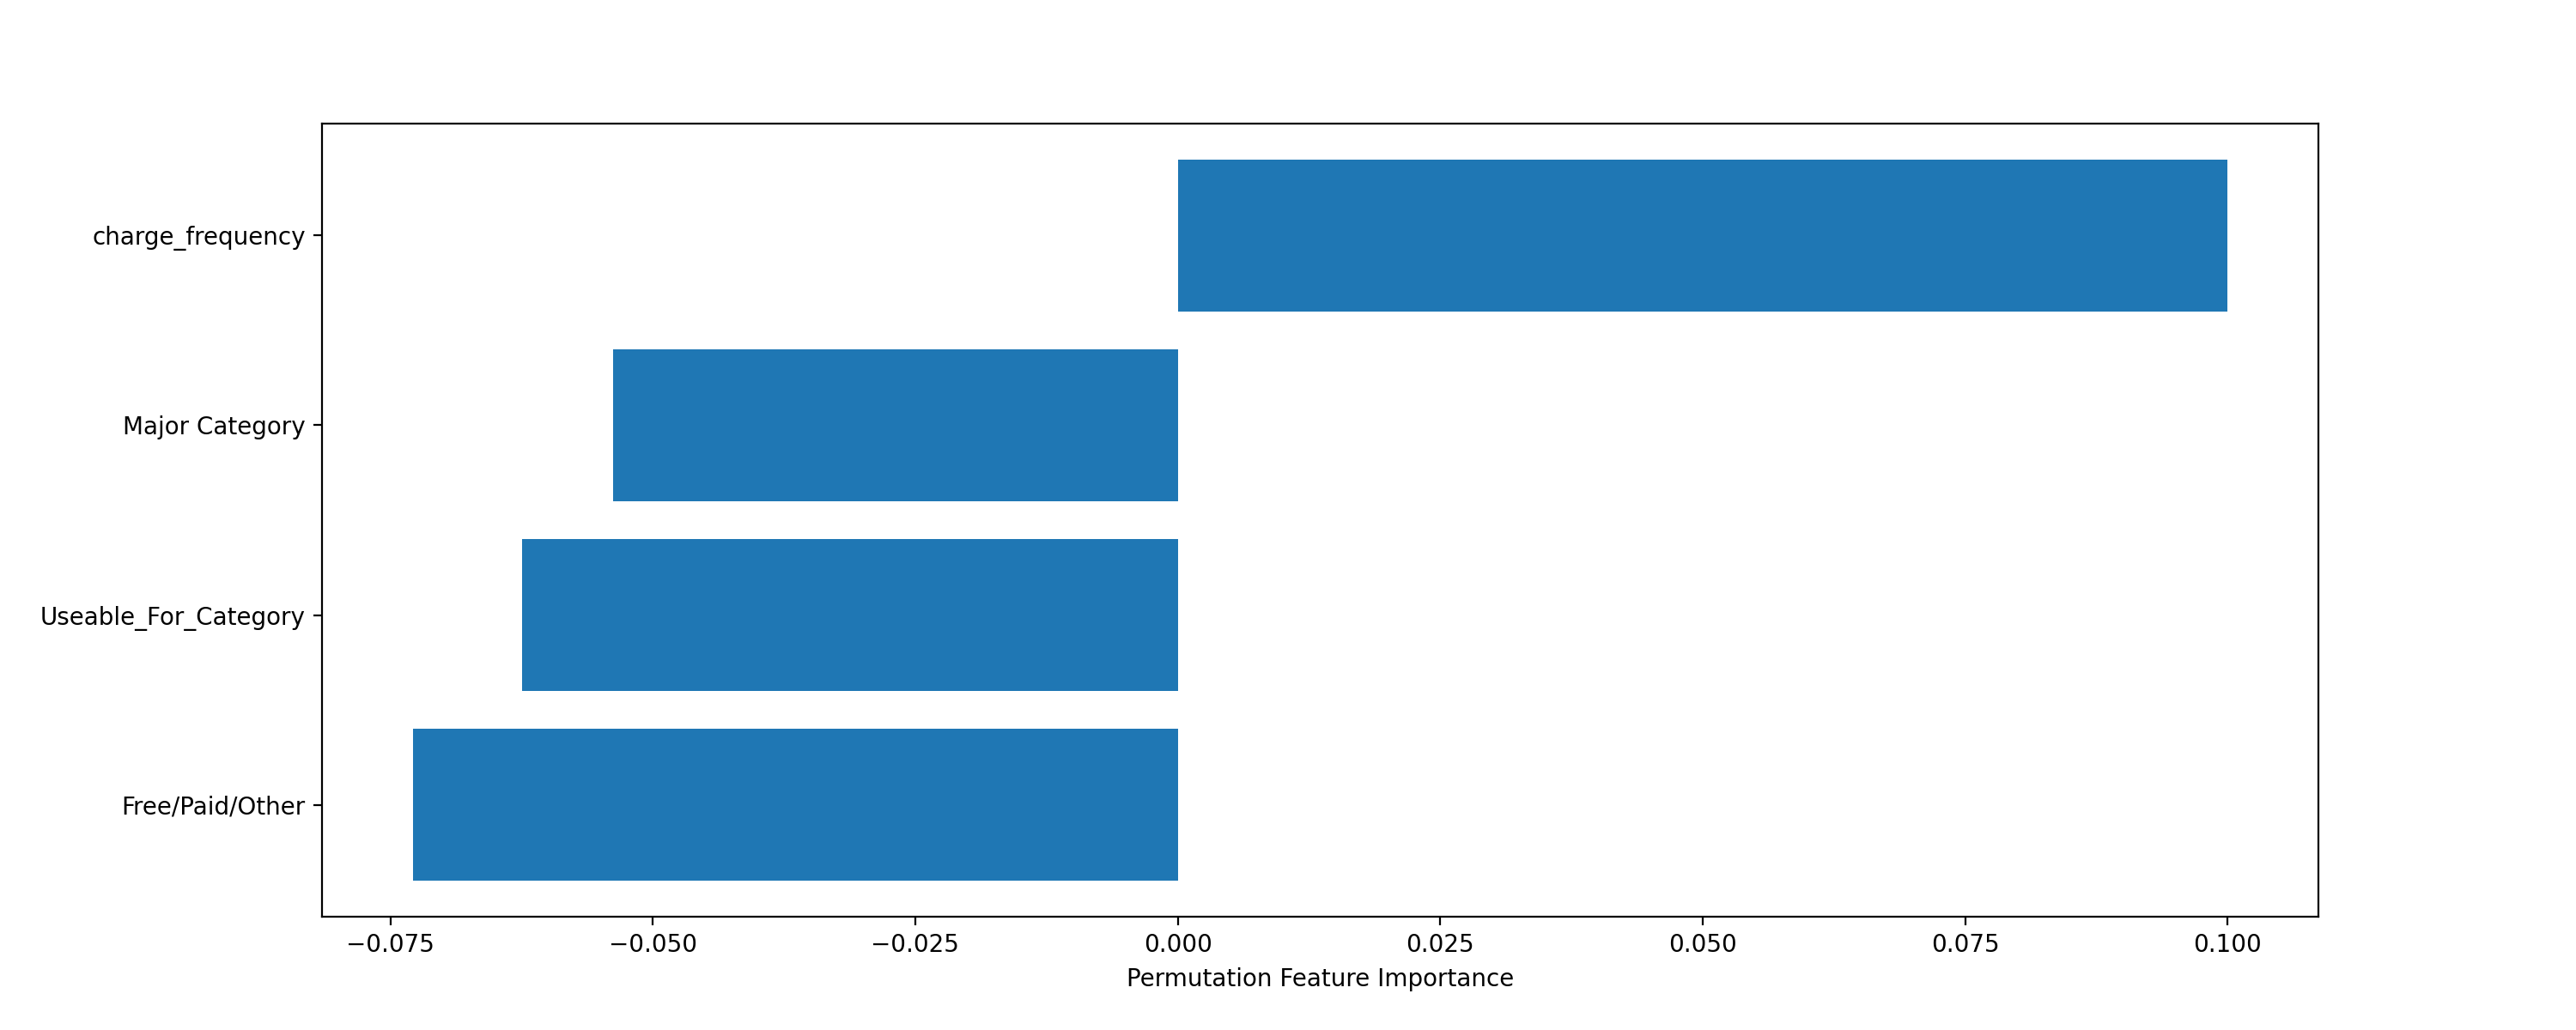

In [ ]:
# Compute permutation feature importance
perm_importance = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=45322)

# Display feature importances
feature_names = X.columns
plt.figure(figsize=(15, 6))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")


####**Predictive Model**: Charge Frequency
How frequent should a company charge their customers?

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

class MultiColumnLabelEncoder(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_encoded = X.apply(LabelEncoder().fit_transform)
        return X_encoded

In [ ]:
# Split the Independent and Dependent Variables
predictors = ['Free/Paid/Other', 'Major Category', 'Useable_For_Category', 'charge_amount']
category = ['Free/Paid/Other', 'Major Category']
text_var = ['Useable_For_Category']
cont = ['charge_amount']

X = ai_topthree[predictors]
y = ai_topthree["charge_frequency"]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=1234)

# Column transformer with separate processing for 'Useable_For_Category'
z = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), cont),
        ('category', MultiColumnLabelEncoder(), category),  # Use MultiColumnLabelEncoder for label encoding
        ('text_var', TfidfVectorizer(tokenizer=lambda x: [token.strip() for token in x.split('/')], lowercase=False), 'Useable_For_Category')
    ],
    remainder='passthrough'
)

# Random Forest Classifier Model - Empty Model
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=24)

# Create Pipeline
pipe_cat = Pipeline([
    ("z", z),
    ("tree", rf)
])

# fit
pipe_cat.fit(X_train, y_train)

# predict
y_pred_train = pipe_cat.predict(X_train)
y_pred_test = pipe_cat.predict(X_test)

y_pred_train_prob = pipe_cat.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe_cat.predict_proba(X_test)[:,1]

##### **Hyperparameter Tuning**
* Random Search CV - Random Forest Classifier
* Recommend the number of estimators to use, max depth of tree, and the random state


In [ ]:
# Random Search CV
param_dist = {
    'tree__n_estimators': [10, 15, 25, 50, 100, 150],
    'tree__max_depth': [None, 5, 10, 15],
    'tree__random_state': [24, 42, 84, 123]

}

# use grid search to find best parameters
grid = RandomizedSearchCV(pipe_cat, param_distributions=param_dist, cv = 5, refit = True)

# fit the training data on the grid search
grid.fit(X_train, y_train)

print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__n_estimators"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__max_depth"])
print("RandomizedSearchCV chose: ", grid.best_estimator_.get_params()["tree__random_state"])

RandomizedSearchCV chose:  100
RandomizedSearchCV chose:  15
RandomizedSearchCV chose:  24


##### Assessing the Performance of the Model

In [ ]:
# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Precision: ", precision_score(y_train, y_pred_train, average ='weighted'))
print("Train Recall    : ", recall_score(y_train, y_pred_train, average = 'weighted'))
print("Train F1        : ", f1_score(y_train, y_pred_train, average = 'weighted'))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test, average = 'weighted'))
print("Test Recall     : ", recall_score(y_test, y_pred_test, average = 'weighted'))
print("Test F1         : ", f1_score(y_test, y_pred_test, average = 'weighted'))

Train Acc       :  0.9083874188716925
Train Precision:  0.9204422302937502
Train Recall    :  0.9083874188716925
Train F1        :  0.8913180612545635
Test Acc        :  0.8761363636363636
Test Prescision :  0.876472283784177
Test Recall     :  0.8761363636363636
Test F1         :  0.8352129277955235


In [ ]:
# Assuming y_pred_train_prob contains the predicted probabilities for each class
y_pred_train_prob = pipe_cat.predict_proba(X_train)  # Replace 'model' with your actual model

# Binarize the labels
y_bin = label_binarize(y_train, classes=np.unique(y_train))

# Initialize variables
roc_auc_scores = []
class_weights = []

# Calculate ROC AUC for each class
for i in range(y_bin.shape[1]):
    roc_auc_i = roc_auc_score(y_bin[:, i], y_pred_train_prob[:, i])
    roc_auc_scores.append(roc_auc_i)
    class_weight_i = np.sum(y_train == i) / (len(y_train) + 1e-9)  # Adding a small value to prevent division by zero
    class_weights.append(class_weight_i)

# Check if all class weights are zero
if np.sum(class_weights) == 0:
    # If all class weights are zero, assign equal weights
    class_weights = np.ones_like(class_weights) / len(class_weights)

# Calculate weighted average ROC AUC
weighted_avg_roc_auc = np.average(roc_auc_scores, weights=class_weights)

print("Train ROC AUC   : ", weighted_avg_roc_auc)

Train ROC AUC   :  0.9760719354299646


In [ ]:
# Assuming y_pred_test_prob contains the predicted probabilities for each class on the test set
y_pred_test_prob = pipe_cat.predict_proba(X_test)  # Replace 'model' with your actual model

# Binarize the labels for the test set
y_bin_test = label_binarize(y_test, classes=np.unique(y_test))

# Initialize variables
roc_auc_scores = []
class_weights = []

# Calculate ROC AUC for each class on the test set
for i in range(y_bin_test.shape[1]):
    roc_auc_i = roc_auc_score(y_bin_test[:, i], y_pred_test_prob[:, i])
    roc_auc_scores.append(roc_auc_i)
    class_weight_i = np.sum(y_test == i) / (len(y_test) + 1e-9)  # Adding a small value to prevent division by zero
    class_weights.append(class_weight_i)

# Check if all class weights are zero
if np.sum(class_weights) == 0:
    # If all class weights are zero, assign equal weights
    class_weights = np.ones_like(class_weights) / len(class_weights)

# Calculate weighted average ROC AUC on the test set
weighted_avg_roc_auc = np.average(roc_auc_scores, weights=class_weights)

print("Test ROC AUC    : ", weighted_avg_roc_auc)

Test ROC AUC    :  0.9298710376720181


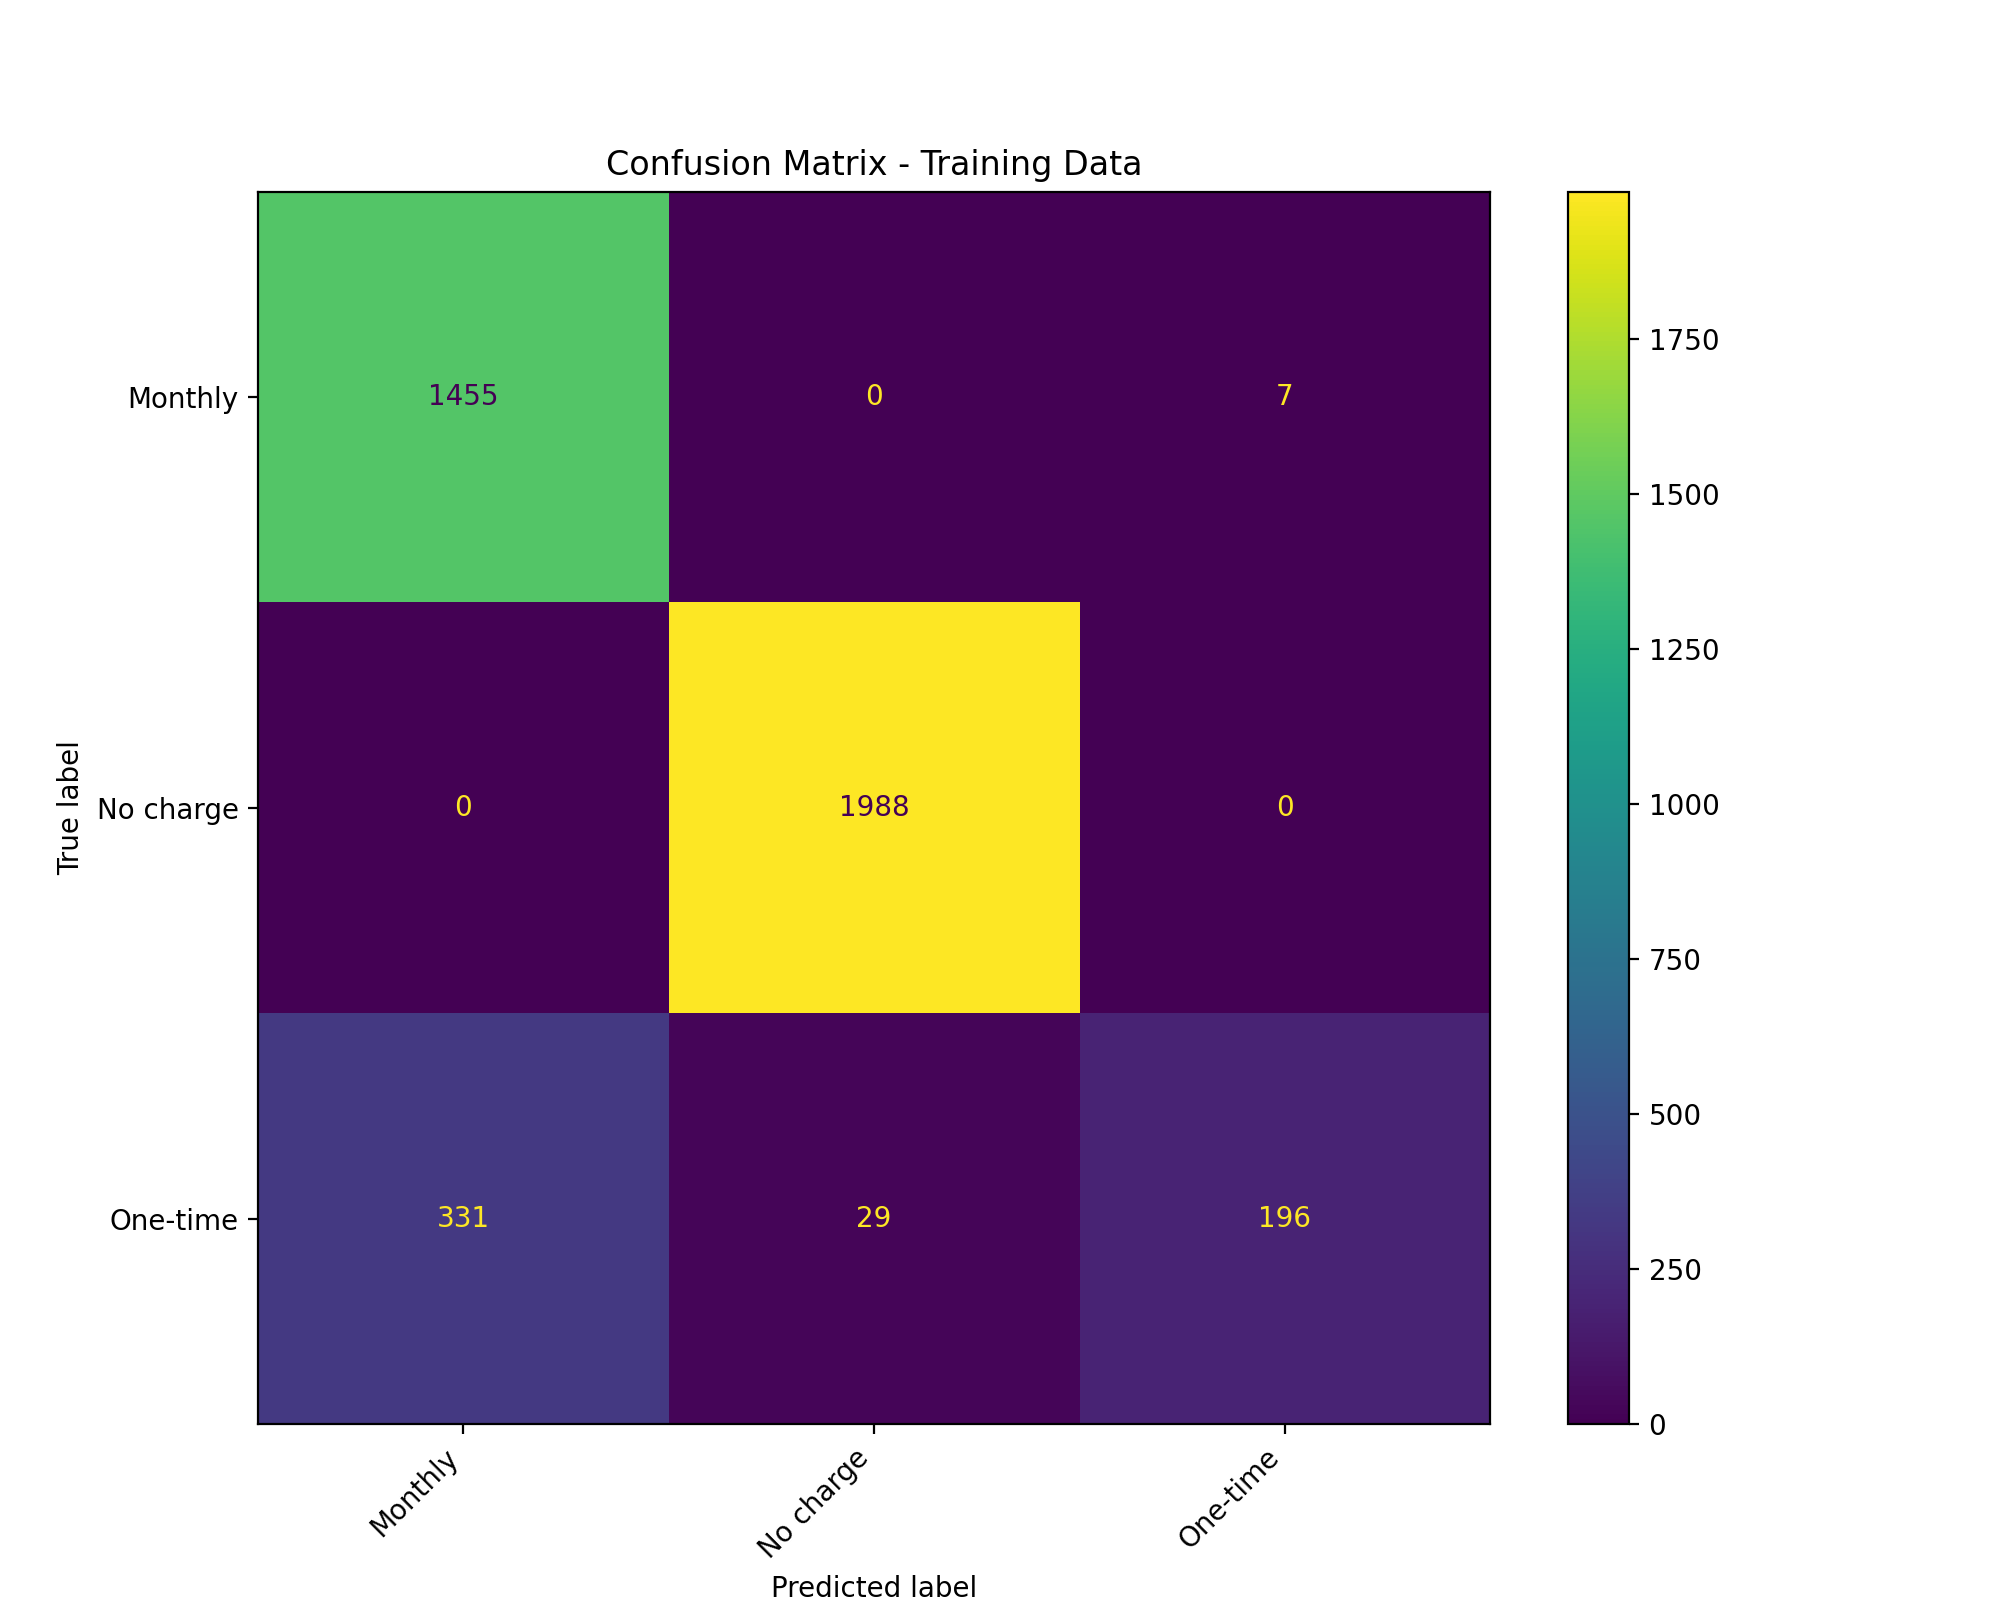

In [ ]:
# Set figure size to adjust height
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Add a title
plt.title("Confusion Matrix - Training Data")

# Create Confusion Matrix Display within a subplot
ax = plt.subplot(111)
disp_train = ConfusionMatrixDisplay.from_estimator(pipe_cat, X_train, y_train, ax=ax)

# Get the current axes and modify the tick labels rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

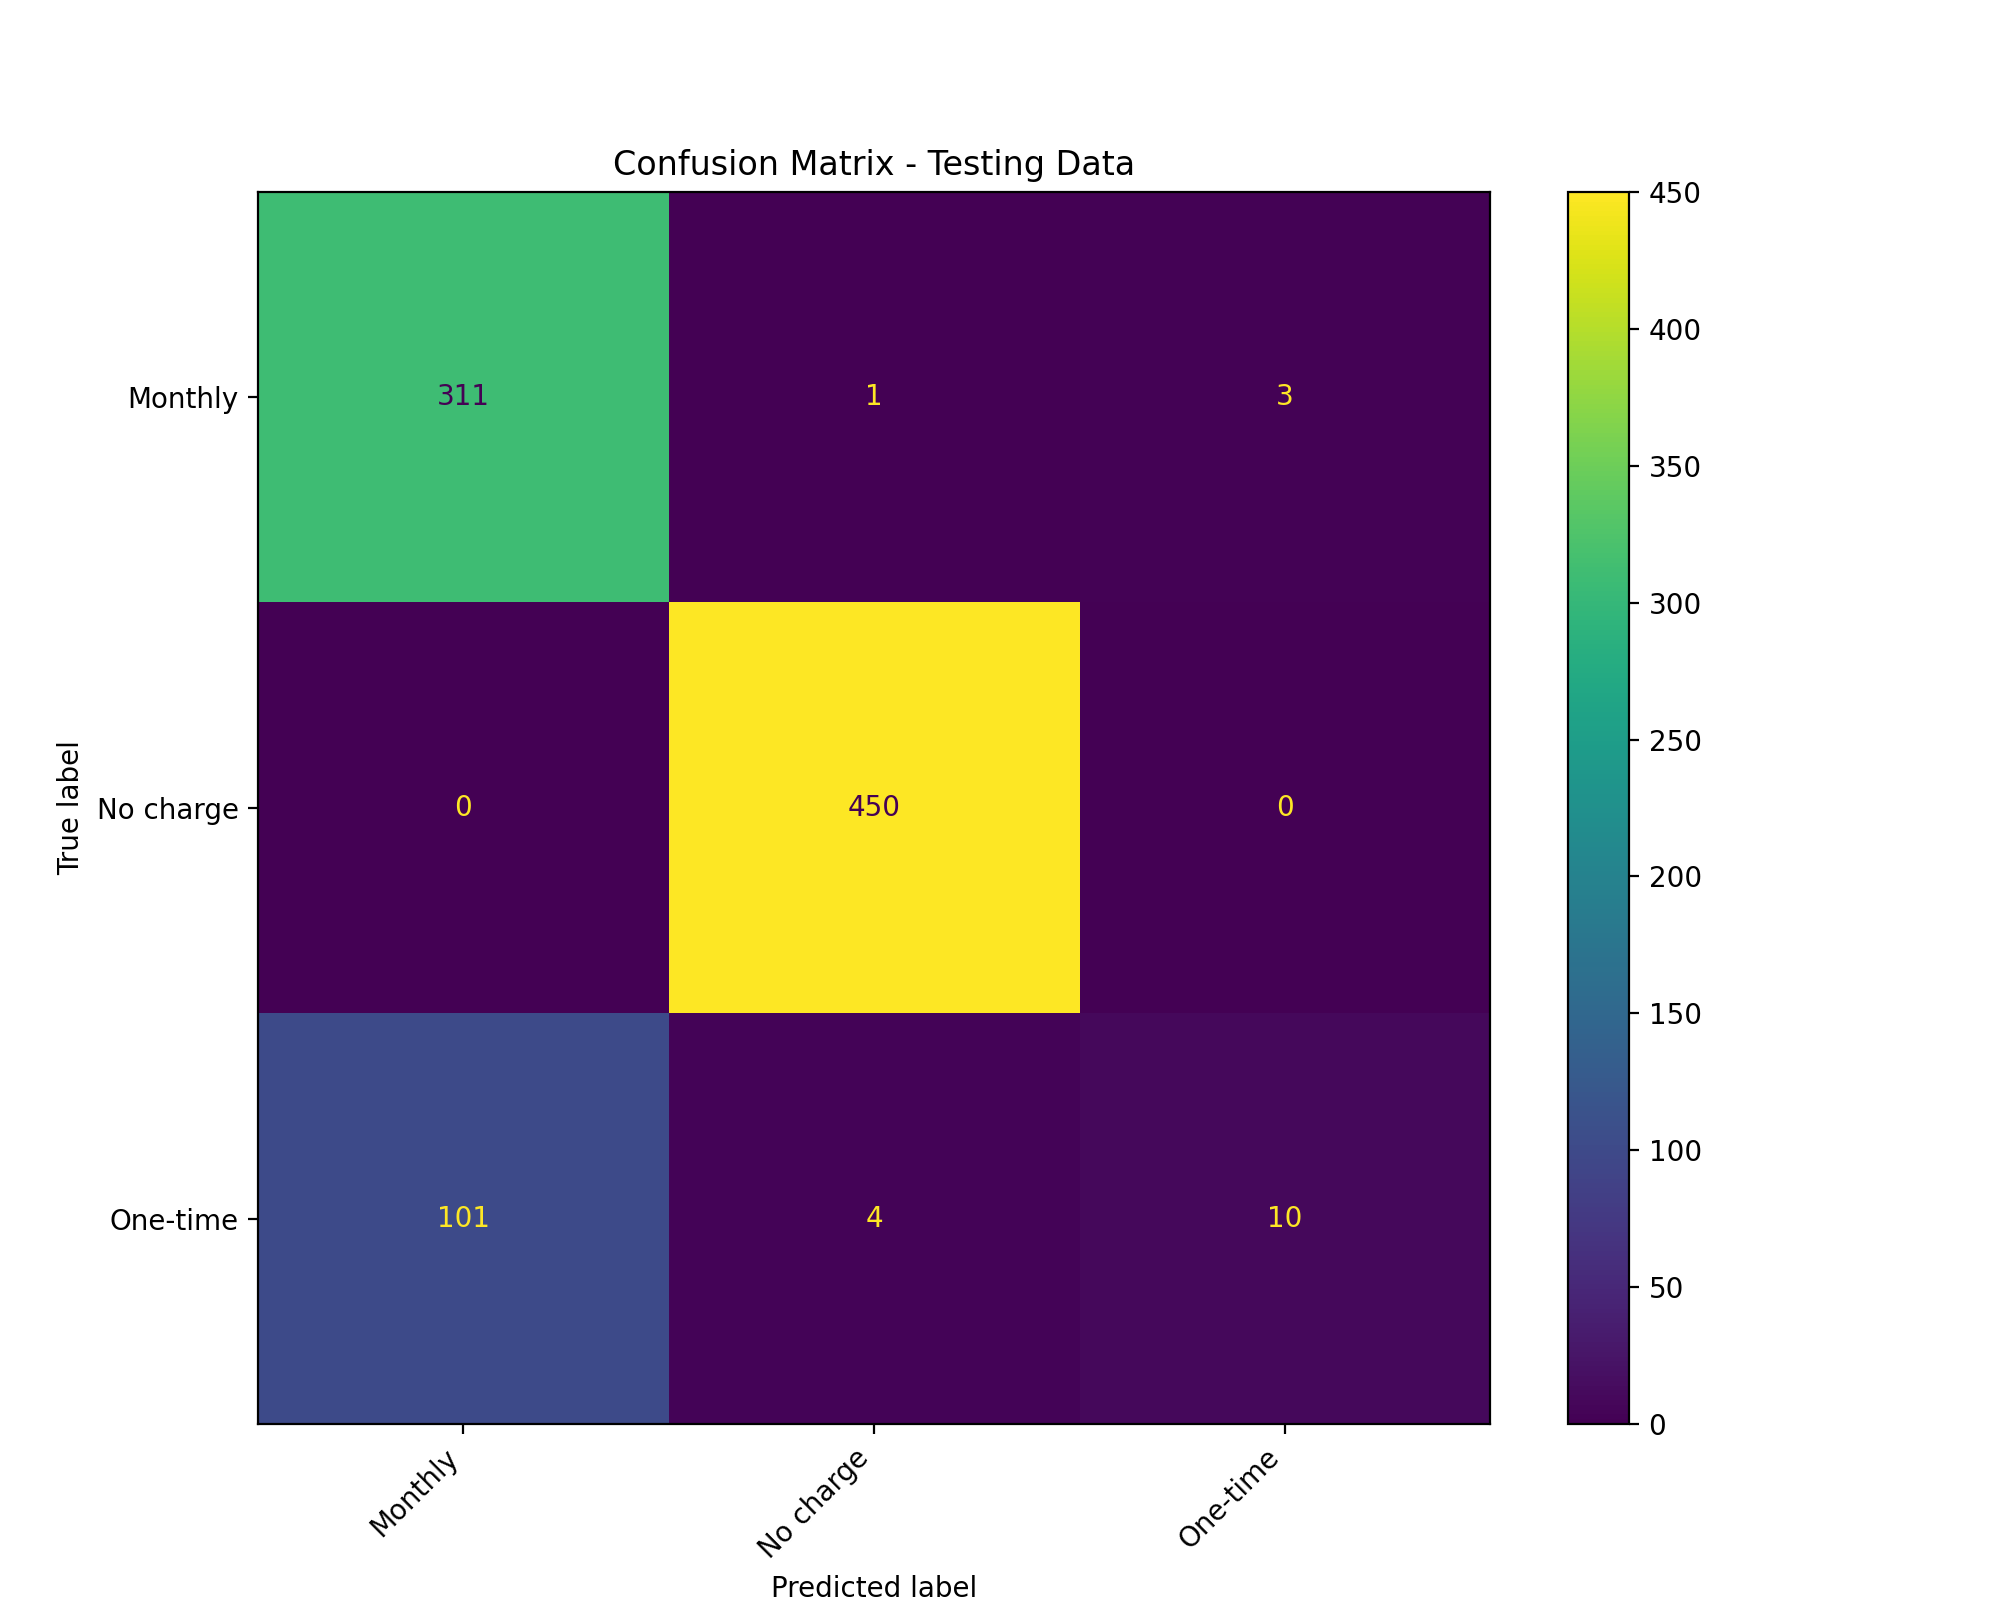

In [ ]:
# Set figure size to adjust height
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Add a title
plt.title("Confusion Matrix - Testing Data")

# Create Confusion Matrix Display within a subplot
ax = plt.subplot(111)
disp_train = ConfusionMatrixDisplay.from_estimator(pipe_cat, X_test, y_test, ax=ax)

# Get the current axes and modify the tick labels rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

In [ ]:
# determine the class indices for each class/value
unique_classes = np.unique(y_train)
class_indices = {i: class_name for i, class_name in enumerate(unique_classes)}

print("Class indices and their corresponding names:")
for index, class_name in class_indices.items():
    print(f"Class {index}: {class_name}")


Class indices and their corresponding names:
Class 0: Monthly
Class 1: No charge
Class 2: One-time


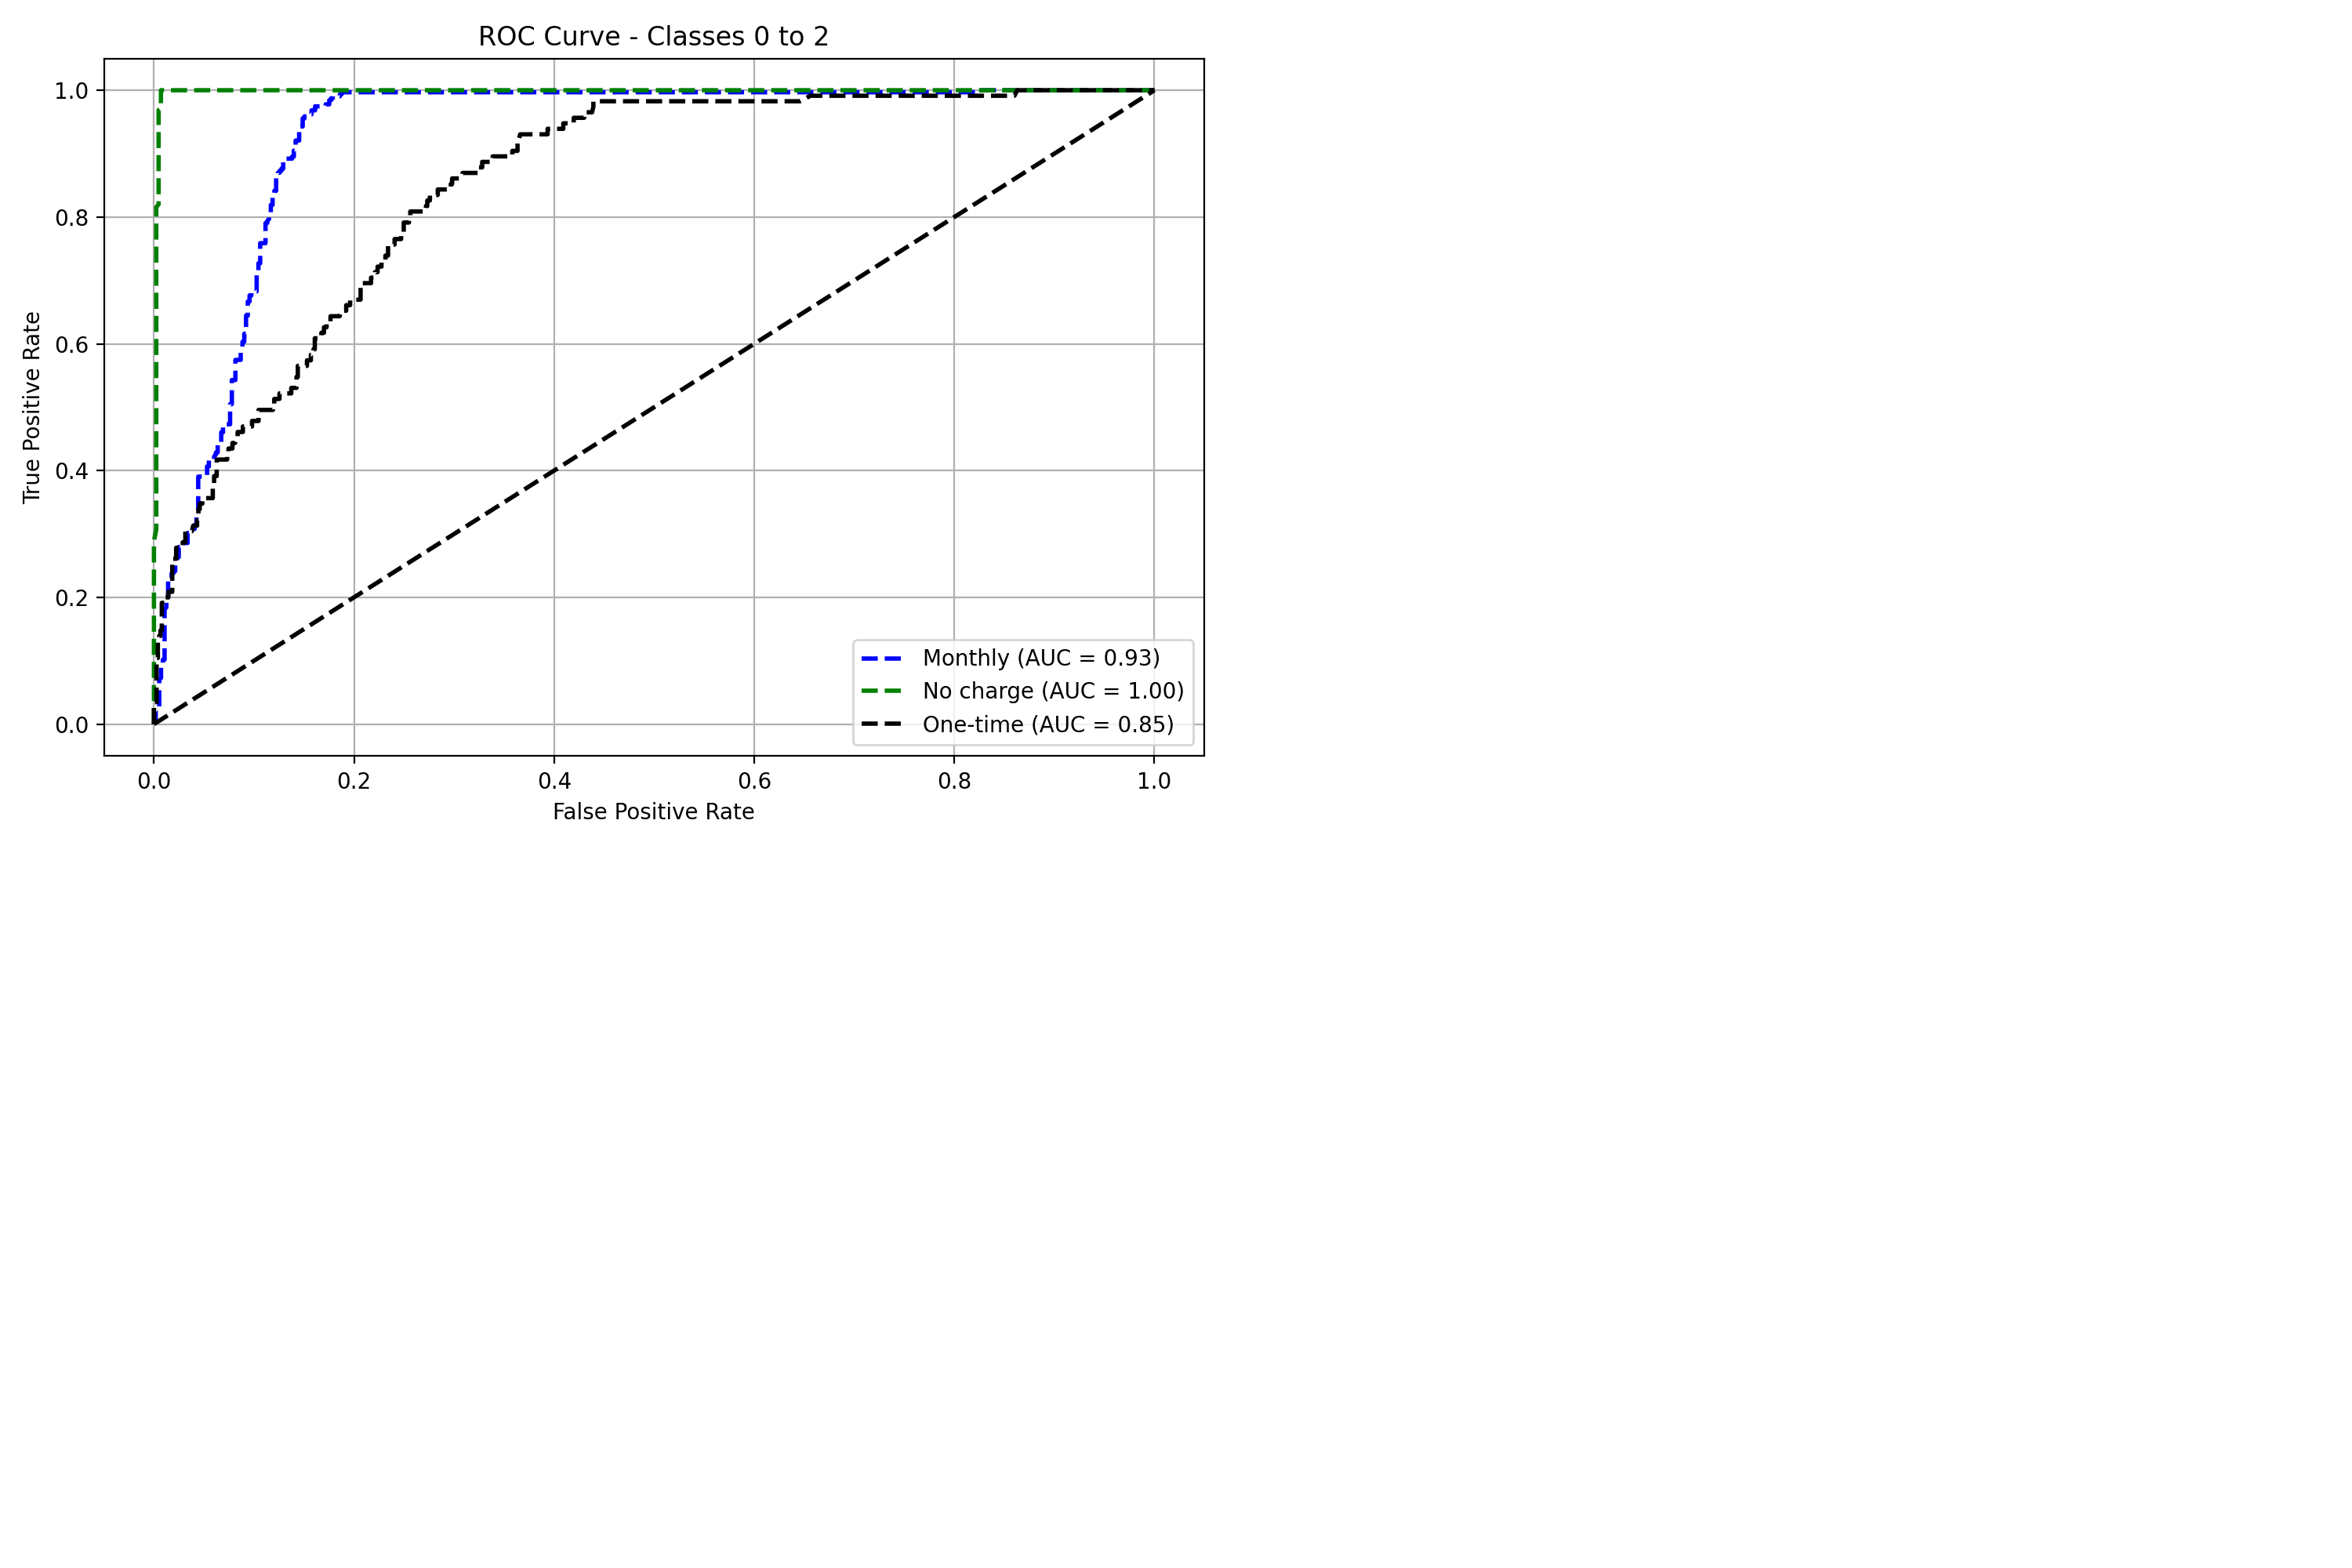

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_bin = label_binarize(y_test, classes=pipe_cat.classes_)

# Create the classifier
classifier = OneVsRestClassifier(pipe_cat)

# Fit the classifier
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(pipe_cat.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = {0: 'Monthly', 1: 'No charge', 2: 'One-time'}
colors = ['b', 'g', 'k', '#FFA07A']

plt.figure(figsize=(15, 10))

for i in range(0, len(pipe_cat.classes_), 3):
    plt.subplot(2, 2, i // 3 + 1)
    for j in range(3):
        class_index = i + j
        if class_index < len(pipe_cat.classes_):
            plt.plot(fpr[class_index], tpr[class_index], lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc[class_index]:.2f})', color=colors[class_index], linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Classes {i} to {i+2}')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.tight_layout()
plt.show()


##**Summary Plots**

### Summary Plot #1
Is there a relation between the Charge Amount and its frequency?

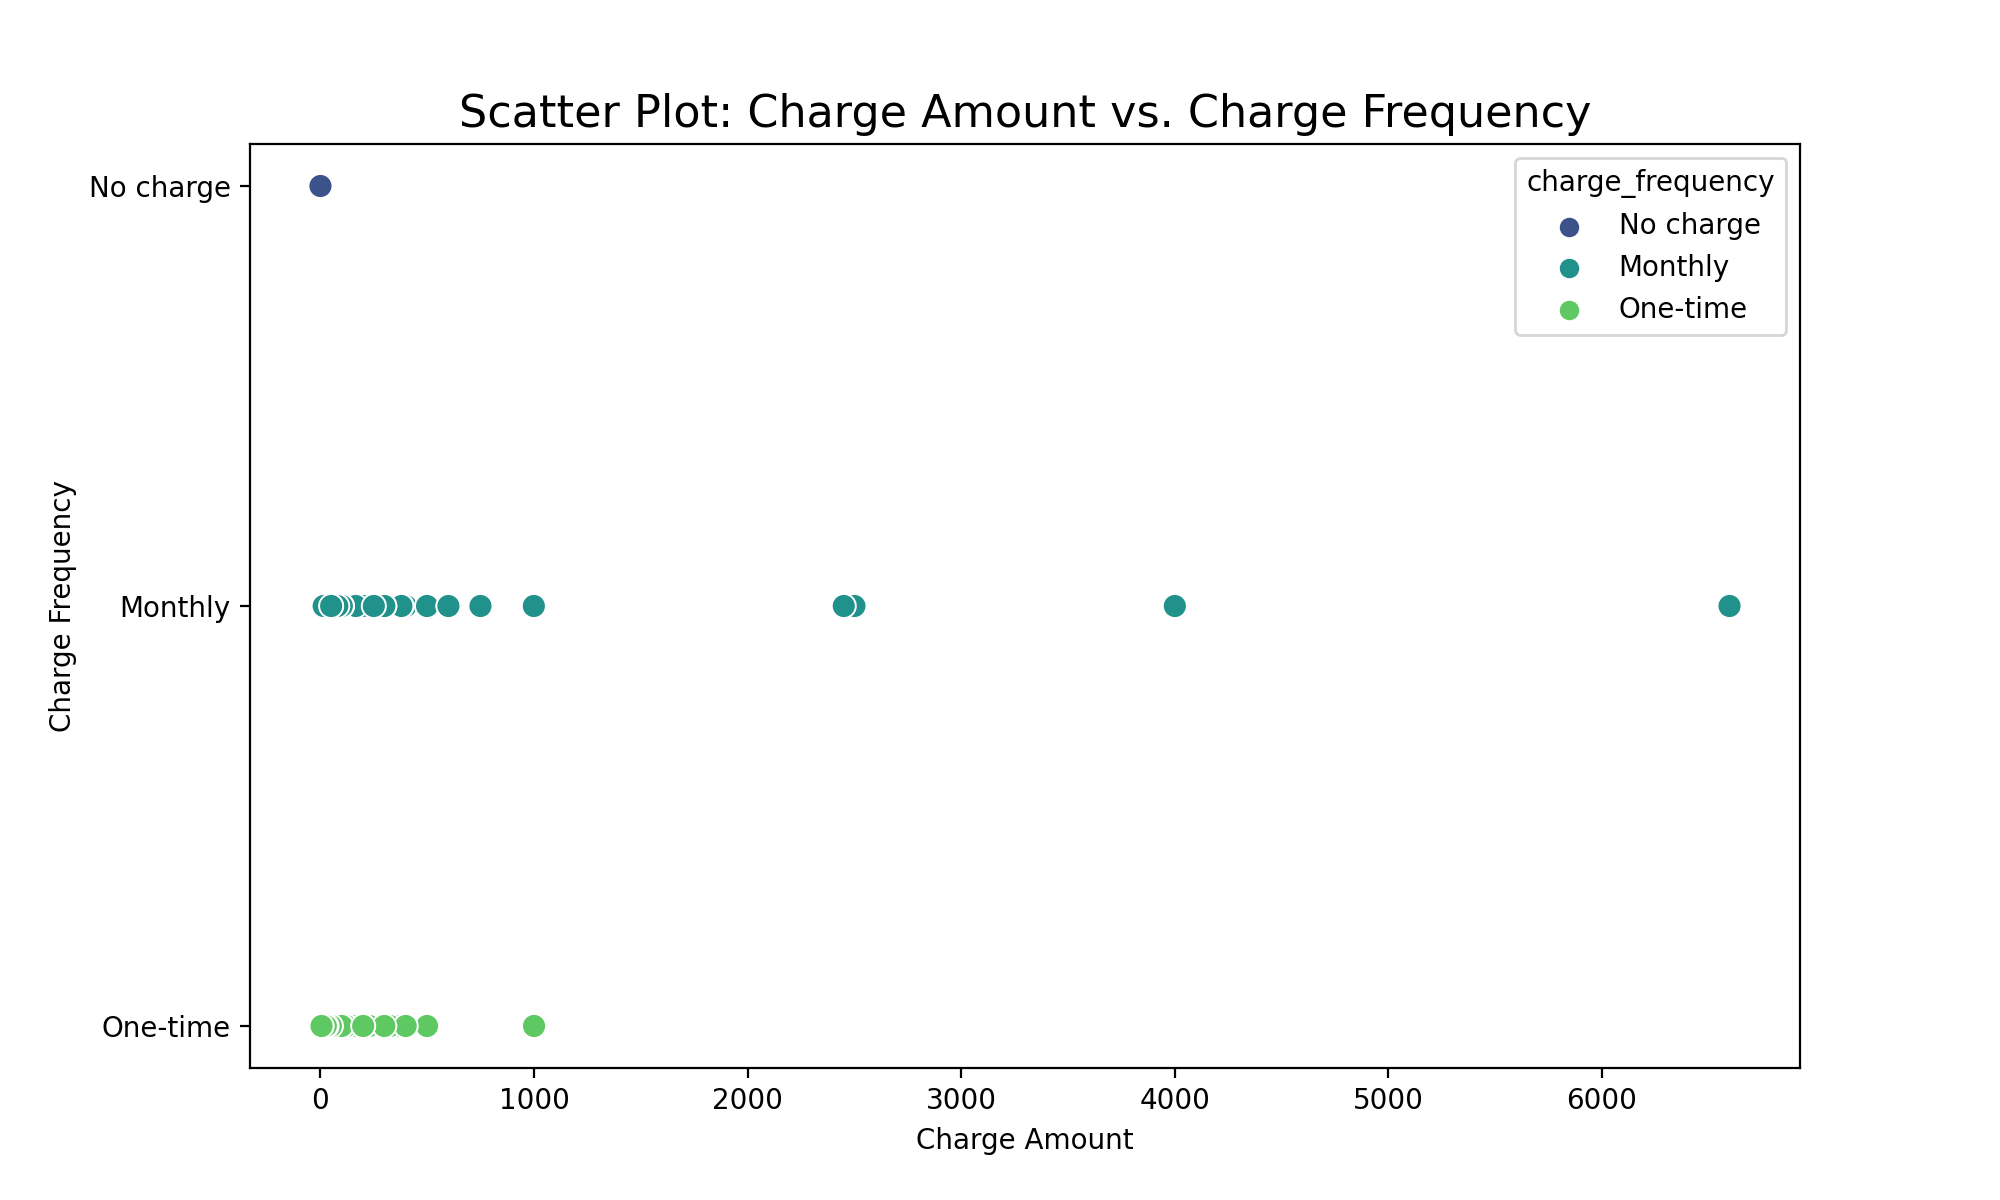

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='charge_amount', y='charge_frequency', data=ai_topthree, hue='charge_frequency', palette='viridis', s = 75)
plt.title('Scatter Plot: Charge Amount vs. Charge Frequency', fontsize=16)
plt.xlabel('Charge Amount')
plt.ylabel('Charge Frequency')
plt.show()

### Summary Plot #2
What is the most popular "major category" amongst the current AI tools?

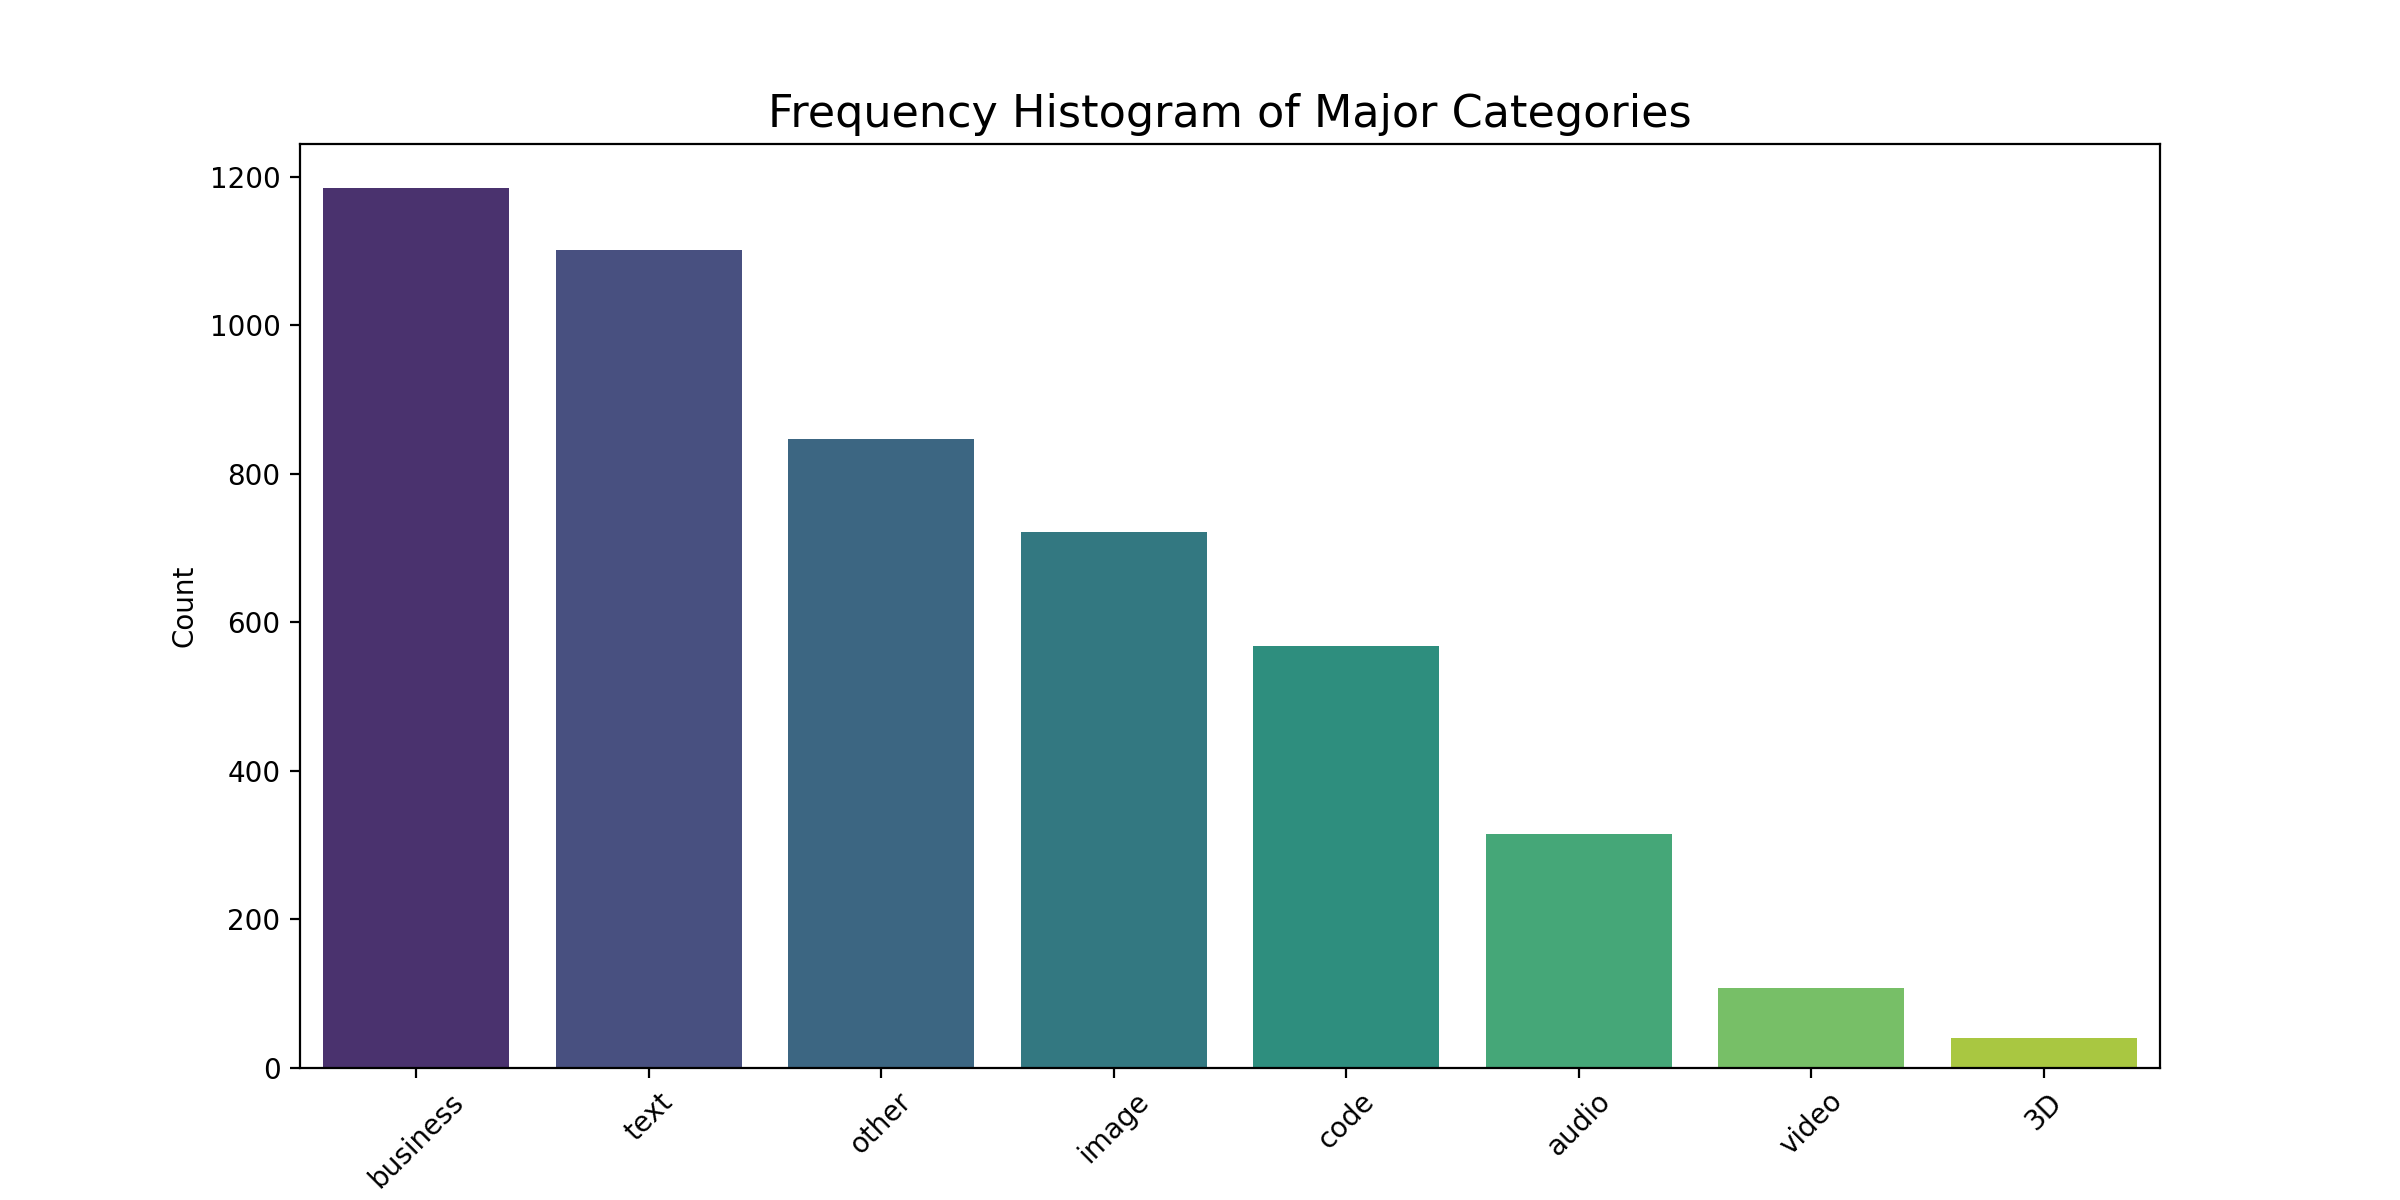

In [ ]:
major_category_counts = ai_topthree['Major Category'].value_counts()

# Sort Major Category values based on their counts in descending order
sorted_major_categories = major_category_counts.index

plt.figure(figsize=(12, 6))
sns.countplot(x='Major Category', data=ai_topthree, order=sorted_major_categories, palette='viridis')
plt.title('Frequency Histogram of Major Categories', fontsize = 16)
plt.xlabel('Major Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()